# Contents
- [Imports](#Imports)
- [Parameters](#Parameters)
- [Scans](#Scans)
- [Plot_alpha](#Plot_alpha)
- [Plot_1Ds](#Plot_1Ds)
- [Debugging](#Debugging)
- [Convergence](#Convergence)

# Imports

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from arc import *
from time import time
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from typing import List, Dict
import gc

from basics import *
from utility import *
from floquet_hamiltonian import *


pi=np.pi
tau=2*pi

# Parameters
## Computational Parameters

In [5]:
# Initialize to None when computational paramters are changed. Lets downstream program know when to re-build basis
basis = None
levels = None
basis_n = None

energies = None
eigenstates = None

# Computational Parameters
scheme = ["red", "mid", "low"][2]

if scheme == "low":
    t_level = RydStateFS(52,1,1/2)
else:
    t_level = RydStateFS(52,1,3/2)
    
max_det = tau*40e9  # radians/s
dl = 2
n_max = 2
single_side = False  # True currently breaks code. Issue in utility.level_starts() function.

comp = {
    "max_det": max_det,
    "dl": dl,
    "n_max": n_max
}

zeeman_offset = 1e4 if scheme == "red" else 1e2

results_dir = r"Shirley-Floquet_results\PolarizabilityPlots\RawData"
plots_dir =  r"Shirley-Floquet_results\PolarizabilityPlots"
zfigs_dir = r"Z:\Public\Hybrid\Publications\Dressing in Cryostat\figures_TODO"

## Physical Parameters

In [6]:
# Physical Parameters
Edc = 0 # V/m
if scheme == "red":
    zerox = {1: 78.6, 2: 82.6, 3: 85.6, 4: 89.6}
    Eac = 89.6 # 19.5  # V/m
    ellipticity = 0.0120
else:
    ellipticity = 0
    if scheme == "mid":
        zero_x = [27.616, 31.346, 59.416]
        Eac = 40.0  # zerox here
        Eac = 28.0
    elif scheme == "low":
        Eac = 30  # zerox here
energy_bands = ellipticity > 1e-3  # TODO, choose a nice threshold for this

if scheme == "red":
    field_omega = tau*4.780e9  #radians/s
elif scheme == "mid":
    field_omega = tau*5.095e9  #radians/s # Mid Detuning
elif scheme == "low":
    # resonance at 6720.5MHz
    field_omega = tau*6.62e9  #radians/s # 52P1/2

theta = 0.0*pi/2  # angle between quantization axis and electric field (radians)

Eac_list = None
Edc_list = None
ellip_list = None
theta_list = None

fields = {
    "Eac": Eac,
    "ellipticity": ellipticity,
    "field_omega": field_omega,
    "Edc": Edc,
    "theta": theta
}

#Edc_list = np.linspace(0,15,100)  # V/m
Eac_list = np.linspace(0,90,300)  # V/m
#ellip_list = np.linspace(0,np.sqrt(0.07),100)**2
#theta_list = np.linspace(0,pi,100)

if Edc_list is not None:
    varied = ("Edc", Edc_list)
elif Eac_list is not None:
    varied = ("Eac", Eac_list)
elif ellip_list is not None:
    varied = ("ellipticity", ellip_list)
elif theta_list is not None:
    varied = ("theta", theta_list)
    
dataset=60
if dataset == 60:
# measured resonance between nP3/2 -> (n-1)D3/2 levels
    p3o2_d3o2_res = 4839*1e6*tau
# for 685nm at +80MHz wrt 4-6' transition. Generator at 191.25MHz
elif dataset == 80:
    p3o2_d3o2_res = 4840*1e6*tau
# effective laser induced AC stark shift
laser_dAC = detuning(RydStateFS(51,2,3/2), t_level, p3o2_d3o2_res)

# Build Basis Lists (Define Hilbert Space)

In [7]:
try:
    energies = None
    eigenstates = None
except NameError:
    pass
if basis is None or levels is None:
    levels, basis = build_basis(t_level,max_det,single_side=single_side, dl=dl)
    t_inds = [ind for ind, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]
    t_states = [basis[i] for i in t_inds]
if basis_n is None:
    basis_n = build_n_basis(basis, n_max)
print(len(basis),len(basis_n))
basis_print(levels)
basis_print(basis_n)

48 240
[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
[
	|52,S,1/2;mj:-1/2,nphot:-2>,
	|52,S,1/2;mj:1/2,nphot:-2>,
	|48,F,5/2;mj:-5/2,nphot:-2>,
	|48,F,5/2;mj:-3/2,nphot:-2>,
	|48,F,5/2;mj:-1/2,nphot:-2>,
	|48,F,5/2;mj:1/2,nphot:-2>,
	|48,F,5/2;mj:3/2,nphot:-2>,
	|48,F,5/2;mj:5/2,nphot:-2>,
	|48,F,7/2;mj:-7/2,nphot:-2>,
	|48,F,7/2;mj:-5/2,nphot:-2>,
	|48,F,7/2;mj:-3/2,nphot:-2>,
	|48,F,7/2;mj:-1/2,nphot:-2>,
	|48,F,7/2;mj:1/2,nphot:-2>,
	|48,F,7/2;mj:3/2,nphot:-2>,
	|48,F,7/2;mj:5/2,nphot:-2>,
	|48,F,7/2;mj:7/2,nphot:-2>,
	|52,P,1/2;mj:-1/2,nphot:-2>,
	|52,P,1/2;mj:1/2,nphot:-2>,
	|52,P,3/2;mj:-3/2,nphot:-2>,
	|52,P,3/2;mj:-1/2,nphot:-2>,
	|52,P,3/2;mj:1/2,nphot:-2>,
	|52,P,3/2;mj:3/2,nphot:-2>,
	|51,D,3/2;mj:-3/2,nphot:-2>,
	|51,D,3/2;mj:-1/2,nphot:-2>,
	|51,D,3/2;mj:1/2,nphot:-2>,
	|51,D,3/2;mj:3/2,nphot:-2>,
	|51,D,5/2;mj:-5/2,nphot:-2>,
	|51,D,5/2;mj:-3/2,nphot:-2>,
	|51,D,5/2;mj:-1/2,nphot:-2>,
	

# Scans
## Scan Parameter specified in physical parameters

In [7]:
try:
    energies = None
    eigenstates = None
except NameError:
    pass
if basis is None or levels is None:
    levels, basis = build_basis(t_level,max_det,single_side=False, dl=dl)
    t_inds = [ind for ind, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]
    t_states = [basis[i] for i in t_inds]
if basis_n is None:
    basis_n = build_n_basis(basis, n_max)


fields_p = {key: value for key, value in fields.items()}
fields_p[varied[0]] = varied[1]

#old_scans = eigen_find(t_level,comp, fields_p)
#loading = False
# TODO : this is broken rn. Implement eigen_terpolate then fix this.
#if loading and len(old_scans) > 0: 
#    energies = np.load(old_scans[0][0].format("energies"))
#    eigenstates = np.load(old_scans[0][0].format("eigenstates"))
#else:
zeeman_offset=1e2
H0 = build_H0(basis, t_level, offset_zeeman=zeeman_offset)
if scheme == "red":
    H0[t_inds,t_inds] += laser_dAC
f_inds = [(ind,state.j) for ind, state in enumerate(basis) if state.l == 3]
f_jsplit = 1e6
jsplit = False
if jsplit:
    for ind, j in f_inds:
        H0[ind,ind] += f_jsplit*j
    
energies, eigenstates, error = floquet_loop(
    basis,
    H0,
    n_max=n_max,
    varied=varied,
    energy_bands=energy_bands,
    **fields
)

#f_name = f"convergenceTest-nmax={n_max}-dw={max_det}-dl={dl}-{{}}"
#filepath = "Shirley-Floquet_results\\convergence_tests"
#np.save(os.path.join(filepath,f_name.format("energies")), energies)
#np.save(os.path.join(filepath,f_name.format("eigenstates")), eigenstates)
#eigen_save(t_level, comp, fields_p, energies, eigenstates)

240
Levels :

[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
little_d built in 0.008649587631225586
Hdc built in 0.0020189285278320312
Hfloquet put together in 0.0005030632019042969
Floquet matrix built after 0.012477874755859375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 0.0, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.01186060905456543s
Normalization Complete after 0.004251241683959961 s
floquet_diag call completed in 0.028589725494384766s
Diagonalization complete for independent variable entry, value 0, 0.0
little_d built in 0.007000446319580078
Hdc built in 0.0010025501251220703
Hfloquet put together in 0.0009975433349609375
Floquet matrix built after 0.009000539779663086 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 0.3010033444816054, ellipticity 0, fiel

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 3.91304347826087, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19306588172912598s
Normalization Complete after 0.0035979747772216797 s
floquet_diag call completed in 0.20624876022338867s
Diagonalization complete for independent variable entry, value 13, 3.91304347826087
re-arrangement done after time 0.003995656967163086s
little_d built in 0.007055759429931641
Hdc built in 0.0010051727294921875
Hfloquet put together in 0.0
Floquet matrix built after 0.009059906005859375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 4.214046822742475, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19176602363586426s
Normalization Complete after 0.002472400665283203 s
floquet_diag call completed in 0.20430684089660645s
Diagonalization complete for independent variable entry, value 14, 4.2

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 8.127090301003346, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19607305526733398s
Normalization Complete after 0.0040056705474853516 s
floquet_diag call completed in 0.2095940113067627s
Diagonalization complete for independent variable entry, value 27, 8.127090301003346
re-arrangement done after time 0.0054759979248046875s
little_d built in 0.008011817932128906
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0
Floquet matrix built after 0.009011983871459961 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 8.42809364548495, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19136977195739746s
Normalization Complete after 0.0035114288330078125 s
floquet_diag call completed in 0.20389318466186523s
Diagonalization complete for independent variable entry, value 28, 8

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 12.34113712374582, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.1951920986175537s
Normalization Complete after 0.002010345458984375 s
floquet_diag call completed in 0.20621323585510254s
Diagonalization complete for independent variable entry, value 41, 12.34113712374582
re-arrangement done after time 0.006018638610839844s
little_d built in 0.007998228073120117
Hdc built in 0.0
Hfloquet put together in 0.0012919902801513672
Floquet matrix built after 0.009794473648071289 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 12.642140468227426, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19417238235473633s
Normalization Complete after 0.003048419952392578 s
floquet_diag call completed in 0.20801496505737305s
Diagonalization complete for independent variable entry, value 42, 12

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 16.555183946488295, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19170308113098145s
Normalization Complete after 0.0030431747436523438 s
floquet_diag call completed in 0.20555710792541504s
Diagonalization complete for independent variable entry, value 55, 16.555183946488295
re-arrangement done after time 0.005104541778564453s
little_d built in 0.008999347686767578
Hdc built in 0.0010008811950683594
Hfloquet put together in 0.0
Floquet matrix built after 0.010000228881835938 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 16.8561872909699, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.18896055221557617s
Normalization Complete after 0.004007101058959961 s
floquet_diag call completed in 0.20438408851623535s
Diagonalization complete for independent variable entry, value 56, 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 20.76923076923077, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.18798279762268066s
Normalization Complete after 0.00400090217590332 s
floquet_diag call completed in 0.2009906768798828s
Diagonalization complete for independent variable entry, value 69, 20.76923076923077
re-arrangement done after time 0.005022525787353516s
little_d built in 0.008999824523925781
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010006904602050781 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 21.070234113712377, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20850586891174316s
Normalization Complete after 0.0030057430267333984 s
floquet_diag call completed in 0.2225184440612793s
Diagonalization complete for independent variable entry, value 70, 21.070234113712377
re

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 24.983277591973245, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.18637824058532715s
Normalization Complete after 0.0040323734283447266 s
floquet_diag call completed in 0.2004103660583496s
Diagonalization complete for independent variable entry, value 83, 24.983277591973245
re-arrangement done after time 0.006430149078369141s
little_d built in 0.008259296417236328
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0
Floquet matrix built after 0.009259223937988281 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 25.284280936454852, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.1942446231842041s
Normalization Complete after 0.0030972957611083984 s
floquet_diag call completed in 0.20768427848815918s
Diagonalization complete for independent variable entry, value 84,

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 29.19732441471572, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19460797309875488s
Normalization Complete after 0.004065752029418945 s
floquet_diag call completed in 0.20867443084716797s
Diagonalization complete for independent variable entry, value 97, 29.19732441471572
re-arrangement done after time 0.005001068115234375s
little_d built in 0.007995367050170898
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0
Floquet matrix built after 0.008995532989501953 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 29.498327759197327, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20387530326843262s
Normalization Complete after 0.0030007362365722656 s
floquet_diag call completed in 0.21587157249450684s
Diagonalization complete for independent variable entry, value 98, 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 33.4113712374582, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19374847412109375s
Normalization Complete after 0.0010073184967041016 s
floquet_diag call completed in 0.20525717735290527s
Diagonalization complete for independent variable entry, value 111, 33.4113712374582
re-arrangement done after time 0.004001140594482422s
little_d built in 0.007999181747436523
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.009138107299804688 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 33.7123745819398, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20091962814331055s
Normalization Complete after 0.0009999275207519531 s
floquet_diag call completed in 0.2110576629638672s
Diagonalization complete for independent variable entry, value 112, 33.7123745819398
re-

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 37.62541806020067, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19664955139160156s
Normalization Complete after 0.004510164260864258 s
floquet_diag call completed in 0.2097623348236084s
Diagonalization complete for independent variable entry, value 125, 37.62541806020067
re-arrangement done after time 0.006006002426147461s
little_d built in 0.00800013542175293
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0009999275207519531
Floquet matrix built after 0.009999990463256836 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 37.92642140468228, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19930481910705566s
Normalization Complete after 0.0023298263549804688 s
floquet_diag call completed in 0.21163463592529297s
Diagonalization complete for independent variable e

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 41.83946488294315, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.1966114044189453s
Normalization Complete after 0.0030059814453125 s
floquet_diag call completed in 0.2100358009338379s
Diagonalization complete for independent variable entry, value 139, 41.83946488294315
re-arrangement done after time 0.004390239715576172s
little_d built in 0.008697032928466797
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010002851486206055 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 42.140468227424755, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.18914437294006348s
Normalization Complete after 0.004007101058959961 s
floquet_diag call completed in 0.2031543254852295s
Diagonalization complete for independent variable entry, value 140, 42.140468227424755
re-

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.05351170568562, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20421433448791504s
Normalization Complete after 0.0042724609375 s
floquet_diag call completed in 0.21811342239379883s
Diagonalization complete for independent variable entry, value 153, 46.05351170568562
re-arrangement done after time 0.005091428756713867s
little_d built in 0.008313179016113281
Hdc built in 0.0010004043579101562
Hfloquet put together in 0.0
Floquet matrix built after 0.009313583374023438 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.35451505016723, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20162034034729004s
Normalization Complete after 0.0030517578125 s
floquet_diag call completed in 0.21398568153381348s
Diagonalization complete for independent variable entry, value 154, 46.3545150

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 50.2675585284281, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19704890251159668s
Normalization Complete after 0.003170013427734375 s
floquet_diag call completed in 0.21024441719055176s
Diagonalization complete for independent variable entry, value 167, 50.2675585284281
re-arrangement done after time 0.004791736602783203s
little_d built in 0.008238792419433594
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.009238481521606445 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 50.568561872909704, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19390439987182617s
Normalization Complete after 0.004102230072021484 s
floquet_diag call completed in 0.2072451114654541s
Diagonalization complete for independent variable entry, value 168, 50.568561872909704
r

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 54.48160535117057, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19723129272460938s
Normalization Complete after 0.0019989013671875 s
floquet_diag call completed in 0.20894074440002441s
Diagonalization complete for independent variable entry, value 181, 54.48160535117057
re-arrangement done after time 0.0045013427734375s
little_d built in 0.007996797561645508
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.009997844696044922 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 54.78260869565218, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.1956033706665039s
Normalization Complete after 0.00417327880859375 s
floquet_diag call completed in 0.20977449417114258s
Diagonalization complete for independent variable entry, value 182, 54.78260869565218
re-arr

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 58.69565217391305, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20457768440246582s
Normalization Complete after 0.0030050277709960938 s
floquet_diag call completed in 0.2185826301574707s
Diagonalization complete for independent variable entry, value 195, 58.69565217391305
re-arrangement done after time 0.003999471664428711s
little_d built in 0.008203983306884766
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0009996891021728516
Floquet matrix built after 0.01020359992980957 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 58.996655518394654, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.1947004795074463s
Normalization Complete after 0.003020048141479492 s
floquet_diag call completed in 0.20792412757873535s
Diagonalization complete for independent variable e

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 62.90969899665552, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.1998133659362793s
Normalization Complete after 0.0021028518676757812 s
floquet_diag call completed in 0.21228575706481934s
Diagonalization complete for independent variable entry, value 209, 62.90969899665552
re-arrangement done after time 0.0035047531127929688s
little_d built in 0.008009195327758789
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.009265899658203125 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 63.21070234113713, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.2051241397857666s
Normalization Complete after 0.0030074119567871094 s
floquet_diag call completed in 0.21839666366577148s
Diagonalization complete for independent variable entry, value 210, 63.21070234113713

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 67.123745819398, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19651508331298828s
Normalization Complete after 0.005151510238647461 s
floquet_diag call completed in 0.2111072540283203s
Diagonalization complete for independent variable entry, value 223, 67.123745819398
re-arrangement done after time 0.0039937496185302734s
little_d built in 0.007999181747436523
Hdc built in 0.0010004043579101562
Hfloquet put together in 0.0
Floquet matrix built after 0.00899958610534668 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 67.4247491638796, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.2000713348388672s
Normalization Complete after 0.004007816314697266 s
floquet_diag call completed in 0.21407842636108398s
Diagonalization complete for independent variable entry, value 224, 67.4247

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 71.33779264214047, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19669818878173828s
Normalization Complete after 0.0010097026824951172 s
floquet_diag call completed in 0.20812582969665527s
Diagonalization complete for independent variable entry, value 237, 71.33779264214047
re-arrangement done after time 0.004038333892822266s
little_d built in 0.008107662200927734
Hdc built in 0.0010006427764892578
Hfloquet put together in 0.0
Floquet matrix built after 0.009108304977416992 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 71.63879598662209, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19931936264038086s
Normalization Complete after 0.004000425338745117 s
floquet_diag call completed in 0.21342873573303223s
Diagonalization complete for independent variable entry, value 238,

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 75.55183946488295, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19634246826171875s
Normalization Complete after 0.003023862838745117 s
floquet_diag call completed in 0.20937180519104004s
Diagonalization complete for independent variable entry, value 251, 75.55183946488295
re-arrangement done after time 0.004000186920166016s
little_d built in 0.007999897003173828
Hdc built in 0.0
Hfloquet put together in 0.0012700557708740234
Floquet matrix built after 0.010272979736328125 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 75.85284280936456, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20178890228271484s
Normalization Complete after 0.004362821578979492 s
floquet_diag call completed in 0.21642470359802246s
Diagonalization complete for independent variable entry, value 252, 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 79.76588628762542, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.2035236358642578s
Normalization Complete after 0.0019996166229248047 s
floquet_diag call completed in 0.21584534645080566s
Diagonalization complete for independent variable entry, value 265, 79.76588628762542
re-arrangement done after time 0.003999948501586914s
little_d built in 0.007999420166015625
Hdc built in 0.0010004043579101562
Hfloquet put together in 0.0
Floquet matrix built after 0.010350942611694336 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 80.06688963210703, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19874000549316406s
Normalization Complete after 0.005001068115234375 s
floquet_diag call completed in 0.21409201622009277s
Diagonalization complete for independent variable entry, value 266, 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 83.9799331103679, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20506525039672852s
Normalization Complete after 0.0020079612731933594 s
floquet_diag call completed in 0.2188584804534912s
Diagonalization complete for independent variable entry, value 279, 83.9799331103679
re-arrangement done after time 0.00400853157043457s
little_d built in 0.007965326309204102
Hdc built in 0.0010051727294921875
Hfloquet put together in 0.0
Floquet matrix built after 0.008970499038696289 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 84.28093645484951, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20692825317382812s
Normalization Complete after 0.004006385803222656 s
floquet_diag call completed in 0.22096896171569824s
Diagonalization complete for independent variable entry, value 280, 84.

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 88.19397993311037, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.1981213092803955s
Normalization Complete after 0.004205226898193359 s
floquet_diag call completed in 0.21074724197387695s
Diagonalization complete for independent variable entry, value 293, 88.19397993311037
re-arrangement done after time 0.005080223083496094s
little_d built in 0.008640766143798828
Hdc built in 0.0
Hfloquet put together in 0.0010004043579101562
Floquet matrix built after 0.009641170501708984 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 88.49498327759198, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20159602165222168s
Normalization Complete after 0.0030090808868408203 s
floquet_diag call completed in 0.21524930000305176s
Diagonalization complete for independent variable entry, value 294, 

# Scan $E_{AC}$ or $\theta$ and check 2nd + 4th order DC polarizability 

In [10]:
def check_polarizability(
    basis: List[RydStateFS], 
    H0: np.ndarray,
    dc_end: float, 
    samples: int,
    comp: Dict[str, int],
    fields: Dict[str, float],
    energy_bands: bool=False
) -> np.ndarray:
    """
    Determines the polarizability of all states in basis for AC/DC field parameters
    provided in fields dict.
    
    Args:
        basis: list of atomic states considered in computation
        H0: Hamiltonian of unperturbed atom system (expected to be diagonal). Matrix
            elements should be reported in radial frequency (radians/s)
        dc_end: maximum electric field strength to be sampled. dc electric field values
            are sampled from 0 to dc_end
        samples: number of dc electric field strength values to take. System is prone to crashing when
            too few samples are provided. Stable for when 100 samples per 20 volt span
        fields: dict of AC and DC field values. Currently the following parameters are expected
            to be represented in fields:
                "Eac" : Electric field strength of the AC field (V/m)
                "ellipticity" : ellipticity of the AC field. Field polarization defined as
                    e_ac = sqrt(1-ellipticity)e_pi + sqrt(ellipticity)e_+
                "field_omega" : oscillation frequency of the AC. Reported in radial frequency (radians/s)
                "Edc" : Ignored if included in fields dict
                "theta" : angle between quantization axis and electric field direction (radians)
        comp: dict of computational parameters used for this computation. Keys:
            "max_det" : float, maximum energy difference between t_level and any level included
                in the basis used in the computation
            "dl" : int, maximum difference between t_level.l and the orbital angular momentum
                quantum number of other states in the basis, |l-lp| <= dl
            "n_max" : int, maximum number of fourier components of the AC field to include in the
                computation
    Returns:
        popts: list of fit parameters. popts.shape = (len(basis)*(2*n_max+1), len(fit_args))
            when fits == True:
                fit_args = v0, alpha, e0, beta. Parameters for a 4th order fit to the numeric data
                func = e0+alpha*(v-v0)**2+beta*(v-v0)**4
        
    """
    dcs = ("Edc", np.linspace(0,dc_end,samples))
    energies, eigenstates, error = floquet_loop(basis, H0, n_max=comp["n_max"], varied = dcs, energy_bands=energy_bands, **fields)
    
    if error is not None:
        return None, None, error
    quad = lambda v, v0, alpha, e0, beta: e0-1/2*alpha*(v-v0)**2+1/factorial(4)*beta*(v-v0)**4
    guess = [0,0,0,0]
    
    fits = True
    
    dim = len(basis)*(2*n_max+1)
    popts = np.zeros((dim, len(guess)), dtype=float)
    perrs = np.zeros(popts.shape, dtype=float)

    for i in range(dim):
        band_energies = energies[i,:]
        guess = guess = [0.0, (band_energies[-1]-band_energies[0])/dc_end**2, band_energies[samples//2],0]
        if fits:
            try:
                popt, pcov = curve_fit(quad, dcs[1], band_energies, p0 = guess)
                perr = np.sqrt(np.diag(pcov))

                popts[i] = popt
                perrs[i] = perr
            except RuntimeError:
                print("WARNING: Error fitting polarizability data")
                popts[i] = np.NaN
                perrs[i] = np.NaN    
        else:
            dmax_abs = max(abs(band_energies-band_energies[0]))
            dmax_ind = np.argwhere(abs(band_energies-band_energies[0])==dmax_abs)[0,0]
            print(dmax_abs,dmax_ind)
            dmax = (band_energies-band_energies[0])[dmax_ind]
            e_max = dcs[1][dmax_ind]
            popts[i,2] = dmax/e_max**2
            perrs[i,2] = np.NaN
            
    fields["Edc"] = dcs[1]
    eigen_save(t_level, comp, fields, energies, eigenstates)
    es0 = eigenstates[...,0]
    del energies
    del eigenstates
    return popts, perrs, es0

try:
    del energies
    del eigenstates
except NameError:
    pass

# build basis if not already built
if basis is None or levels is None:
    levels, basis = build_basis(t_level,max_det,single_side=False, dl=dl)
    t_inds = [ind for ind, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]
if basis_n is None:
    basis_n = build_n_basis(basis, n_max)

fields_p = {key: value for key, value in fields.items()}
fields_p[varied[0]] = varied[1]


H0 = build_H0(basis,t_level, offset_zeeman=zeeman_offset)
if scheme == "red":
    H0[t_inds,t_inds] += laser_dAC
f_inds = [(ind,state.j) for ind, state in enumerate(basis) if state.l == 2]
f_jsplit = 0

samples = 100
Emax = 15
# set Eac to 2nd order zero-crossing when theta is scanned
if scheme == "red":
    zerox = {1: 78.6, 2: 82.6, 3: 85.6, 4: 89.6}
    Eac=zerox[4] 
elif scheme == "mid":
    Eac = zero_x[2]
elif scheme == "low":
    zerox = 46.831
    Eac=zerox

    
# Eac and theta values to sample
Eacs = np.linspace(0,100,21)  # V/m
thetas = np.linspace(-pi/2,pi/2,21)  # radians

sweep_ac = False  # scan Eac Values
sweep_theta = True  # scan theta values

if sweep_ac:
    alphas = np.zeros((len(Eacs),len(basis)*(2*n_max+1)),dtype=float)
    dalphas = np.zeros(alphas.shape,dtype=float)
    popts = np.zeros((len(Eacs),len(basis)*(2*n_max+1),4),dtype=float)
    perrs = np.zeros(popts.shape,dtype=float)
    es0s = np.zeros((len(Eacs),len(basis_n),len(basis_n)),dtype=float)
    # failed = False

    for i, eac in enumerate(Eacs):
        fields["theta"] = theta
        fields["Eac"] = eac
        try:
            popts[i], perrs[i], es0s[i] = check_polarizability(basis, H0, Emax, samples, comp, fields, energy_bands)
        except ValueError:
            print(f"WARNING: failed to check polarizability for field values :\n{fields}")
        # If one point fails try again on the next point. If two in a row fail, raise the error
            popts[i] = np.NaN
            perrs[i] = np.NaN
            es0s[i] = np.NaN

    alphas = popts[...,1]
    dalphas = perrs[...,1]
    popts_eac = popts
    perrs_eac = perrs
    es0s_eac = es0s

if sweep_theta:
    alphas = np.zeros((len(thetas),len(basis)*(2*n_max+1)),dtype=float)
    dalphas = np.zeros(alphas.shape,dtype=float)
    popts = np.zeros((len(thetas),len(basis)*(2*n_max+1),4),dtype=float)
    perrs = np.zeros(popts.shape,dtype=float)
    es0s = np.zeros((len(Eacs),len(basis_n),len(basis_n)),dtype=float)
    # failed = False

    for i, th in enumerate(thetas):
        fields["Eac"] = Eac
        fields["theta"] = th
        try:
            popt, perr, err = check_polarizability(basis, H0, Emax, samples, comp, fields, energy_bands)
            if type(err) is dict:
                popts[i] = np.NaN
                perrs[i] = np.NaN
                es0s[i] = np.NaN
                print(f"WARNING: failed to check polarizability for field values :\n{fields}\n Likely effor in Floquet Loop organization")
            else:
                popts[i], perrs[i], es0s[i] = popt, perr, err
        except ValueError as e:
            print(f"WARNING: failed to check polarizability for field values :\n{fields}\n{e}")
        # If one point fails try again on the next point. If two in a row fail, raise the error
            popts[i] = np.NaN
            perrs[i] = np.NaN
            es0s[i] = np.NaN

    popts_theta = popts
    perrs_theta = perrs
    es0s_theta = es0s

nan_inds = np.argwhere(np.isnan(popts))
err_eacinds = list({ind for ind in nan_inds[:,0]})
err_eacs = [Eacs[ind] for ind in err_eacinds]
print(err_eacs)

240
Levels :

[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
little_d built in 0.014145612716674805
Hdc built in 0.0010120868682861328
Hfloquet put together in 0.001013040542602539
Floquet matrix built after 0.016170740127563477 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.0, theta -1.5707963267948966
Diagonalized after time: 0.3075697422027588s
Normalization Complete after 0.006636381149291992 s
floquet_diag call completed in 0.3313770294189453s
Diagonalization complete for independent variable entry, value 0, 0.0
little_d built in 0.013633251190185547
Hdc built in 0.001965761184692383
Hfloquet put together in 0.0010023117065429688
Floquet matrix built after 0.0166013240814209 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, fi

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.9696969696969697, theta -1.5707963267948966
Diagonalized after time: 0.31659698486328125s
Normalization Complete after 0.0030298233032226562 s
floquet_diag call completed in 0.3356454372406006s
Diagonalization complete for independent variable entry, value 13, 1.9696969696969697
re-arrangement done after time 0.007970333099365234s
little_d built in 0.01399850845336914
Hdc built in 0.001003265380859375
Hfloquet put together in 0.0010232925415039062
Floquet matrix built after 0.016025066375732422 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.121212121212121, theta -1.5707963267948966
Diagonalized after time: 0.3281717300415039s
Normalization Complete after 0.007018566131591797 s
floquet_diag call completed in 0.3522152900695801s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.9393939393939394, theta -1.5707963267948966
Diagonalized after time: 0.33696579933166504s
Normalization Complete after 0.005027294158935547 s
floquet_diag call completed in 0.35997486114501953s
Diagonalization complete for independent variable entry, value 26, 3.9393939393939394
re-arrangement done after time 0.007632255554199219s
little_d built in 0.014073848724365234
Hdc built in 0.0020148754119873047
Hfloquet put together in 0.0010182857513427734
Floquet matrix built after 0.017107009887695312 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.090909090909091, theta -1.5707963267948966
Diagonalized after time: 0.31093859672546387s
Normalization Complete after 0.0060176849365234375 s
floquet_diag call completed in 0.3340632915496826s
Diagona

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.909090909090909, theta -1.5707963267948966
Diagonalized after time: 0.3246490955352783s
Normalization Complete after 0.006018638610839844 s
floquet_diag call completed in 0.3486497402191162s
Diagonalization complete for independent variable entry, value 39, 5.909090909090909
re-arrangement done after time 0.009999752044677734s
little_d built in 0.014035701751708984
Hdc built in 0.0009770393371582031
Hfloquet put together in 0.001524209976196289
Floquet matrix built after 0.016536951065063477 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.0606060606060606, theta -1.5707963267948966
Diagonalized after time: 0.33478260040283203s
Normalization Complete after 0.007003068923950195 s
floquet_diag call completed in 0.3583226203918457s
Diagonalizat

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.878787878787879, theta -1.5707963267948966
Diagonalized after time: 0.3141975402832031s
Normalization Complete after 0.006005525588989258 s
floquet_diag call completed in 0.33597421646118164s
Diagonalization complete for independent variable entry, value 52, 7.878787878787879
re-arrangement done after time 0.006982564926147461s
little_d built in 0.013955831527709961
Hdc built in 0.0020017623901367188
Hfloquet put together in 0.001024484634399414
Floquet matrix built after 0.016982078552246094 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.030303030303031, theta -1.5707963267948966
Diagonalized after time: 0.33370041847229004s
Normalization Complete after 0.002018451690673828 s
floquet_diag call completed in 0.353701114654541s
Diagonalizati

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.84848484848485, theta -1.5707963267948966
Diagonalized after time: 0.3490769863128662s
Normalization Complete after 0.0060272216796875 s
floquet_diag call completed in 0.3721039295196533s
Diagonalization complete for independent variable entry, value 65, 9.84848484848485
re-arrangement done after time 0.00706171989440918s
little_d built in 0.014612436294555664
Hdc built in 0.0011048316955566406
Hfloquet put together in 0.0005164146423339844
Floquet matrix built after 0.01623368263244629 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.0, theta -1.5707963267948966
Diagonalized after time: 0.31662678718566895s
Normalization Complete after 0.006016254425048828 s
floquet_diag call completed in 0.3399317264556885s
Diagonalization complete for in

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.818181818181818, theta -1.5707963267948966
Diagonalized after time: 0.31783342361450195s
Normalization Complete after 0.004042863845825195 s
floquet_diag call completed in 0.3378579616546631s
Diagonalization complete for independent variable entry, value 78, 11.818181818181818
re-arrangement done after time 0.007584095001220703s
little_d built in 0.014014244079589844
Hdc built in 0.0009949207305908203
Hfloquet put together in 0.0010676383972167969
Floquet matrix built after 0.017133474349975586 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.96969696969697, theta -1.5707963267948966
Diagonalized after time: 0.32297658920288086s
Normalization Complete after 0.0059757232666015625 s
floquet_diag call completed in 0.3470876216888428s
Diagonal

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.787878787878789, theta -1.5707963267948966
Diagonalized after time: 0.33443379402160645s
Normalization Complete after 0.006041526794433594 s
floquet_diag call completed in 0.35809326171875s
Diagonalization complete for independent variable entry, value 91, 13.787878787878789
re-arrangement done after time 0.0070002079010009766s
little_d built in 0.015000343322753906
Hdc built in 0.001962900161743164
Hfloquet put together in 0.0
Floquet matrix built after 0.01696324348449707 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.93939393939394, theta -1.5707963267948966
Diagonalized after time: 0.3266925811767578s
Normalization Complete after 0.005998134613037109 s
floquet_diag call completed in 0.349653959274292s
Diagonalization complete for ind

C:\Users\Juan\Envs\rydberg\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-10-d0bf5ac8e245>:176: ComplexWarning: Casting complex values to real discards the imaginary part
  popts[i], perrs[i], es0s[i] = popt, perr, err


240
Levels :

[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
little_d built in 0.014000177383422852
Hdc built in 0.0009691715240478516
Hfloquet put together in 0.000993490219116211
Floquet matrix built after 0.015962839126586914 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.0, theta -1.413716694115407
Diagonalized after time: 0.27741479873657227s
Normalization Complete after 0.006017446517944336 s
floquet_diag call completed in 0.30039501190185547s
Diagonalization complete for independent variable entry, value 0, 0.0
little_d built in 0.01354670524597168
Hdc built in 0.0009884834289550781
Hfloquet put together in 0.0
Floquet matrix built after 0.01651144027709961 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 415946

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.9696969696969697, theta -1.413716694115407
Diagonalized after time: 0.3256237506866455s
Normalization Complete after 0.006018161773681641 s
floquet_diag call completed in 0.3471956253051758s
Diagonalization complete for independent variable entry, value 13, 1.9696969696969697
re-arrangement done after time 0.008574485778808594s
little_d built in 0.013999462127685547
Hdc built in 0.0019638538360595703
Hfloquet put together in 0.0010309219360351562
Floquet matrix built after 0.016994237899780273 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.121212121212121, theta -1.413716694115407
Diagonalized after time: 0.36365818977355957s
Normalization Complete after 0.006000041961669922 s
floquet_diag call completed in 0.38665246963500977s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.9393939393939394, theta -1.413716694115407
Diagonalized after time: 0.3342585563659668s
Normalization Complete after 0.006041288375854492 s
floquet_diag call completed in 0.35732364654541016s
Diagonalization complete for independent variable entry, value 26, 3.9393939393939394
re-arrangement done after time 0.008209466934204102s
little_d built in 0.012035608291625977
Hdc built in 0.0009989738464355469
Hfloquet put together in 0.0010018348693847656
Floquet matrix built after 0.014036417007446289 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.090909090909091, theta -1.413716694115407
Diagonalized after time: 0.32962584495544434s
Normalization Complete after 0.00600433349609375 s
floquet_diag call completed in 0.3496665954589844s
Diagonalizat

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.909090909090909, theta -1.413716694115407
Diagonalized after time: 0.32350611686706543s
Normalization Complete after 0.005203962326049805 s
floquet_diag call completed in 0.3457367420196533s
Diagonalization complete for independent variable entry, value 39, 5.909090909090909
re-arrangement done after time 0.010077238082885742s
little_d built in 0.01366877555847168
Hdc built in 0.001962423324584961
Hfloquet put together in 0.0
Floquet matrix built after 0.01563119888305664 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.0606060606060606, theta -1.413716694115407
Diagonalized after time: 0.35298585891723633s
Normalization Complete after 0.006017923355102539 s
floquet_diag call completed in 0.3746349811553955s
Diagonalization complete for inde

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.878787878787879, theta -1.413716694115407
Diagonalized after time: 0.3320739269256592s
Normalization Complete after 0.004995822906494141 s
floquet_diag call completed in 0.355027437210083s
Diagonalization complete for independent variable entry, value 52, 7.878787878787879
re-arrangement done after time 0.008072853088378906s
little_d built in 0.014477729797363281
Hdc built in 0.0019979476928710938
Hfloquet put together in 0.0
Floquet matrix built after 0.016475677490234375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.030303030303031, theta -1.413716694115407
Diagonalized after time: 0.3444840908050537s
Normalization Complete after 0.00604248046875 s
floquet_diag call completed in 0.36800217628479004s
Diagonalization complete for independ

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.84848484848485, theta -1.413716694115407
Diagonalized after time: 0.3178699016571045s
Normalization Complete after 0.005998849868774414 s
floquet_diag call completed in 0.3394041061401367s
Diagonalization complete for independent variable entry, value 65, 9.84848484848485
re-arrangement done after time 0.008179664611816406s
little_d built in 0.014911413192749023
Hdc built in 0.0010151863098144531
Hfloquet put together in 0.0010366439819335938
Floquet matrix built after 0.01696324348449707 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.0, theta -1.413716694115407
Diagonalized after time: 0.3470597267150879s
Normalization Complete after 0.0060079097747802734 s
floquet_diag call completed in 0.37003087997436523s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.818181818181818, theta -1.413716694115407
Diagonalized after time: 0.34372615814208984s
Normalization Complete after 0.007012128829956055 s
floquet_diag call completed in 0.36670541763305664s
Diagonalization complete for independent variable entry, value 78, 11.818181818181818
re-arrangement done after time 0.0075838565826416016s
little_d built in 0.014054536819458008
Hdc built in 0.0010006427764892578
Hfloquet put together in 0.00099945068359375
Floquet matrix built after 0.016054630279541016 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.96969696969697, theta -1.413716694115407
Diagonalized after time: 0.33624839782714844s
Normalization Complete after 0.004248619079589844 s
floquet_diag call completed in 0.3565516471862793s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.787878787878789, theta -1.413716694115407
Diagonalized after time: 0.3412964344024658s
Normalization Complete after 0.005017995834350586 s
floquet_diag call completed in 0.36332106590270996s
Diagonalization complete for independent variable entry, value 91, 13.787878787878789
re-arrangement done after time 0.007986307144165039s
little_d built in 0.014066696166992188
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0009822845458984375
Floquet matrix built after 0.016048908233642578 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.93939393939394, theta -1.413716694115407
Diagonalized after time: 0.3429601192474365s
Normalization Complete after 0.007017850875854492 s
floquet_diag call completed in 0.3660268783569336s
Diagonalizat

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.6060606060606061, theta -1.2566370614359172
Diagonalized after time: 0.32810497283935547s
Normalization Complete after 0.004995107650756836 s
floquet_diag call completed in 0.34964776039123535s
Diagonalization complete for independent variable entry, value 4, 0.6060606060606061
re-arrangement done after time 0.008121728897094727s
little_d built in 0.014276266098022461
Hdc built in 0.0020036697387695312
Hfloquet put together in 0.0009930133819580078
Floquet matrix built after 0.01727294921875 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.7575757575757576, theta -1.2566370614359172
Diagonalized after time: 0.32645392417907715s
Normalization Complete after 0.007061958312988281 s
floquet_diag call completed in 0.35078883171081543s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.5757575757575757, theta -1.2566370614359172
Diagonalized after time: 0.37130165100097656s
Normalization Complete after 0.006017923355102539 s
floquet_diag call completed in 0.394240140914917s
Diagonalization complete for independent variable entry, value 17, 2.5757575757575757
re-arrangement done after time 0.00800013542175293s
little_d built in 0.012999773025512695
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0009996891021728516
Floquet matrix built after 0.015999555587768555 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.7272727272727275, theta -1.2566370614359172
Diagonalized after time: 0.3423786163330078s
Normalization Complete after 0.005488872528076172 s
floquet_diag call completed in 0.36386704444885254s
Diagonaliz

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.545454545454546, theta -1.2566370614359172
Diagonalized after time: 0.339022159576416s
Normalization Complete after 0.0059986114501953125 s
floquet_diag call completed in 0.36266064643859863s
Diagonalization complete for independent variable entry, value 30, 4.545454545454546
re-arrangement done after time 0.008099794387817383s
little_d built in 0.013058662414550781
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.000982522964477539
Floquet matrix built after 0.016096115112304688 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.696969696969697, theta -1.2566370614359172
Diagonalized after time: 0.3396415710449219s
Normalization Complete after 0.006018400192260742 s
floquet_diag call completed in 0.3617560863494873s
Diagonalizati

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.515151515151516, theta -1.2566370614359172
Diagonalized after time: 0.32906270027160645s
Normalization Complete after 0.00501561164855957 s
floquet_diag call completed in 0.35129833221435547s
Diagonalization complete for independent variable entry, value 43, 6.515151515151516
re-arrangement done after time 0.007526874542236328s
little_d built in 0.013000249862670898
Hdc built in 0.001964092254638672
Hfloquet put together in 0.0
Floquet matrix built after 0.01496434211730957 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.666666666666667, theta -1.2566370614359172
Diagonalized after time: 0.3383314609527588s
Normalization Complete after 0.005003452301025391 s
floquet_diag call completed in 0.35829925537109375s
Diagonalization complete for in

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.484848484848484, theta -1.2566370614359172
Diagonalized after time: 0.34117555618286133s
Normalization Complete after 0.0060045719146728516 s
floquet_diag call completed in 0.3642146587371826s
Diagonalization complete for independent variable entry, value 56, 8.484848484848484
re-arrangement done after time 0.008002758026123047s
little_d built in 0.01399683952331543
Hdc built in 0.0010030269622802734
Hfloquet put together in 0.0009980201721191406
Floquet matrix built after 0.015997886657714844 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.636363636363637, theta -1.2566370614359172
Diagonalized after time: 0.33931994438171387s
Normalization Complete after 0.0040056705474853516 s
floquet_diag call completed in 0.35932350158691406s
Diagonali

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.454545454545455, theta -1.2566370614359172
Diagonalized after time: 0.33236050605773926s
Normalization Complete after 0.007043123245239258 s
floquet_diag call completed in 0.357816219329834s
Diagonalization complete for independent variable entry, value 69, 10.454545454545455
re-arrangement done after time 0.006995201110839844s
little_d built in 0.013581037521362305
Hdc built in 0.0019729137420654297
Hfloquet put together in 0.0
Floquet matrix built after 0.015553951263427734 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.606060606060606, theta -1.2566370614359172
Diagonalized after time: 0.34856438636779785s
Normalization Complete after 0.005243778228759766 s
floquet_diag call completed in 0.370380163192749s
Diagonalization complete for

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.424242424242424, theta -1.2566370614359172
Diagonalized after time: 0.33580875396728516s
Normalization Complete after 0.007229328155517578 s
floquet_diag call completed in 0.3590352535247803s
Diagonalization complete for independent variable entry, value 82, 12.424242424242424
re-arrangement done after time 0.00696873664855957s
little_d built in 0.013999462127685547
Hdc built in 0.0010259151458740234
Hfloquet put together in 0.0010001659393310547
Floquet matrix built after 0.017026424407958984 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.575757575757576, theta -1.2566370614359172
Diagonalized after time: 0.343250036239624s
Normalization Complete after 0.0051844120025634766 s
floquet_diag call completed in 0.3654608726501465s
Diagonaliz

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.393939393939394, theta -1.2566370614359172
Diagonalized after time: 0.34388136863708496s
Normalization Complete after 0.006017923355102539 s
floquet_diag call completed in 0.36846923828125s
Diagonalization complete for independent variable entry, value 95, 14.393939393939394
re-arrangement done after time 0.008957862854003906s
little_d built in 0.01957988739013672
Hdc built in 0.0009996891021728516
Hfloquet put together in 0.0
Floquet matrix built after 0.021581411361694336 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.545454545454547, theta -1.2566370614359172
Diagonalized after time: 0.3564565181732178s
Normalization Complete after 0.00702357292175293 s
floquet_diag call completed in 0.3860659599304199s
Diagonalization complete for in

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.2121212121212122, theta -1.0995574287564276
Diagonalized after time: 0.3317985534667969s
Normalization Complete after 0.005999565124511719 s
floquet_diag call completed in 0.35390233993530273s
Diagonalization complete for independent variable entry, value 8, 1.2121212121212122
re-arrangement done after time 0.008043766021728516s
little_d built in 0.01299905776977539
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0010001659393310547
Floquet matrix built after 0.015999555587768555 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.3636363636363638, theta -1.0995574287564276
Diagonalized after time: 0.35252952575683594s
Normalization Complete after 0.006042957305908203 s
floquet_diag call completed in 0.37557172775268555s
Diagonali

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.181818181818182, theta -1.0995574287564276
Diagonalized after time: 0.3324878215789795s
Normalization Complete after 0.006204843521118164 s
floquet_diag call completed in 0.3546559810638428s
Diagonalization complete for independent variable entry, value 21, 3.181818181818182
re-arrangement done after time 0.006982088088989258s
little_d built in 0.013618946075439453
Hdc built in 0.001965761184692383
Hfloquet put together in 0.0
Floquet matrix built after 0.015584707260131836 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.3333333333333335, theta -1.0995574287564276
Diagonalized after time: 0.32561635971069336s
Normalization Complete after 0.0039784908294677734 s
floquet_diag call completed in 0.3462049961090088s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.151515151515151, theta -1.0995574287564276
Diagonalized after time: 0.35139036178588867s
Normalization Complete after 0.0070285797119140625 s
floquet_diag call completed in 0.37544798851013184s
Diagonalization complete for independent variable entry, value 34, 5.151515151515151
re-arrangement done after time 0.007004261016845703s
little_d built in 0.014000177383422852
Hdc built in 0.002000570297241211
Hfloquet put together in 0.0009949207305908203
Floquet matrix built after 0.016995668411254883 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.303030303030303, theta -1.0995574287564276
Diagonalized after time: 0.3188605308532715s
Normalization Complete after 0.006631612777709961 s
floquet_diag call completed in 0.3434934616088867s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.121212121212121, theta -1.0995574287564276
Diagonalized after time: 0.3377037048339844s
Normalization Complete after 0.0060160160064697266 s
floquet_diag call completed in 0.36075830459594727s
Diagonalization complete for independent variable entry, value 47, 7.121212121212121
re-arrangement done after time 0.007955789566040039s
little_d built in 0.012997865676879883
Hdc built in 0.002015829086303711
Hfloquet put together in 0.0
Floquet matrix built after 0.015013694763183594 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.272727272727273, theta -1.0995574287564276
Diagonalized after time: 0.3533601760864258s
Normalization Complete after 0.006651878356933594 s
floquet_diag call completed in 0.37502574920654297s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.090909090909092, theta -1.0995574287564276
Diagonalized after time: 0.3409435749053955s
Normalization Complete after 0.007040739059448242 s
floquet_diag call completed in 0.3650038242340088s
Diagonalization complete for independent variable entry, value 60, 9.090909090909092
re-arrangement done after time 0.007008552551269531s
little_d built in 0.01447749137878418
Hdc built in 0.002011537551879883
Hfloquet put together in 0.0
Floquet matrix built after 0.016489028930664062 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.242424242424242, theta -1.0995574287564276
Diagonalized after time: 0.3545222282409668s
Normalization Complete after 0.002017498016357422 s
floquet_diag call completed in 0.3750112056732178s
Diagonalization complete for inde

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.06060606060606, theta -1.0995574287564276
Diagonalized after time: 0.33943963050842285s
Normalization Complete after 0.0054666996002197266 s
floquet_diag call completed in 0.35968518257141113s
Diagonalization complete for independent variable entry, value 73, 11.06060606060606
re-arrangement done after time 0.008018732070922852s
little_d built in 0.012449979782104492
Hdc built in 0.0009629726409912109
Hfloquet put together in 0.0010192394256591797
Floquet matrix built after 0.015432119369506836 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.212121212121213, theta -1.0995574287564276
Diagonalized after time: 0.35615110397338867s
Normalization Complete after 0.00599980354309082 s
floquet_diag call completed in 0.37860107421875s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.030303030303031, theta -1.0995574287564276
Diagonalized after time: 0.3474874496459961s
Normalization Complete after 0.00704193115234375 s
floquet_diag call completed in 0.3715658187866211s
Diagonalization complete for independent variable entry, value 86, 13.030303030303031
re-arrangement done after time 0.006756305694580078s
little_d built in 0.020674705505371094
Hdc built in 0.0020182132720947266
Hfloquet put together in 0.00099945068359375
Floquet matrix built after 0.02369236946105957 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.181818181818182, theta -1.0995574287564276
Diagonalized after time: 0.3596076965332031s
Normalization Complete after 0.0067424774169921875 s
floquet_diag call completed in 0.3900425434112549s
Diagonalizati

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 15.0, theta -1.0995574287564276
Diagonalized after time: 0.35274577140808105s
Normalization Complete after 0.0070040225982666016 s
floquet_diag call completed in 0.37642884254455566s
Diagonalization complete for independent variable entry, value 99, 15.0
re-arrangement done after time 0.006682872772216797s
240
Levels :

[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
little_d built in 0.013050556182861328
Hdc built in 0.0009634494781494141
Hfloquet put together in 0.0
Floquet matrix built after 0.015013694763183594 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.0, theta -0.9424777960769379
Diagonalized after time: 0.28293943405151367s
Normalization Complete 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.8181818181818183, theta -0.9424777960769379
Diagonalized after time: 0.33416128158569336s
Normalization Complete after 0.0030007362365722656 s
floquet_diag call completed in 0.35422539710998535s
Diagonalization complete for independent variable entry, value 12, 1.8181818181818183
re-arrangement done after time 0.006522178649902344s
little_d built in 0.014017820358276367
Hdc built in 0.001966238021850586
Hfloquet put together in 0.0
Floquet matrix built after 0.015984058380126953 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.9696969696969697, theta -0.9424777960769379
Diagonalized after time: 0.35024237632751465s
Normalization Complete after 0.007041215896606445 s
floquet_diag call completed in 0.37326765060424805s
Diagonalization complete

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.787878787878788, theta -0.9424777960769379
Diagonalized after time: 0.33631062507629395s
Normalization Complete after 0.006047725677490234 s
floquet_diag call completed in 0.3599874973297119s
Diagonalization complete for independent variable entry, value 25, 3.787878787878788
re-arrangement done after time 0.007999658584594727s
little_d built in 0.013662338256835938
Hdc built in 0.0009028911590576172
Hfloquet put together in 0.0010170936584472656
Floquet matrix built after 0.01558232307434082 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.9393939393939394, theta -0.9424777960769379
Diagonalized after time: 0.33415913581848145s
Normalization Complete after 0.006004810333251953 s
floquet_diag call completed in 0.3567464351654053s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.757575757575758, theta -0.9424777960769379
Diagonalized after time: 0.3465843200683594s
Normalization Complete after 0.006509304046630859 s
floquet_diag call completed in 0.3709685802459717s
Diagonalization complete for independent variable entry, value 38, 5.757575757575758
re-arrangement done after time 0.006999492645263672s
little_d built in 0.014032602310180664
Hdc built in 0.0009694099426269531
Hfloquet put together in 0.0
Floquet matrix built after 0.016015052795410156 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.909090909090909, theta -0.9424777960769379
Diagonalized after time: 0.34673643112182617s
Normalization Complete after 0.006047725677490234 s
floquet_diag call completed in 0.36879920959472656s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.7272727272727275, theta -0.9424777960769379
Diagonalized after time: 0.3375566005706787s
Normalization Complete after 0.005972385406494141 s
floquet_diag call completed in 0.36042237281799316s
Diagonalization complete for independent variable entry, value 51, 7.7272727272727275
re-arrangement done after time 0.008027315139770508s
little_d built in 0.01391291618347168
Hdc built in 0.0019989013671875
Hfloquet put together in 0.0010249614715576172
Floquet matrix built after 0.016936779022216797 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.878787878787879, theta -0.9424777960769379
Diagonalized after time: 0.3491346836090088s
Normalization Complete after 0.003973484039306641 s
floquet_diag call completed in 0.3700449466705322s
Diagonalizatio

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.696969696969697, theta -0.9424777960769379
Diagonalized after time: 0.35822200775146484s
Normalization Complete after 0.003999233245849609 s
floquet_diag call completed in 0.37969326972961426s
Diagonalization complete for independent variable entry, value 64, 9.696969696969697
re-arrangement done after time 0.007041215896606445s
little_d built in 0.015000104904174805
Hdc built in 0.0009849071502685547
Hfloquet put together in 0.0009970664978027344
Floquet matrix built after 0.016982078552246094 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.84848484848485, theta -0.9424777960769379
Diagonalized after time: 0.3404695987701416s
Normalization Complete after 0.00700831413269043 s
floquet_diag call completed in 0.365464448928833s
Diagonalizatio

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.666666666666668, theta -0.9424777960769379
Diagonalized after time: 0.34676623344421387s
Normalization Complete after 0.0050241947174072266 s
floquet_diag call completed in 0.3674156665802002s
Diagonalization complete for independent variable entry, value 77, 11.666666666666668
re-arrangement done after time 0.007950782775878906s
little_d built in 0.014529705047607422
Hdc built in 0.00099945068359375
Hfloquet put together in 0.0010056495666503906
Floquet matrix built after 0.016534805297851562 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.818181818181818, theta -0.9424777960769379
Diagonalized after time: 0.3449382781982422s
Normalization Complete after 0.006388187408447266 s
floquet_diag call completed in 0.3679213523864746s
Diagonaliz

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.636363636363637, theta -0.9424777960769379
Diagonalized after time: 0.3393726348876953s
Normalization Complete after 0.007029294967651367 s
floquet_diag call completed in 0.37249326705932617s
Diagonalization complete for independent variable entry, value 90, 13.636363636363637
re-arrangement done after time 0.009975910186767578s
little_d built in 0.02203679084777832
Hdc built in 0.0009639263153076172
Hfloquet put together in 0.0012488365173339844
Floquet matrix built after 0.024249553680419922 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.787878787878789, theta -0.9424777960769379
Diagonalized after time: 0.33934998512268066s
Normalization Complete after 0.006025075912475586 s
floquet_diag call completed in 0.37064266204833984s
Diagonal

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.4545454545454546, theta -0.7853981633974483
Diagonalized after time: 0.3465292453765869s
Normalization Complete after 0.006634950637817383 s
floquet_diag call completed in 0.3693571090698242s
Diagonalization complete for independent variable entry, value 3, 0.4545454545454546
re-arrangement done after time 0.008061885833740234s
little_d built in 0.01393747329711914
Hdc built in 0.0009710788726806641
Hfloquet put together in 0.0010290145874023438
Floquet matrix built after 0.01593756675720215 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.6060606060606061, theta -0.7853981633974483
Diagonalized after time: 0.33557772636413574s
Normalization Complete after 0.006042957305908203 s
floquet_diag call completed in 0.35855793952941895s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.4242424242424243, theta -0.7853981633974483
Diagonalized after time: 0.32169270515441895s
Normalization Complete after 0.00501704216003418 s
floquet_diag call completed in 0.34325098991394043s
Diagonalization complete for independent variable entry, value 16, 2.4242424242424243
re-arrangement done after time 0.008091449737548828s
little_d built in 0.014411211013793945
Hdc built in 0.001911163330078125
Hfloquet put together in 0.0010221004486083984
Floquet matrix built after 0.01734447479248047 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.5757575757575757, theta -0.7853981633974483
Diagonalized after time: 0.3565497398376465s
Normalization Complete after 0.006018161773681641 s
floquet_diag call completed in 0.3799123764038086s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.3939393939393945, theta -0.7853981633974483
Diagonalized after time: 0.3351752758026123s
Normalization Complete after 0.0070917606353759766 s
floquet_diag call completed in 0.35924863815307617s
Diagonalization complete for independent variable entry, value 29, 4.3939393939393945
re-arrangement done after time 0.006966829299926758s
little_d built in 0.013869762420654297
Hdc built in 0.0009632110595703125
Hfloquet put together in 0.0010190010070800781
Floquet matrix built after 0.015851974487304688 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.545454545454546, theta -0.7853981633974483
Diagonalized after time: 0.34560632705688477s
Normalization Complete after 0.004999399185180664 s
floquet_diag call completed in 0.36745691299438477s
Diagona

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.363636363636364, theta -0.7853981633974483
Diagonalized after time: 0.3365929126739502s
Normalization Complete after 0.006051778793334961 s
floquet_diag call completed in 0.35861992835998535s
Diagonalization complete for independent variable entry, value 42, 6.363636363636364
re-arrangement done after time 0.006999969482421875s
little_d built in 0.013959884643554688
Hdc built in 0.0019638538360595703
Hfloquet put together in 0.0010364055633544922
Floquet matrix built after 0.01696014404296875 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.515151515151516, theta -0.7853981633974483
Diagonalized after time: 0.35231518745422363s
Normalization Complete after 0.0060045719146728516 s
floquet_diag call completed in 0.37527990341186523s
Diagonaliz

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.333333333333334, theta -0.7853981633974483
Diagonalized after time: 0.3459048271179199s
Normalization Complete after 0.006043434143066406 s
floquet_diag call completed in 0.36945390701293945s
Diagonalization complete for independent variable entry, value 55, 8.333333333333334
re-arrangement done after time 0.006955146789550781s
little_d built in 0.01399993896484375
Hdc built in 0.003018617630004883
Hfloquet put together in 0.0
Floquet matrix built after 0.01802682876586914 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.484848484848484, theta -0.7853981633974483
Diagonalized after time: 0.33493971824645996s
Normalization Complete after 0.005585670471191406 s
floquet_diag call completed in 0.35955214500427246s
Diagonalization complete for in

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.303030303030303, theta -0.7853981633974483
Diagonalized after time: 0.3414914608001709s
Normalization Complete after 0.0030045509338378906 s
floquet_diag call completed in 0.36101627349853516s
Diagonalization complete for independent variable entry, value 68, 10.303030303030303
re-arrangement done after time 0.00858616828918457s
little_d built in 0.013977289199829102
Hdc built in 0.0019943714141845703
Hfloquet put together in 0.001024007797241211
Floquet matrix built after 0.016995668411254883 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.454545454545455, theta -0.7853981633974483
Diagonalized after time: 0.3673391342163086s
Normalization Complete after 0.0060384273529052734 s
floquet_diag call completed in 0.3913724422454834s
Diagonali

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.272727272727273, theta -0.7853981633974483
Diagonalized after time: 0.34053730964660645s
Normalization Complete after 0.006018638610839844 s
floquet_diag call completed in 0.36444902420043945s
Diagonalization complete for independent variable entry, value 81, 12.272727272727273
re-arrangement done after time 0.008056163787841797s
little_d built in 0.01354837417602539
Hdc built in 0.0009615421295166016
Hfloquet put together in 0.0
Floquet matrix built after 0.015505313873291016 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.424242424242424, theta -0.7853981633974483
Diagonalized after time: 0.3414320945739746s
Normalization Complete after 0.0060040950775146484 s
floquet_diag call completed in 0.3629415035247803s
Diagonalization complete f

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.242424242424242, theta -0.7853981633974483
Diagonalized after time: 0.34568071365356445s
Normalization Complete after 0.005257844924926758 s
floquet_diag call completed in 0.3679206371307373s
Diagonalization complete for independent variable entry, value 94, 14.242424242424242
re-arrangement done after time 0.008594036102294922s
little_d built in 0.014351844787597656
Hdc built in 0.0009722709655761719
Hfloquet put together in 0.0010235309600830078
Floquet matrix built after 0.016347646713256836 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.393939393939394, theta -0.7853981633974483
Diagonalized after time: 0.33367443084716797s
Normalization Complete after 0.002806425094604492 s
floquet_diag call completed in 0.3528285026550293s
Diagonal

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.0606060606060606, theta -0.6283185307179586
Diagonalized after time: 0.326035737991333s
Normalization Complete after 0.00524139404296875 s
floquet_diag call completed in 0.34801626205444336s
Diagonalization complete for independent variable entry, value 7, 1.0606060606060606
re-arrangement done after time 0.008051156997680664s
little_d built in 0.013987541198730469
Hdc built in 0.0009746551513671875
Hfloquet put together in 0.0010077953338623047
Floquet matrix built after 0.016982078552246094 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.2121212121212122, theta -0.6283185307179586
Diagonalized after time: 0.32682085037231445s
Normalization Complete after 0.005594015121459961 s
floquet_diag call completed in 0.35039663314819336s
Diagonaliz

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.0303030303030303, theta -0.6283185307179586
Diagonalized after time: 0.3496267795562744s
Normalization Complete after 0.006018638610839844 s
floquet_diag call completed in 0.3733212947845459s
Diagonalization complete for independent variable entry, value 20, 3.0303030303030303
re-arrangement done after time 0.006954669952392578s
little_d built in 0.014043092727661133
Hdc built in 0.0019609928131103516
Hfloquet put together in 0.0010209083557128906
Floquet matrix built after 0.017024993896484375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.181818181818182, theta -0.6283185307179586
Diagonalized after time: 0.34135937690734863s
Normalization Complete after 0.007000446319580078 s
floquet_diag call completed in 0.3653848171234131s
Diagonaliz

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.0, theta -0.6283185307179586
Diagonalized after time: 0.34709835052490234s
Normalization Complete after 0.006096839904785156 s
floquet_diag call completed in 0.3712606430053711s
Diagonalization complete for independent variable entry, value 33, 5.0
re-arrangement done after time 0.00800013542175293s
little_d built in 0.013613462448120117
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.016595840454101562 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.151515151515151, theta -0.6283185307179586
Diagonalized after time: 0.3469226360321045s
Normalization Complete after 0.0061304569244384766 s
floquet_diag call completed in 0.3706669807434082s
Diagonalization complete for independent variable entry, value 34, 5.1515151

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.96969696969697, theta -0.6283185307179586
Diagonalized after time: 0.3514876365661621s
Normalization Complete after 0.004168510437011719 s
floquet_diag call completed in 0.3713643550872803s
Diagonalization complete for independent variable entry, value 46, 6.96969696969697
re-arrangement done after time 0.00826883316040039s
little_d built in 0.016694307327270508
Hdc built in 0.0
Hfloquet put together in 0.0017075538635253906
Floquet matrix built after 0.0184018611907959 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.121212121212121, theta -0.6283185307179586
Diagonalized after time: 0.3334801197052002s
Normalization Complete after 0.005997180938720703 s
floquet_diag call completed in 0.35887932777404785s
Diagonalization complete for indepe

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.93939393939394, theta -0.6283185307179586
Diagonalized after time: 0.33101677894592285s
Normalization Complete after 0.006592512130737305 s
floquet_diag call completed in 0.3556032180786133s
Diagonalization complete for independent variable entry, value 59, 8.93939393939394
re-arrangement done after time 0.007999658584594727s
little_d built in 0.013000011444091797
Hdc built in 0.001958131790161133
Hfloquet put together in 0.0
Floquet matrix built after 0.01495814323425293 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.090909090909092, theta -0.6283185307179586
Diagonalized after time: 0.36714816093444824s
Normalization Complete after 0.007043361663818359 s
floquet_diag call completed in 0.38914966583251953s
Diagonalization complete for ind

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.90909090909091, theta -0.6283185307179586
Diagonalized after time: 0.3223097324371338s
Normalization Complete after 0.0050275325775146484 s
floquet_diag call completed in 0.3443326950073242s
Diagonalization complete for independent variable entry, value 72, 10.90909090909091
re-arrangement done after time 0.008007526397705078s
little_d built in 0.013577461242675781
Hdc built in 0.0009725093841552734
Hfloquet put together in 0.0
Floquet matrix built after 0.015572309494018555 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.06060606060606, theta -0.6283185307179586
Diagonalized after time: 0.3461189270019531s
Normalization Complete after 0.004029989242553711 s
floquet_diag call completed in 0.3657212257385254s
Diagonalization complete for i

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.878787878787879, theta -0.6283185307179586
Diagonalized after time: 0.340559720993042s
Normalization Complete after 0.005999565124511719 s
floquet_diag call completed in 0.36264634132385254s
Diagonalization complete for independent variable entry, value 85, 12.878787878787879
re-arrangement done after time 0.007050752639770508s
little_d built in 0.014159917831420898
Hdc built in 0.001964092254638672
Hfloquet put together in 0.0
Floquet matrix built after 0.01612401008605957 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.030303030303031, theta -0.6283185307179586
Diagonalized after time: 0.3428206443786621s
Normalization Complete after 0.006018638610839844 s
floquet_diag call completed in 0.36698150634765625s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.84848484848485, theta -0.6283185307179586
Diagonalized after time: 0.35170483589172363s
Normalization Complete after 0.0029942989349365234 s
floquet_diag call completed in 0.3726809024810791s
Diagonalization complete for independent variable entry, value 98, 14.84848484848485
re-arrangement done after time 0.007474422454833984s
little_d built in 0.014631032943725586
Hdc built in 0.001962423324584961
Hfloquet put together in 0.001020193099975586
Floquet matrix built after 0.017613649368286133 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 15.0, theta -0.6283185307179586
Diagonalized after time: 0.35631680488586426s
Normalization Complete after 0.0060045719146728516 s
floquet_diag call completed in 0.3809349536895752s
Diagonalization complete

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.6666666666666667, theta -0.47123889803846897
Diagonalized after time: 0.3306756019592285s
Normalization Complete after 0.006008148193359375 s
floquet_diag call completed in 0.35268378257751465s
Diagonalization complete for independent variable entry, value 11, 1.6666666666666667
re-arrangement done after time 0.007024049758911133s
little_d built in 0.013613462448120117
Hdc built in 0.001972675323486328
Hfloquet put together in 0.0010213851928710938
Floquet matrix built after 0.01660752296447754 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.8181818181818183, theta -0.47123889803846897
Diagonalized after time: 0.3279569149017334s
Normalization Complete after 0.003974199295043945 s
floquet_diag call completed in 0.3495368957519531s
Diagonali

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.6363636363636367, theta -0.47123889803846897
Diagonalized after time: 0.32189416885375977s
Normalization Complete after 0.006999015808105469 s
floquet_diag call completed in 0.34618139266967773s
Diagonalization complete for independent variable entry, value 24, 3.6363636363636367
re-arrangement done after time 0.008060932159423828s
little_d built in 0.013999700546264648
Hdc built in 0.0009713172912597656
Hfloquet put together in 0.0005364418029785156
Floquet matrix built after 0.01550745964050293 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.787878787878788, theta -0.47123889803846897
Diagonalized after time: 0.33376431465148926s
Normalization Complete after 0.007004976272583008 s
floquet_diag call completed in 0.3562767505645752s
Diagona

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.606060606060606, theta -0.47123889803846897
Diagonalized after time: 0.3473854064941406s
Normalization Complete after 0.0060045719146728516 s
floquet_diag call completed in 0.37139344215393066s
Diagonalization complete for independent variable entry, value 37, 5.606060606060606
re-arrangement done after time 0.0069959163665771484s
little_d built in 0.013004064559936523
Hdc built in 0.000995635986328125
Hfloquet put together in 0.0
Floquet matrix built after 0.015000343322753906 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.757575757575758, theta -0.47123889803846897
Diagonalized after time: 0.349353551864624s
Normalization Complete after 0.004006624221801758 s
floquet_diag call completed in 0.3683605194091797s
Diagonalization complete for

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.575757575757576, theta -0.47123889803846897
Diagonalized after time: 0.34183263778686523s
Normalization Complete after 0.006274223327636719 s
floquet_diag call completed in 0.3640787601470947s
Diagonalization complete for independent variable entry, value 50, 7.575757575757576
re-arrangement done after time 0.010009288787841797s
little_d built in 0.014353275299072266
Hdc built in 0.001020193099975586
Hfloquet put together in 0.0009911060333251953
Floquet matrix built after 0.017363786697387695 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.7272727272727275, theta -0.47123889803846897
Diagonalized after time: 0.33455610275268555s
Normalization Complete after 0.004042387008666992 s
floquet_diag call completed in 0.35596227645874023s
Diagonal

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.545454545454545, theta -0.47123889803846897
Diagonalized after time: 0.43566250801086426s
Normalization Complete after 0.004017829895019531 s
floquet_diag call completed in 0.4562702178955078s
Diagonalization complete for independent variable entry, value 63, 9.545454545454545
re-arrangement done after time 0.0072650909423828125s
little_d built in 0.014987707138061523
Hdc built in 0.0009765625
Hfloquet put together in 0.0
Floquet matrix built after 0.01798248291015625 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.696969696969697, theta -0.47123889803846897
Diagonalized after time: 0.39310526847839355s
Normalization Complete after 0.0060176849365234375 s
floquet_diag call completed in 0.41710543632507324s
Diagonalization complete for indep

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.515151515151516, theta -0.47123889803846897
Diagonalized after time: 0.342893123626709s
Normalization Complete after 0.0030171871185302734 s
floquet_diag call completed in 0.36207008361816406s
Diagonalization complete for independent variable entry, value 76, 11.515151515151516
re-arrangement done after time 0.007941961288452148s
little_d built in 0.015546798706054688
Hdc built in 0.0009646415710449219
Hfloquet put together in 0.0005240440368652344
Floquet matrix built after 0.018038511276245117 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.666666666666668, theta -0.47123889803846897
Diagonalized after time: 0.3833465576171875s
Normalization Complete after 0.0060176849365234375 s
floquet_diag call completed in 0.40839123725891113s
Diago

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.484848484848484, theta -0.47123889803846897
Diagonalized after time: 0.3576037883758545s
Normalization Complete after 0.005999565124511719 s
floquet_diag call completed in 0.3816566467285156s
Diagonalization complete for independent variable entry, value 89, 13.484848484848484
re-arrangement done after time 0.008000373840332031s
little_d built in 0.012999534606933594
Hdc built in 0.0009627342224121094
Hfloquet put together in 0.0010197162628173828
Floquet matrix built after 0.01598215103149414 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.636363636363637, theta -0.47123889803846897
Diagonalized after time: 0.36592936515808105s
Normalization Complete after 0.006004810333251953 s
floquet_diag call completed in 0.38791632652282715s
Diagona

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.30303030303030304, theta -0.3141592653589793
Diagonalized after time: 0.331836462020874s
Normalization Complete after 0.006018161773681641 s
floquet_diag call completed in 0.3554236888885498s
Diagonalization complete for independent variable entry, value 2, 0.30303030303030304
re-arrangement done after time 0.00703883171081543s
little_d built in 0.01300048828125
Hdc built in 0.0009016990661621094
Hfloquet put together in 0.0
Floquet matrix built after 0.015967130661010742 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.4545454545454546, theta -0.3141592653589793
Diagonalized after time: 0.35491228103637695s
Normalization Complete after 0.006042003631591797 s
floquet_diag call completed in 0.3779745101928711s
Diagonalization complete for ind

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.272727272727273, theta -0.3141592653589793
Diagonalized after time: 0.3426327705383301s
Normalization Complete after 0.0040056705474853516 s
floquet_diag call completed in 0.3640763759613037s
Diagonalization complete for independent variable entry, value 15, 2.272727272727273
re-arrangement done after time 0.008011817932128906s
little_d built in 0.014993667602539062
Hdc built in 0.000989675521850586
Hfloquet put together in 0.0
Floquet matrix built after 0.016964197158813477 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.4242424242424243, theta -0.3141592653589793
Diagonalized after time: 0.3284871578216553s
Normalization Complete after 0.005998134613037109 s
floquet_diag call completed in 0.35144948959350586s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.242424242424242, theta -0.3141592653589793
Diagonalized after time: 0.34218549728393555s
Normalization Complete after 0.006018161773681641 s
floquet_diag call completed in 0.36423206329345703s
Diagonalization complete for independent variable entry, value 28, 4.242424242424242
re-arrangement done after time 0.00800013542175293s
little_d built in 0.014061927795410156
Hdc built in 0.0019345283508300781
Hfloquet put together in 0.0
Floquet matrix built after 0.015996456146240234 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.3939393939393945, theta -0.3141592653589793
Diagonalized after time: 0.33539390563964844s
Normalization Complete after 0.0060350894927978516 s
floquet_diag call completed in 0.3584251403808594s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.212121212121212, theta -0.3141592653589793
Diagonalized after time: 0.3335449695587158s
Normalization Complete after 0.005994558334350586 s
floquet_diag call completed in 0.35652661323547363s
Diagonalization complete for independent variable entry, value 41, 6.212121212121212
re-arrangement done after time 0.007020711898803711s
little_d built in 0.013029336929321289
Hdc built in 0.0019822120666503906
Hfloquet put together in 0.0
Floquet matrix built after 0.01501154899597168 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.363636363636364, theta -0.3141592653589793
Diagonalized after time: 0.3355269432067871s
Normalization Complete after 0.0060045719146728516 s
floquet_diag call completed in 0.35654306411743164s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.181818181818182, theta -0.3141592653589793
Diagonalized after time: 0.3575758934020996s
Normalization Complete after 0.0059566497802734375 s
floquet_diag call completed in 0.380584716796875s
Diagonalization complete for independent variable entry, value 54, 8.181818181818182
re-arrangement done after time 0.006630420684814453s
little_d built in 0.014209985733032227
Hdc built in 0.0011348724365234375
Hfloquet put together in 0.0
Floquet matrix built after 0.015344858169555664 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.333333333333334, theta -0.3141592653589793
Diagonalized after time: 0.3502078056335449s
Normalization Complete after 0.002017498016357422 s
floquet_diag call completed in 0.36857032775878906s
Diagonalization complete for i

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.151515151515152, theta -0.3141592653589793
Diagonalized after time: 0.3354530334472656s
Normalization Complete after 0.006223201751708984 s
floquet_diag call completed in 0.3576774597167969s
Diagonalization complete for independent variable entry, value 67, 10.151515151515152
re-arrangement done after time 0.009030580520629883s
little_d built in 0.014199018478393555
Hdc built in 0.0019371509552001953
Hfloquet put together in 0.0
Floquet matrix built after 0.01713109016418457 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.303030303030303, theta -0.3141592653589793
Diagonalized after time: 0.34543633460998535s
Normalization Complete after 0.005766868591308594 s
floquet_diag call completed in 0.37054896354675293s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.121212121212121, theta -0.3141592653589793
Diagonalized after time: 0.3472330570220947s
Normalization Complete after 0.0060122013092041016 s
floquet_diag call completed in 0.372236967086792s
Diagonalization complete for independent variable entry, value 80, 12.121212121212121
re-arrangement done after time 0.007999897003173828s
little_d built in 0.013999700546264648
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0
Floquet matrix built after 0.015992403030395508 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.272727272727273, theta -0.3141592653589793
Diagonalized after time: 0.35075998306274414s
Normalization Complete after 0.006238222122192383 s
floquet_diag call completed in 0.373990535736084s
Diagonalization complete for

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.090909090909092, theta -0.3141592653589793
Diagonalized after time: 0.38144469261169434s
Normalization Complete after 0.005976676940917969 s
floquet_diag call completed in 0.40442895889282227s
Diagonalization complete for independent variable entry, value 93, 14.090909090909092
re-arrangement done after time 0.007033109664916992s
little_d built in 0.013625144958496094
Hdc built in 0.0010008811950683594
Hfloquet put together in 0.0009579658508300781
Floquet matrix built after 0.016583919525146484 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.242424242424242, theta -0.3141592653589793
Diagonalized after time: 0.33926892280578613s
Normalization Complete after 0.003998517990112305 s
floquet_diag call completed in 0.3598513603210449s
Diagona

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.9090909090909092, theta -0.15707963267948966
Diagonalized after time: 0.35361528396606445s
Normalization Complete after 0.007018566131591797 s
floquet_diag call completed in 0.37761569023132324s
Diagonalization complete for independent variable entry, value 6, 0.9090909090909092
re-arrangement done after time 0.006958961486816406s
little_d built in 0.014035940170288086
Hdc built in 0.001961946487426758
Hfloquet put together in 0.001020193099975586
Floquet matrix built after 0.01701807975769043 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.0606060606060606, theta -0.15707963267948966
Diagonalized after time: 0.33051443099975586s
Normalization Complete after 0.0060176849365234375 s
floquet_diag call completed in 0.3545503616333008s
Diagonal

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.878787878787879, theta -0.15707963267948966
Diagonalized after time: 0.3333249092102051s
Normalization Complete after 0.005979299545288086 s
floquet_diag call completed in 0.3564729690551758s
Diagonalization complete for independent variable entry, value 19, 2.878787878787879
re-arrangement done after time 0.007521152496337891s
little_d built in 0.014027118682861328
Hdc built in 0.0009722709655761719
Hfloquet put together in 0.0010232925415039062
Floquet matrix built after 0.016022682189941406 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.0303030303030303, theta -0.15707963267948966
Diagonalized after time: 0.3234431743621826s
Normalization Complete after 0.006036043167114258 s
floquet_diag call completed in 0.3455018997192383s
Diagonaliz

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.848484848484849, theta -0.15707963267948966
Diagonalized after time: 0.3336508274078369s
Normalization Complete after 0.007169008255004883 s
floquet_diag call completed in 0.3584938049316406s
Diagonalization complete for independent variable entry, value 32, 4.848484848484849
re-arrangement done after time 0.007970094680786133s
little_d built in 0.013566970825195312
Hdc built in 0.0011017322540283203
Hfloquet put together in 0.0010638236999511719
Floquet matrix built after 0.015732526779174805 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.0, theta -0.15707963267948966
Diagonalized after time: 0.32114601135253906s
Normalization Complete after 0.00603032112121582 s
floquet_diag call completed in 0.34390902519226074s
Diagonalization complete

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.818181818181818, theta -0.15707963267948966
Diagonalized after time: 0.3344254493713379s
Normalization Complete after 0.00607609748840332 s
floquet_diag call completed in 0.35804319381713867s
Diagonalization complete for independent variable entry, value 45, 6.818181818181818
re-arrangement done after time 0.006993770599365234s
little_d built in 0.014595270156860352
Hdc built in 0.0009710788726806641
Hfloquet put together in 0.0010230541229248047
Floquet matrix built after 0.01658940315246582 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.96969696969697, theta -0.15707963267948966
Diagonalized after time: 0.3451375961303711s
Normalization Complete after 0.006018161773681641 s
floquet_diag call completed in 0.36774516105651855s
Diagonalizat

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.787878787878789, theta -0.15707963267948966
Diagonalized after time: 0.33876919746398926s
Normalization Complete after 0.006018161773681641 s
floquet_diag call completed in 0.3614027500152588s
Diagonalization complete for independent variable entry, value 58, 8.787878787878789
re-arrangement done after time 0.00798177719116211s
little_d built in 0.014018058776855469
Hdc built in 0.001956939697265625
Hfloquet put together in 0.0010249614715576172
Floquet matrix built after 0.01699995994567871 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.93939393939394, theta -0.15707963267948966
Diagonalized after time: 0.32613301277160645s
Normalization Complete after 0.006017923355102539 s
floquet_diag call completed in 0.3491508960723877s
Diagonalizati

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.757575757575758, theta -0.15707963267948966
Diagonalized after time: 0.35552048683166504s
Normalization Complete after 0.003017425537109375 s
floquet_diag call completed in 0.37601494789123535s
Diagonalization complete for independent variable entry, value 71, 10.757575757575758
re-arrangement done after time 0.007378101348876953s
little_d built in 0.014005422592163086
Hdc built in 0.0020020008087158203
Hfloquet put together in 0.001024484634399414
Floquet matrix built after 0.01703190803527832 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.90909090909091, theta -0.15707963267948966
Diagonalized after time: 0.33928513526916504s
Normalization Complete after 0.007042884826660156 s
floquet_diag call completed in 0.3633599281311035s
Diagonal

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.727272727272728, theta -0.15707963267948966
Diagonalized after time: 0.3244588375091553s
Normalization Complete after 0.006026506423950195 s
floquet_diag call completed in 0.3483281135559082s
Diagonalization complete for independent variable entry, value 84, 12.727272727272728
re-arrangement done after time 0.007005453109741211s
little_d built in 0.014026880264282227
Hdc built in 0.0005621910095214844
Hfloquet put together in 0.001054525375366211
Floquet matrix built after 0.015643596649169922 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.878787878787879, theta -0.15707963267948966
Diagonalized after time: 0.33173155784606934s
Normalization Complete after 0.006018161773681641 s
floquet_diag call completed in 0.3544178009033203s
Diagonal

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.696969696969697, theta -0.15707963267948966
Diagonalized after time: 0.34481024742126465s
Normalization Complete after 0.006274700164794922 s
floquet_diag call completed in 0.36692333221435547s
Diagonalization complete for independent variable entry, value 97, 14.696969696969697
re-arrangement done after time 0.009000062942504883s
little_d built in 0.012999534606933594
Hdc built in 0.001958131790161133
Hfloquet put together in 0.0
Floquet matrix built after 0.014957666397094727 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.84848484848485, theta -0.15707963267948966
Diagonalized after time: 0.3698549270629883s
Normalization Complete after 0.006004810333251953 s
floquet_diag call completed in 0.3918173313140869s
Diagonalization complete f

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.5151515151515151, theta 0.0
Diagonalized after time: 0.28591465950012207s
Normalization Complete after 0.0059986114501953125 s
floquet_diag call completed in 0.3083033561706543s
Diagonalization complete for independent variable entry, value 10, 1.5151515151515151
re-arrangement done after time 0.007954597473144531s
little_d built in 0.01305532455444336
Hdc built in 0.0019631385803222656
Hfloquet put together in 0.0
Floquet matrix built after 0.016013622283935547 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.6666666666666667, theta 0.0
Diagonalized after time: 0.29773807525634766s
Normalization Complete after 0.006188392639160156 s
floquet_diag call completed in 0.3209400177001953s
Diagonalization complete for independent variable entry, v

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.484848484848485, theta 0.0
Diagonalized after time: 0.2991676330566406s
Normalization Complete after 0.002017498016357422 s
floquet_diag call completed in 0.31818294525146484s
Diagonalization complete for independent variable entry, value 23, 3.484848484848485
re-arrangement done after time 0.008121252059936523s
little_d built in 0.013094902038574219
Hdc built in 0.002024412155151367
Hfloquet put together in 0.0010080337524414062
Floquet matrix built after 0.016127347946166992 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.6363636363636367, theta 0.0
Diagonalized after time: 0.30567479133605957s
Normalization Complete after 0.005585432052612305 s
floquet_diag call completed in 0.3283874988555908s
Diagonalization complete for independent va

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.606060606060606, theta 0.0
Diagonalized after time: 0.3040504455566406s
Normalization Complete after 0.005998134613037109 s
floquet_diag call completed in 0.32704591751098633s
Diagonalization complete for independent variable entry, value 37, 5.606060606060606
re-arrangement done after time 0.008569717407226562s
little_d built in 0.01353311538696289
Hdc built in 0.0009636878967285156
Hfloquet put together in 0.0
Floquet matrix built after 0.014496803283691406 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.757575757575758, theta 0.0
Diagonalized after time: 0.3149898052215576s
Normalization Complete after 0.0060045719146728516 s
floquet_diag call completed in 0.3354911804199219s
Diagonalization complete for independent variable entry, value

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.575757575757576, theta 0.0
Diagonalized after time: 0.3255290985107422s
Normalization Complete after 0.007040500640869141 s
floquet_diag call completed in 0.349074125289917s
Diagonalization complete for independent variable entry, value 50, 7.575757575757576
re-arrangement done after time 0.008613824844360352s
little_d built in 0.013731002807617188
Hdc built in 0.0013530254364013672
Hfloquet put together in 0.0005221366882324219
Floquet matrix built after 0.015606164932250977 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.7272727272727275, theta 0.0
Diagonalized after time: 0.2914426326751709s
Normalization Complete after 0.006000041961669922 s
floquet_diag call completed in 0.3130488395690918s
Diagonalization complete for independent vari

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.545454545454545, theta 0.0
Diagonalized after time: 0.30559682846069336s
Normalization Complete after 0.004978656768798828 s
floquet_diag call completed in 0.3266005516052246s
Diagonalization complete for independent variable entry, value 63, 9.545454545454545
re-arrangement done after time 0.009026050567626953s
little_d built in 0.013999700546264648
Hdc built in 0.0019724369049072266
Hfloquet put together in 0.0010232925415039062
Floquet matrix built after 0.01699542999267578 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.696969696969697, theta 0.0
Diagonalized after time: 0.3159158229827881s
Normalization Complete after 0.005522966384887695 s
floquet_diag call completed in 0.3397493362426758s
Diagonalization complete for independent vari

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.515151515151516, theta 0.0
Diagonalized after time: 0.29630041122436523s
Normalization Complete after 0.003997325897216797 s
floquet_diag call completed in 0.31788182258605957s
Diagonalization complete for independent variable entry, value 76, 11.515151515151516
re-arrangement done after time 0.007113218307495117s
little_d built in 0.013257980346679688
Hdc built in 0.0020003318786621094
Hfloquet put together in 0.0009596347808837891
Floquet matrix built after 0.016217947006225586 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.666666666666668, theta 0.0
Diagonalized after time: 0.2945990562438965s
Normalization Complete after 0.005028247833251953 s
floquet_diag call completed in 0.31682252883911133s
Diagonalization complete for independen

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.484848484848484, theta 0.0
Diagonalized after time: 0.29216790199279785s
Normalization Complete after 0.0062444210052490234 s
floquet_diag call completed in 0.3155374526977539s
Diagonalization complete for independent variable entry, value 89, 13.484848484848484
re-arrangement done after time 0.0069577693939208984s
little_d built in 0.012997865676879883
Hdc built in 0.0020024776458740234
Hfloquet put together in 0.0
Floquet matrix built after 0.015000343322753906 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.636363636363637, theta 0.0
Diagonalized after time: 0.30786609649658203s
Normalization Complete after 0.003154277801513672 s
floquet_diag call completed in 0.3260207176208496s
Diagonalization complete for independent variable entry,

<ipython-input-10-d0bf5ac8e245>:64: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


240
Levels :

[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
little_d built in 0.014040231704711914
Hdc built in 0.0009646415710449219
Hfloquet put together in 0.0
Floquet matrix built after 0.01600480079650879 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.0, theta 0.15707963267948966
Diagonalized after time: 0.281627893447876s
Normalization Complete after 0.007501840591430664 s
floquet_diag call completed in 0.30513453483581543s
Diagonalization complete for independent variable entry, value 0, 0.0
little_d built in 0.013042926788330078
Hdc built in 0.0019648075103759766
Hfloquet put together in 0.0010533332824707031
Floquet matrix built after 0.016061067581176758 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.9696969696969697, theta 0.15707963267948966
Diagonalized after time: 0.34155845642089844s
Normalization Complete after 0.005998849868774414 s
floquet_diag call completed in 0.364577054977417s
Diagonalization complete for independent variable entry, value 13, 1.9696969696969697
re-arrangement done after time 0.0070247650146484375s
little_d built in 0.014070987701416016
Hdc built in 0.001963376998901367
Hfloquet put together in 0.0
Floquet matrix built after 0.01705312728881836 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.121212121212121, theta 0.15707963267948966
Diagonalized after time: 0.3557143211364746s
Normalization Complete after 0.007036924362182617 s
floquet_diag call completed in 0.3798043727874756s
Diagonalization complete for i

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.9393939393939394, theta 0.15707963267948966
Diagonalized after time: 0.3261091709136963s
Normalization Complete after 0.006004810333251953 s
floquet_diag call completed in 0.3476879596710205s
Diagonalization complete for independent variable entry, value 26, 3.9393939393939394
re-arrangement done after time 0.0075991153717041016s
little_d built in 0.014358282089233398
Hdc built in 0.0005047321319580078
Hfloquet put together in 0.0010159015655517578
Floquet matrix built after 0.015878915786743164 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.090909090909091, theta 0.15707963267948966
Diagonalized after time: 0.32279253005981445s
Normalization Complete after 0.006004810333251953 s
floquet_diag call completed in 0.3456761837005615s
Diagonali

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.909090909090909, theta 0.15707963267948966
Diagonalized after time: 0.3378264904022217s
Normalization Complete after 0.004042625427246094 s
floquet_diag call completed in 0.36182641983032227s
Diagonalization complete for independent variable entry, value 39, 5.909090909090909
re-arrangement done after time 0.006982088088989258s
little_d built in 0.014023542404174805
Hdc built in 0.0009872913360595703
Hfloquet put together in 0.0010128021240234375
Floquet matrix built after 0.017023801803588867 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.0606060606060606, theta 0.15707963267948966
Diagonalized after time: 0.33959054946899414s
Normalization Complete after 0.0060007572174072266 s
floquet_diag call completed in 0.36261510848999023s
Diagonal

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.878787878787879, theta 0.15707963267948966
Diagonalized after time: 0.3300032615661621s
Normalization Complete after 0.004998922348022461 s
floquet_diag call completed in 0.3520314693450928s
Diagonalization complete for independent variable entry, value 52, 7.878787878787879
re-arrangement done after time 0.008005619049072266s
little_d built in 0.012683391571044922
Hdc built in 0.0010027885437011719
Hfloquet put together in 0.0009982585906982422
Floquet matrix built after 0.015682458877563477 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.030303030303031, theta 0.15707963267948966
Diagonalized after time: 0.33550190925598145s
Normalization Complete after 0.0070421695709228516 s
floquet_diag call completed in 0.3582265377044678s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.84848484848485, theta 0.15707963267948966
Diagonalized after time: 0.35829806327819824s
Normalization Complete after 0.0060045719146728516 s
floquet_diag call completed in 0.3812367916107178s
Diagonalization complete for independent variable entry, value 65, 9.84848484848485
re-arrangement done after time 0.008004426956176758s
little_d built in 0.014559745788574219
Hdc built in 0.002023458480834961
Hfloquet put together in 0.0
Floquet matrix built after 0.01658320426940918 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.0, theta 0.15707963267948966
Diagonalized after time: 0.33733344078063965s
Normalization Complete after 0.00604248046875 s
floquet_diag call completed in 0.3609590530395508s
Diagonalization complete for independent variable

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.818181818181818, theta 0.15707963267948966
Diagonalized after time: 0.33736515045166016s
Normalization Complete after 0.005005836486816406 s
floquet_diag call completed in 0.36141133308410645s
Diagonalization complete for independent variable entry, value 78, 11.818181818181818
re-arrangement done after time 0.007091999053955078s
little_d built in 0.012652158737182617
Hdc built in 0.0009765625
Hfloquet put together in 0.0011191368103027344
Floquet matrix built after 0.014747858047485352 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.96969696969697, theta 0.15707963267948966
Diagonalized after time: 0.33709192276000977s
Normalization Complete after 0.006004810333251953 s
floquet_diag call completed in 0.358844518661499s
Diagonalization co

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.787878787878789, theta 0.15707963267948966
Diagonalized after time: 0.338747501373291s
Normalization Complete after 0.007018327713012695 s
floquet_diag call completed in 0.36176609992980957s
Diagonalization complete for independent variable entry, value 91, 13.787878787878789
re-arrangement done after time 0.007533073425292969s
little_d built in 0.01404261589050293
Hdc built in 0.001956939697265625
Hfloquet put together in 0.0
Floquet matrix built after 0.01702427864074707 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.93939393939394, theta 0.15707963267948966
Diagonalized after time: 0.338848352432251s
Normalization Complete after 0.003018617630004883 s
floquet_diag call completed in 0.35889124870300293s
Diagonalization complete for ind

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.6060606060606061, theta 0.3141592653589793
Diagonalized after time: 0.33301520347595215s
Normalization Complete after 0.006009101867675781 s
floquet_diag call completed in 0.3565375804901123s
Diagonalization complete for independent variable entry, value 4, 0.6060606060606061
re-arrangement done after time 0.00804448127746582s
little_d built in 0.013999462127685547
Hdc built in 0.0020067691802978516
Hfloquet put together in 0.0
Floquet matrix built after 0.0160062313079834 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.7575757575757576, theta 0.3141592653589793
Diagonalized after time: 0.3210415840148926s
Normalization Complete after 0.006004810333251953 s
floquet_diag call completed in 0.3440530300140381s
Diagonalization complete for inde

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.5757575757575757, theta 0.3141592653589793
Diagonalized after time: 0.3354346752166748s
Normalization Complete after 0.005808353424072266 s
floquet_diag call completed in 0.36091089248657227s
Diagonalization complete for independent variable entry, value 17, 2.5757575757575757
re-arrangement done after time 0.00958561897277832s
little_d built in 0.015105485916137695
Hdc built in 0.0014929771423339844
Hfloquet put together in 0.001201629638671875
Floquet matrix built after 0.017800092697143555 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.7272727272727275, theta 0.3141592653589793
Diagonalized after time: 0.35385751724243164s
Normalization Complete after 0.0060176849365234375 s
floquet_diag call completed in 0.3786759376525879s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.545454545454546, theta 0.3141592653589793
Diagonalized after time: 0.32796740531921387s
Normalization Complete after 0.00703740119934082 s
floquet_diag call completed in 0.35242676734924316s
Diagonalization complete for independent variable entry, value 30, 4.545454545454546
re-arrangement done after time 0.007022380828857422s
little_d built in 0.012575864791870117
Hdc built in 0.0009627342224121094
Hfloquet put together in 0.0009961128234863281
Floquet matrix built after 0.01553487777709961 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.696969696969697, theta 0.3141592653589793
Diagonalized after time: 0.3437178134918213s
Normalization Complete after 0.004974365234375 s
floquet_diag call completed in 0.3652524948120117s
Diagonalization co

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.515151515151516, theta 0.3141592653589793
Diagonalized after time: 0.337324857711792s
Normalization Complete after 0.005005836486816406 s
floquet_diag call completed in 0.36034703254699707s
Diagonalization complete for independent variable entry, value 43, 6.515151515151516
re-arrangement done after time 0.0069980621337890625s
little_d built in 0.013103723526000977
Hdc built in 0.001941680908203125
Hfloquet put together in 0.0
Floquet matrix built after 0.015999794006347656 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.666666666666667, theta 0.3141592653589793
Diagonalized after time: 0.3335912227630615s
Normalization Complete after 0.0030181407928466797 s
floquet_diag call completed in 0.35361194610595703s
Diagonalization complete for in

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.484848484848484, theta 0.3141592653589793
Diagonalized after time: 0.36787986755371094s
Normalization Complete after 0.004053354263305664 s
floquet_diag call completed in 0.38847804069519043s
Diagonalization complete for independent variable entry, value 56, 8.484848484848484
re-arrangement done after time 0.007999658584594727s
little_d built in 0.012988090515136719
Hdc built in 0.001974344253540039
Hfloquet put together in 0.001026153564453125
Floquet matrix built after 0.015988588333129883 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.636363636363637, theta 0.3141592653589793
Diagonalized after time: 0.3369278907775879s
Normalization Complete after 0.00599980354309082 s
floquet_diag call completed in 0.35991621017456055s
Diagonalization

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.454545454545455, theta 0.3141592653589793
Diagonalized after time: 0.33327507972717285s
Normalization Complete after 0.007059574127197266 s
floquet_diag call completed in 0.36340832710266113s
Diagonalization complete for independent variable entry, value 69, 10.454545454545455
re-arrangement done after time 0.00728154182434082s
little_d built in 0.012949705123901367
Hdc built in 0.0010149478912353516
Hfloquet put together in 0.0010190010070800781
Floquet matrix built after 0.015519142150878906 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.606060606060606, theta 0.3141592653589793
Diagonalized after time: 0.3234105110168457s
Normalization Complete after 0.006004810333251953 s
floquet_diag call completed in 0.34493446350097656s
Diagonaliz

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.424242424242424, theta 0.3141592653589793
Diagonalized after time: 0.3794519901275635s
Normalization Complete after 0.0060176849365234375 s
floquet_diag call completed in 0.40348148345947266s
Diagonalization complete for independent variable entry, value 82, 12.424242424242424
re-arrangement done after time 0.00595545768737793s
little_d built in 0.013999700546264648
Hdc built in 0.0020020008087158203
Hfloquet put together in 0.0
Floquet matrix built after 0.017026424407958984 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.575757575757576, theta 0.3141592653589793
Diagonalized after time: 0.32732248306274414s
Normalization Complete after 0.0060176849365234375 s
floquet_diag call completed in 0.3513662815093994s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.393939393939394, theta 0.3141592653589793
Diagonalized after time: 0.3329589366912842s
Normalization Complete after 0.006567955017089844 s
floquet_diag call completed in 0.3575465679168701s
Diagonalization complete for independent variable entry, value 95, 14.393939393939394
re-arrangement done after time 0.006995439529418945s
little_d built in 0.014004230499267578
Hdc built in 0.0009720325469970703
Hfloquet put together in 0.001027822494506836
Floquet matrix built after 0.016004085540771484 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.545454545454547, theta 0.3141592653589793
Diagonalized after time: 0.3276824951171875s
Normalization Complete after 0.00600433349609375 s
floquet_diag call completed in 0.3506913185119629s
Diagonalizatio

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.2121212121212122, theta 0.47123889803846897
Diagonalized after time: 0.3174881935119629s
Normalization Complete after 0.006043672561645508 s
floquet_diag call completed in 0.3416140079498291s
Diagonalization complete for independent variable entry, value 8, 1.2121212121212122
re-arrangement done after time 0.006999969482421875s
little_d built in 0.013123512268066406
Hdc built in 0.0009708404541015625
Hfloquet put together in 0.0010292530059814453
Floquet matrix built after 0.015123605728149414 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.3636363636363638, theta 0.47123889803846897
Diagonalized after time: 0.34825658798217773s
Normalization Complete after 0.007030010223388672 s
floquet_diag call completed in 0.3704102039337158s
Diagonaliz

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.181818181818182, theta 0.47123889803846897
Diagonalized after time: 0.306243896484375s
Normalization Complete after 0.0030889511108398438 s
floquet_diag call completed in 0.3268911838531494s
Diagonalization complete for independent variable entry, value 21, 3.181818181818182
re-arrangement done after time 0.0066814422607421875s
little_d built in 0.013410568237304688
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.013410568237304688 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.3333333333333335, theta 0.47123889803846897
Diagonalized after time: 0.32088160514831543s
Normalization Complete after 0.0050580501556396484 s
floquet_diag call completed in 0.33935022354125977s
Diagonalization complete for independent var

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.151515151515151, theta 0.47123889803846897
Diagonalized after time: 0.3436131477355957s
Normalization Complete after 0.0070438385009765625 s
floquet_diag call completed in 0.3672773838043213s
Diagonalization complete for independent variable entry, value 34, 5.151515151515151
re-arrangement done after time 0.006957054138183594s
little_d built in 0.01299595832824707
Hdc built in 0.002007007598876953
Hfloquet put together in 0.0
Floquet matrix built after 0.015002965927124023 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.303030303030303, theta 0.47123889803846897
Diagonalized after time: 0.36228227615356445s
Normalization Complete after 0.005989551544189453 s
floquet_diag call completed in 0.38430333137512207s
Diagonalization complete for i

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.121212121212121, theta 0.47123889803846897
Diagonalized after time: 0.339982271194458s
Normalization Complete after 0.006041288375854492 s
floquet_diag call completed in 0.36203718185424805s
Diagonalization complete for independent variable entry, value 47, 7.121212121212121
re-arrangement done after time 0.007982015609741211s
little_d built in 0.014078140258789062
Hdc built in 0.0009102821350097656
Hfloquet put together in 0.0010292530059814453
Floquet matrix built after 0.016017675399780273 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.272727272727273, theta 0.47123889803846897
Diagonalized after time: 0.3394172191619873s
Normalization Complete after 0.006037712097167969 s
floquet_diag call completed in 0.3624727725982666s
Diagonalizati

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.090909090909092, theta 0.47123889803846897
Diagonalized after time: 0.34367942810058594s
Normalization Complete after 0.006003379821777344 s
floquet_diag call completed in 0.36316800117492676s
Diagonalization complete for independent variable entry, value 60, 9.090909090909092
re-arrangement done after time 0.008371353149414062s
little_d built in 0.013830184936523438
Hdc built in 0.0009636878967285156
Hfloquet put together in 0.0015180110931396484
Floquet matrix built after 0.0163118839263916 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.242424242424242, theta 0.47123889803846897
Diagonalized after time: 0.30355048179626465s
Normalization Complete after 0.005014657974243164 s
floquet_diag call completed in 0.32599639892578125s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.06060606060606, theta 0.47123889803846897
Diagonalized after time: 0.33600950241088867s
Normalization Complete after 0.006046295166015625 s
floquet_diag call completed in 0.3590714931488037s
Diagonalization complete for independent variable entry, value 73, 11.06060606060606
re-arrangement done after time 0.007062673568725586s
little_d built in 0.014617681503295898
Hdc built in 0.001982450485229492
Hfloquet put together in 0.0009951591491699219
Floquet matrix built after 0.017595291137695312 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.212121212121213, theta 0.47123889803846897
Diagonalized after time: 0.3485381603240967s
Normalization Complete after 0.003041982650756836 s
floquet_diag call completed in 0.36917543411254883s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.030303030303031, theta 0.47123889803846897
Diagonalized after time: 0.34806036949157715s
Normalization Complete after 0.004996538162231445 s
floquet_diag call completed in 0.3674466609954834s
Diagonalization complete for independent variable entry, value 86, 13.030303030303031
re-arrangement done after time 0.007433891296386719s
little_d built in 0.013700008392333984
Hdc built in 0.0010075569152832031
Hfloquet put together in 0.0
Floquet matrix built after 0.014707565307617188 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.181818181818182, theta 0.47123889803846897
Diagonalized after time: 0.33693766593933105s
Normalization Complete after 0.007245302200317383 s
floquet_diag call completed in 0.3588905334472656s
Diagonalization complete f

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 15.0, theta 0.47123889803846897
Diagonalized after time: 0.3493809700012207s
Normalization Complete after 0.005300998687744141 s
floquet_diag call completed in 0.37079477310180664s
Diagonalization complete for independent variable entry, value 99, 15.0
re-arrangement done after time 0.0070455074310302734s
240
Levels :

[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
little_d built in 0.014037609100341797
Hdc built in 0.0010080337524414062
Hfloquet put together in 0.0
Floquet matrix built after 0.015045642852783203 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.0, theta 0.6283185307179586
Diagonalized after time: 0.2601027488708496s
Normalization Complete aft

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.8181818181818183, theta 0.6283185307179586
Diagonalized after time: 0.32832908630371094s
Normalization Complete after 0.0051996707916259766 s
floquet_diag call completed in 0.34946584701538086s
Diagonalization complete for independent variable entry, value 12, 1.8181818181818183
re-arrangement done after time 0.007980108261108398s
little_d built in 0.014005422592163086
Hdc built in 0.001004934310913086
Hfloquet put together in 0.0
Floquet matrix built after 0.016008377075195312 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.9696969696969697, theta 0.6283185307179586
Diagonalized after time: 0.3135545253753662s
Normalization Complete after 0.006193876266479492 s
floquet_diag call completed in 0.3377535343170166s
Diagonalization complete for

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.787878787878788, theta 0.6283185307179586
Diagonalized after time: 0.3317275047302246s
Normalization Complete after 0.00601649284362793 s
floquet_diag call completed in 0.3547251224517822s
Diagonalization complete for independent variable entry, value 25, 3.787878787878788
re-arrangement done after time 0.008000373840332031s
little_d built in 0.012011289596557617
Hdc built in 0.0009996891021728516
Hfloquet put together in 0.0009884834289550781
Floquet matrix built after 0.013999462127685547 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.9393939393939394, theta 0.6283185307179586
Diagonalized after time: 0.3442065715789795s
Normalization Complete after 0.007018327713012695 s
floquet_diag call completed in 0.36522436141967773s
Diagonalizatio

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.757575757575758, theta 0.6283185307179586
Diagonalized after time: 0.3677847385406494s
Normalization Complete after 0.004999637603759766 s
floquet_diag call completed in 0.389354944229126s
Diagonalization complete for independent variable entry, value 38, 5.757575757575758
re-arrangement done after time 0.007084846496582031s
little_d built in 0.013008594512939453
Hdc built in 0.0010018348693847656
Hfloquet put together in 0.000997781753540039
Floquet matrix built after 0.01600813865661621 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.909090909090909, theta 0.6283185307179586
Diagonalized after time: 0.353013277053833s
Normalization Complete after 0.006017923355102539 s
floquet_diag call completed in 0.3760659694671631s
Diagonalization com

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.7272727272727275, theta 0.6283185307179586
Diagonalized after time: 0.33184027671813965s
Normalization Complete after 0.0019965171813964844 s
floquet_diag call completed in 0.35282182693481445s
Diagonalization complete for independent variable entry, value 51, 7.7272727272727275
re-arrangement done after time 0.00803995132446289s
little_d built in 0.013561725616455078
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0009627342224121094
Floquet matrix built after 0.01552438735961914 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.878787878787879, theta 0.6283185307179586
Diagonalized after time: 0.34099555015563965s
Normalization Complete after 0.0050811767578125 s
floquet_diag call completed in 0.3640556335449219s
Diagonalizati

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.696969696969697, theta 0.6283185307179586
Diagonalized after time: 0.34664344787597656s
Normalization Complete after 0.006026744842529297 s
floquet_diag call completed in 0.36970949172973633s
Diagonalization complete for independent variable entry, value 64, 9.696969696969697
re-arrangement done after time 0.006982326507568359s
little_d built in 0.015017986297607422
Hdc built in 0.0009610652923583984
Hfloquet put together in 0.0010209083557128906
Floquet matrix built after 0.01699995994567871 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.84848484848485, theta 0.6283185307179586
Diagonalized after time: 0.3387913703918457s
Normalization Complete after 0.0024504661560058594 s
floquet_diag call completed in 0.3582417964935303s
Diagonalizatio

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.666666666666668, theta 0.6283185307179586
Diagonalized after time: 0.34801673889160156s
Normalization Complete after 0.0060100555419921875 s
floquet_diag call completed in 0.37105226516723633s
Diagonalization complete for independent variable entry, value 77, 11.666666666666668
re-arrangement done after time 0.006997585296630859s
little_d built in 0.015578746795654297
Hdc built in 0.0020139217376708984
Hfloquet put together in 0.0
Floquet matrix built after 0.017592668533325195 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.818181818181818, theta 0.6283185307179586
Diagonalized after time: 0.3435556888580322s
Normalization Complete after 0.006004810333251953 s
floquet_diag call completed in 0.3671531677246094s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.636363636363637, theta 0.6283185307179586
Diagonalized after time: 0.35031962394714355s
Normalization Complete after 0.005278825759887695 s
floquet_diag call completed in 0.3727998733520508s
Diagonalization complete for independent variable entry, value 90, 13.636363636363637
re-arrangement done after time 0.009471893310546875s
little_d built in 0.014011144638061523
Hdc built in 0.0020186901092529297
Hfloquet put together in 0.0
Floquet matrix built after 0.017015695571899414 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.787878787878789, theta 0.6283185307179586
Diagonalized after time: 0.34351420402526855s
Normalization Complete after 0.005974769592285156 s
floquet_diag call completed in 0.3675050735473633s
Diagonalization complete for

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.4545454545454546, theta 0.7853981633974483
Diagonalized after time: 0.3388783931732178s
Normalization Complete after 0.00500035285949707 s
floquet_diag call completed in 0.3603236675262451s
Diagonalization complete for independent variable entry, value 3, 0.4545454545454546
re-arrangement done after time 0.008002758026123047s
little_d built in 0.014006853103637695
Hdc built in 0.0010004043579101562
Hfloquet put together in 0.0
Floquet matrix built after 0.01603078842163086 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.6060606060606061, theta 0.7853981633974483
Diagonalized after time: 0.324873685836792s
Normalization Complete after 0.0064008235931396484 s
floquet_diag call completed in 0.3473052978515625s
Diagonalization complete for inde

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.4242424242424243, theta 0.7853981633974483
Diagonalized after time: 0.3376922607421875s
Normalization Complete after 0.00500178337097168 s
floquet_diag call completed in 0.361142635345459s
Diagonalization complete for independent variable entry, value 16, 2.4242424242424243
re-arrangement done after time 0.007998466491699219s
little_d built in 0.015026569366455078
Hdc built in 0.0009799003601074219
Hfloquet put together in 0.0010385513305664062
Floquet matrix built after 0.017045021057128906 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.5757575757575757, theta 0.7853981633974483
Diagonalized after time: 0.3345046043395996s
Normalization Complete after 0.005631923675537109 s
floquet_diag call completed in 0.3571815490722656s
Diagonalizatio

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.3939393939393945, theta 0.7853981633974483
Diagonalized after time: 0.32002973556518555s
Normalization Complete after 0.0060045719146728516 s
floquet_diag call completed in 0.34160351753234863s
Diagonalization complete for independent variable entry, value 29, 4.3939393939393945
re-arrangement done after time 0.006995201110839844s
little_d built in 0.014233589172363281
Hdc built in 0.002002716064453125
Hfloquet put together in 0.0
Floquet matrix built after 0.01726078987121582 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.545454545454546, theta 0.7853981633974483
Diagonalized after time: 0.32872891426086426s
Normalization Complete after 0.006389617919921875 s
floquet_diag call completed in 0.3534228801727295s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.363636363636364, theta 0.7853981633974483
Diagonalized after time: 0.32495570182800293s
Normalization Complete after 0.006017923355102539 s
floquet_diag call completed in 0.3479321002960205s
Diagonalization complete for independent variable entry, value 42, 6.363636363636364
re-arrangement done after time 0.008000373840332031s
little_d built in 0.014533042907714844
Hdc built in 0.0019571781158447266
Hfloquet put together in 0.0
Floquet matrix built after 0.017508268356323242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.515151515151516, theta 0.7853981633974483
Diagonalized after time: 0.35835814476013184s
Normalization Complete after 0.006024599075317383 s
floquet_diag call completed in 0.3834407329559326s
Diagonalization complete for in

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.333333333333334, theta 0.7853981633974483
Diagonalized after time: 0.32718491554260254s
Normalization Complete after 0.005017757415771484 s
floquet_diag call completed in 0.3509409427642822s
Diagonalization complete for independent variable entry, value 55, 8.333333333333334
re-arrangement done after time 0.0074727535247802734s
little_d built in 0.013999700546264648
Hdc built in 0.0020020008087158203
Hfloquet put together in 0.0
Floquet matrix built after 0.017001867294311523 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.484848484848484, theta 0.7853981633974483
Diagonalized after time: 0.3284037113189697s
Normalization Complete after 0.006038665771484375 s
floquet_diag call completed in 0.3524470329284668s
Diagonalization complete for in

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.303030303030303, theta 0.7853981633974483
Diagonalized after time: 0.35524892807006836s
Normalization Complete after 0.0060045719146728516 s
floquet_diag call completed in 0.38033103942871094s
Diagonalization complete for independent variable entry, value 68, 10.303030303030303
re-arrangement done after time 0.006999969482421875s
little_d built in 0.0140380859375
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0009999275207519531
Floquet matrix built after 0.016038179397583008 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.454545454545455, theta 0.7853981633974483
Diagonalized after time: 0.3390648365020752s
Normalization Complete after 0.00507807731628418 s
floquet_diag call completed in 0.3601810932159424s
Diagonalization

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.272727272727273, theta 0.7853981633974483
Diagonalized after time: 0.3561391830444336s
Normalization Complete after 0.006018161773681641 s
floquet_diag call completed in 0.381939172744751s
Diagonalization complete for independent variable entry, value 81, 12.272727272727273
re-arrangement done after time 0.007056474685668945s
little_d built in 0.013999462127685547
Hdc built in 0.0009791851043701172
Hfloquet put together in 0.001003265380859375
Floquet matrix built after 0.01698160171508789 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.424242424242424, theta 0.7853981633974483
Diagonalized after time: 0.3384852409362793s
Normalization Complete after 0.004999637603759766 s
floquet_diag call completed in 0.3614664077758789s
Diagonalization

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.242424242424242, theta 0.7853981633974483
Diagonalized after time: 0.3407607078552246s
Normalization Complete after 0.006042957305908203 s
floquet_diag call completed in 0.36380743980407715s
Diagonalization complete for independent variable entry, value 94, 14.242424242424242
re-arrangement done after time 0.007999420166015625s
little_d built in 0.013729333877563477
Hdc built in 0.0009634494781494141
Hfloquet put together in 0.0010190010070800781
Floquet matrix built after 0.016711950302124023 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.393939393939394, theta 0.7853981633974483
Diagonalized after time: 0.3508307933807373s
Normalization Complete after 0.006018161773681641 s
floquet_diag call completed in 0.3766665458679199s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.0606060606060606, theta 0.9424777960769379
Diagonalized after time: 0.33688855171203613s
Normalization Complete after 0.0022101402282714844 s
floquet_diag call completed in 0.35605955123901367s
Diagonalization complete for independent variable entry, value 7, 1.0606060606060606
re-arrangement done after time 0.008026838302612305s
little_d built in 0.016973495483398438
Hdc built in 0.0009741783142089844
Hfloquet put together in 0.0010080337524414062
Floquet matrix built after 0.018955707550048828 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.2121212121212122, theta 0.9424777960769379
Diagonalized after time: 0.36200690269470215s
Normalization Complete after 0.006249904632568359 s
floquet_diag call completed in 0.3882122039794922s
Diagonali

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.0303030303030303, theta 0.9424777960769379
Diagonalized after time: 0.33835887908935547s
Normalization Complete after 0.006018161773681641 s
floquet_diag call completed in 0.3608427047729492s
Diagonalization complete for independent variable entry, value 20, 3.0303030303030303
re-arrangement done after time 0.007990598678588867s
little_d built in 0.013054132461547852
Hdc built in 0.0019757747650146484
Hfloquet put together in 0.0
Floquet matrix built after 0.0150299072265625 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.181818181818182, theta 0.9424777960769379
Diagonalized after time: 0.3353118896484375s
Normalization Complete after 0.005522966384887695 s
floquet_diag call completed in 0.3568596839904785s
Diagonalization complete for ind

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.0, theta 0.9424777960769379
Diagonalized after time: 0.3533170223236084s
Normalization Complete after 0.005282878875732422 s
floquet_diag call completed in 0.37589216232299805s
Diagonalization complete for independent variable entry, value 33, 5.0
re-arrangement done after time 0.00673365592956543s
little_d built in 0.013604164123535156
Hdc built in 0.001003265380859375
Hfloquet put together in 0.0
Floquet matrix built after 0.016585588455200195 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.151515151515151, theta 0.9424777960769379
Diagonalized after time: 0.3367941379547119s
Normalization Complete after 0.006004810333251953 s
floquet_diag call completed in 0.35938453674316406s
Diagonalization complete for independent variable entry, valu

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.96969696969697, theta 0.9424777960769379
Diagonalized after time: 0.3584411144256592s
Normalization Complete after 0.007031440734863281 s
floquet_diag call completed in 0.3814361095428467s
Diagonalization complete for independent variable entry, value 46, 6.96969696969697
re-arrangement done after time 0.009092092514038086s
little_d built in 0.014087677001953125
Hdc built in 0.0009989738464355469
Hfloquet put together in 0.0010223388671875
Floquet matrix built after 0.016108989715576172 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.121212121212121, theta 0.9424777960769379
Diagonalized after time: 0.3283576965332031s
Normalization Complete after 0.006018638610839844 s
floquet_diag call completed in 0.35048532485961914s
Diagonalization com

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.93939393939394, theta 0.9424777960769379
Diagonalized after time: 0.31403517723083496s
Normalization Complete after 0.0062007904052734375 s
floquet_diag call completed in 0.33679986000061035s
Diagonalization complete for independent variable entry, value 59, 8.93939393939394
re-arrangement done after time 0.008072137832641602s
little_d built in 0.01379084587097168
Hdc built in 0.0009644031524658203
Hfloquet put together in 0.001018524169921875
Floquet matrix built after 0.015773773193359375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.090909090909092, theta 0.9424777960769379
Diagonalized after time: 0.34435248374938965s
Normalization Complete after 0.005999565124511719 s
floquet_diag call completed in 0.36717915534973145s
Diagonalizatio

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.90909090909091, theta 0.9424777960769379
Diagonalized after time: 0.3781166076660156s
Normalization Complete after 0.006017923355102539 s
floquet_diag call completed in 0.40070390701293945s
Diagonalization complete for independent variable entry, value 72, 10.90909090909091
re-arrangement done after time 0.007053375244140625s
little_d built in 0.013187170028686523
Hdc built in 0.0009725093841552734
Hfloquet put together in 0.0
Floquet matrix built after 0.015187263488769531 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.06060606060606, theta 0.9424777960769379
Diagonalized after time: 0.33552122116088867s
Normalization Complete after 0.0060176849365234375 s
floquet_diag call completed in 0.3577263355255127s
Diagonalization complete for i

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.878787878787879, theta 0.9424777960769379
Diagonalized after time: 0.3460574150085449s
Normalization Complete after 0.0061490535736083984 s
floquet_diag call completed in 0.36923909187316895s
Diagonalization complete for independent variable entry, value 85, 12.878787878787879
re-arrangement done after time 0.008026838302612305s
little_d built in 0.014043092727661133
Hdc built in 0.0019626617431640625
Hfloquet put together in 0.0
Floquet matrix built after 0.016005754470825195 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.030303030303031, theta 0.9424777960769379
Diagonalized after time: 0.3419320583343506s
Normalization Complete after 0.0029757022857666016 s
floquet_diag call completed in 0.3609135150909424s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.84848484848485, theta 0.9424777960769379
Diagonalized after time: 0.35700368881225586s
Normalization Complete after 0.007040739059448242 s
floquet_diag call completed in 0.38407301902770996s
Diagonalization complete for independent variable entry, value 98, 14.84848484848485
re-arrangement done after time 0.008960485458374023s
little_d built in 0.02440619468688965
Hdc built in 0.001998424530029297
Hfloquet put together in 0.0010046958923339844
Floquet matrix built after 0.02740931510925293 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 15.0, theta 0.9424777960769379
Diagonalized after time: 0.3463132381439209s
Normalization Complete after 0.006613731384277344 s
floquet_diag call completed in 0.38033628463745117s
Diagonalization complete for

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.6666666666666667, theta 1.0995574287564276
Diagonalized after time: 0.3267221450805664s
Normalization Complete after 0.002996683120727539 s
floquet_diag call completed in 0.34595656394958496s
Diagonalization complete for independent variable entry, value 11, 1.6666666666666667
re-arrangement done after time 0.007001399993896484s
little_d built in 0.014016866683959961
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.015400171279907227 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.8181818181818183, theta 1.0995574287564276
Diagonalized after time: 0.31768798828125s
Normalization Complete after 0.004010677337646484 s
floquet_diag call completed in 0.3370988368988037s
Diagonalization complete for independent variable

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.6363636363636367, theta 1.0995574287564276
Diagonalized after time: 0.3405616283416748s
Normalization Complete after 0.006017923355102539 s
floquet_diag call completed in 0.36326050758361816s
Diagonalization complete for independent variable entry, value 24, 3.6363636363636367
re-arrangement done after time 0.0069882869720458984s
little_d built in 0.014241218566894531
Hdc built in 0.0010998249053955078
Hfloquet put together in 0.0
Floquet matrix built after 0.015341043472290039 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.787878787878788, theta 1.0995574287564276
Diagonalized after time: 0.3359379768371582s
Normalization Complete after 0.007043123245239258 s
floquet_diag call completed in 0.3583221435546875s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.606060606060606, theta 1.0995574287564276
Diagonalized after time: 0.32001280784606934s
Normalization Complete after 0.005000114440917969 s
floquet_diag call completed in 0.3430197238922119s
Diagonalization complete for independent variable entry, value 37, 5.606060606060606
re-arrangement done after time 0.00818324089050293s
little_d built in 0.014230012893676758
Hdc built in 0.0016341209411621094
Hfloquet put together in 0.0010387897491455078
Floquet matrix built after 0.016902923583984375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.757575757575758, theta 1.0995574287564276
Diagonalized after time: 0.3416624069213867s
Normalization Complete after 0.006018161773681641 s
floquet_diag call completed in 0.3655831813812256s
Diagonalization

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.575757575757576, theta 1.0995574287564276
Diagonalized after time: 0.32089900970458984s
Normalization Complete after 0.005019664764404297 s
floquet_diag call completed in 0.355191707611084s
Diagonalization complete for independent variable entry, value 50, 7.575757575757576
re-arrangement done after time 0.007030963897705078s
little_d built in 0.013013839721679688
Hdc built in 0.0009725093841552734
Hfloquet put together in 0.0009999275207519531
Floquet matrix built after 0.01598668098449707 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.7272727272727275, theta 1.0995574287564276
Diagonalized after time: 0.31487345695495605s
Normalization Complete after 0.0070002079010009766 s
floquet_diag call completed in 0.3378603458404541s
Diagonalizati

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.545454545454545, theta 1.0995574287564276
Diagonalized after time: 0.33272862434387207s
Normalization Complete after 0.007033109664916992 s
floquet_diag call completed in 0.3553767204284668s
Diagonalization complete for independent variable entry, value 63, 9.545454545454545
re-arrangement done after time 0.00854182243347168s
little_d built in 0.01371908187866211
Hdc built in 0.002052783966064453
Hfloquet put together in 0.0
Floquet matrix built after 0.0167539119720459 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.696969696969697, theta 1.0995574287564276
Diagonalized after time: 0.30754733085632324s
Normalization Complete after 0.00603032112121582 s
floquet_diag call completed in 0.33033156394958496s
Diagonalization complete for indepen

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.515151515151516, theta 1.0995574287564276
Diagonalized after time: 0.3604903221130371s
Normalization Complete after 0.0060176849365234375 s
floquet_diag call completed in 0.3846559524536133s
Diagonalization complete for independent variable entry, value 76, 11.515151515151516
re-arrangement done after time 0.007074594497680664s
little_d built in 0.013936996459960938
Hdc built in 0.001001119613647461
Hfloquet put together in 0.0
Floquet matrix built after 0.017896652221679688 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.666666666666668, theta 1.0995574287564276
Diagonalized after time: 0.34409236907958984s
Normalization Complete after 0.0060176849365234375 s
floquet_diag call completed in 0.36800670623779297s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.484848484848484, theta 1.0995574287564276
Diagonalized after time: 0.34186768531799316s
Normalization Complete after 0.006000518798828125 s
floquet_diag call completed in 0.3639066219329834s
Diagonalization complete for independent variable entry, value 89, 13.484848484848484
re-arrangement done after time 0.008043289184570312s
little_d built in 0.014000177383422852
Hdc built in 0.0009548664093017578
Hfloquet put together in 0.0
Floquet matrix built after 0.01495504379272461 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.636363636363637, theta 1.0995574287564276
Diagonalized after time: 0.3382906913757324s
Normalization Complete after 0.007017850875854492 s
floquet_diag call completed in 0.3602635860443115s
Diagonalization complete for i

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.30303030303030304, theta 1.2566370614359172
Diagonalized after time: 0.3232259750366211s
Normalization Complete after 0.007042646408081055 s
floquet_diag call completed in 0.3467831611633301s
Diagonalization complete for independent variable entry, value 2, 0.30303030303030304
re-arrangement done after time 0.008026361465454102s
little_d built in 0.013955116271972656
Hdc built in 0.0010027885437011719
Hfloquet put together in 0.0
Floquet matrix built after 0.01595759391784668 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.4545454545454546, theta 1.2566370614359172
Diagonalized after time: 0.32847094535827637s
Normalization Complete after 0.006583452224731445 s
floquet_diag call completed in 0.3510119915008545s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.272727272727273, theta 1.2566370614359172
Diagonalized after time: 0.3388512134552002s
Normalization Complete after 0.006072044372558594 s
floquet_diag call completed in 0.3619258403778076s
Diagonalization complete for independent variable entry, value 15, 2.272727272727273
re-arrangement done after time 0.00800013542175293s
little_d built in 0.013133764266967773
Hdc built in 0.0009639263153076172
Hfloquet put together in 0.0010180473327636719
Floquet matrix built after 0.015115737915039062 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.4242424242424243, theta 1.2566370614359172
Diagonalized after time: 0.3560776710510254s
Normalization Complete after 0.00599980354309082 s
floquet_diag call completed in 0.37819743156433105s
Diagonalization

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.242424242424242, theta 1.2566370614359172
Diagonalized after time: 0.3316075801849365s
Normalization Complete after 0.007366657257080078 s
floquet_diag call completed in 0.35549330711364746s
Diagonalization complete for independent variable entry, value 28, 4.242424242424242
re-arrangement done after time 0.007585763931274414s
little_d built in 0.013957500457763672
Hdc built in 0.002011537551879883
Hfloquet put together in 0.0010123252868652344
Floquet matrix built after 0.01698136329650879 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.3939393939393945, theta 1.2566370614359172
Diagonalized after time: 0.3633153438568115s
Normalization Complete after 0.006079435348510742 s
floquet_diag call completed in 0.3874030113220215s
Diagonalization

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.212121212121212, theta 1.2566370614359172
Diagonalized after time: 0.32259583473205566s
Normalization Complete after 0.005017518997192383 s
floquet_diag call completed in 0.3443484306335449s
Diagonalization complete for independent variable entry, value 41, 6.212121212121212
re-arrangement done after time 0.006982326507568359s
little_d built in 0.012999773025512695
Hdc built in 0.0019631385803222656
Hfloquet put together in 0.0010004043579101562
Floquet matrix built after 0.015963315963745117 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.363636363636364, theta 1.2566370614359172
Diagonalized after time: 0.3376922607421875s
Normalization Complete after 0.006029605865478516 s
floquet_diag call completed in 0.35968518257141113s
Diagonalizati

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.181818181818182, theta 1.2566370614359172
Diagonalized after time: 0.339047908782959s
Normalization Complete after 0.005997419357299805 s
floquet_diag call completed in 0.363051176071167s
Diagonalization complete for independent variable entry, value 54, 8.181818181818182
re-arrangement done after time 0.008023738861083984s
little_d built in 0.013616085052490234
Hdc built in 0.0020554065704345703
Hfloquet put together in 0.0
Floquet matrix built after 0.016222000122070312 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.333333333333334, theta 1.2566370614359172
Diagonalized after time: 0.3549995422363281s
Normalization Complete after 0.006039619445800781 s
floquet_diag call completed in 0.37826108932495117s
Diagonalization complete for indep

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.151515151515152, theta 1.2566370614359172
Diagonalized after time: 0.3567063808441162s
Normalization Complete after 0.0070383548736572266 s
floquet_diag call completed in 0.37973999977111816s
Diagonalization complete for independent variable entry, value 67, 10.151515151515152
re-arrangement done after time 0.007053852081298828s
little_d built in 0.013479471206665039
Hdc built in 0.001985788345336914
Hfloquet put together in 0.0009772777557373047
Floquet matrix built after 0.016442537307739258 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.303030303030303, theta 1.2566370614359172
Diagonalized after time: 0.33732151985168457s
Normalization Complete after 0.002156496047973633 s
floquet_diag call completed in 0.3569474220275879s
Diagonaliz

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.121212121212121, theta 1.2566370614359172
Diagonalized after time: 0.35452723503112793s
Normalization Complete after 0.0060160160064697266 s
floquet_diag call completed in 0.3781716823577881s
Diagonalization complete for independent variable entry, value 80, 12.121212121212121
re-arrangement done after time 0.007955551147460938s
little_d built in 0.01399993896484375
Hdc built in 0.0010020732879638672
Hfloquet put together in 0.0010247230529785156
Floquet matrix built after 0.016026735305786133 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.272727272727273, theta 1.2566370614359172
Diagonalized after time: 0.3570070266723633s
Normalization Complete after 0.006018161773681641 s
floquet_diag call completed in 0.3800342082977295s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.090909090909092, theta 1.2566370614359172
Diagonalized after time: 0.3482983112335205s
Normalization Complete after 0.006018400192260742 s
floquet_diag call completed in 0.37055063247680664s
Diagonalization complete for independent variable entry, value 93, 14.090909090909092
re-arrangement done after time 0.00798177719116211s
little_d built in 0.013099431991577148
Hdc built in 0.0019228458404541016
Hfloquet put together in 0.0
Floquet matrix built after 0.01502227783203125 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.242424242424242, theta 1.2566370614359172
Diagonalized after time: 0.35516858100891113s
Normalization Complete after 0.007025003433227539 s
floquet_diag call completed in 0.3782334327697754s
Diagonalization complete for i

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 0.9090909090909092, theta 1.413716694115407
Diagonalized after time: 0.3317837715148926s
Normalization Complete after 0.007029294967651367 s
floquet_diag call completed in 0.35636019706726074s
Diagonalization complete for independent variable entry, value 6, 0.9090909090909092
re-arrangement done after time 0.00699615478515625s
little_d built in 0.014128684997558594
Hdc built in 0.0009837150573730469
Hfloquet put together in 0.0
Floquet matrix built after 0.01511240005493164 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.0606060606060606, theta 1.413716694115407
Diagonalized after time: 0.33380651473999023s
Normalization Complete after 0.006042957305908203 s
floquet_diag call completed in 0.35596227645874023s
Diagonalization complete for ind

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 2.878787878787879, theta 1.413716694115407
Diagonalized after time: 0.3254814147949219s
Normalization Complete after 0.006014823913574219 s
floquet_diag call completed in 0.349534273147583s
Diagonalization complete for independent variable entry, value 19, 2.878787878787879
re-arrangement done after time 0.007956743240356445s
little_d built in 0.013998985290527344
Hdc built in 0.0010023117065429688
Hfloquet put together in 0.0
Floquet matrix built after 0.016025304794311523 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.0303030303030303, theta 1.413716694115407
Diagonalized after time: 0.32663512229919434s
Normalization Complete after 0.0060427188873291016 s
floquet_diag call completed in 0.349703311920166s
Diagonalization complete for indep

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 4.848484848484849, theta 1.413716694115407
Diagonalized after time: 0.32871317863464355s
Normalization Complete after 0.005626201629638672 s
floquet_diag call completed in 0.3513329029083252s
Diagonalization complete for independent variable entry, value 32, 4.848484848484849
re-arrangement done after time 0.00796198844909668s
little_d built in 0.01425623893737793
Hdc built in 0.0005047321319580078
Hfloquet put together in 0.0010333061218261719
Floquet matrix built after 0.01579427719116211 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.0, theta 1.413716694115407
Diagonalized after time: 0.33058905601501465s
Normalization Complete after 0.006042003631591797 s
floquet_diag call completed in 0.3534257411956787s
Diagonalization complete for ind

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.818181818181818, theta 1.413716694115407
Diagonalized after time: 0.3222944736480713s
Normalization Complete after 0.004998683929443359 s
floquet_diag call completed in 0.3433194160461426s
Diagonalization complete for independent variable entry, value 45, 6.818181818181818
re-arrangement done after time 0.009050607681274414s
little_d built in 0.013614177703857422
Hdc built in 0.0009603500366210938
Hfloquet put together in 0.0
Floquet matrix built after 0.015578031539916992 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 6.96969696969697, theta 1.413716694115407
Diagonalized after time: 0.33263182640075684s
Normalization Complete after 0.007017850875854492 s
floquet_diag call completed in 0.3552277088165283s
Diagonalization complete for indepe

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.787878787878789, theta 1.413716694115407
Diagonalized after time: 0.32359862327575684s
Normalization Complete after 0.007042407989501953 s
floquet_diag call completed in 0.34671616554260254s
Diagonalization complete for independent variable entry, value 58, 8.787878787878789
re-arrangement done after time 0.007495403289794922s
little_d built in 0.015017986297607422
Hdc built in 0.0019631385803222656
Hfloquet put together in 0.0
Floquet matrix built after 0.016981124877929688 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 8.93939393939394, theta 1.413716694115407
Diagonalized after time: 0.32432031631469727s
Normalization Complete after 0.005997657775878906 s
floquet_diag call completed in 0.34830379486083984s
Diagonalization complete for ind

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.757575757575758, theta 1.413716694115407
Diagonalized after time: 0.32019853591918945s
Normalization Complete after 0.006409406661987305 s
floquet_diag call completed in 0.34274792671203613s
Diagonalization complete for independent variable entry, value 71, 10.757575757575758
re-arrangement done after time 0.008192062377929688s
little_d built in 0.014594316482543945
Hdc built in 0.0009617805480957031
Hfloquet put together in 0.0010380744934082031
Floquet matrix built after 0.01659417152404785 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 10.90909090909091, theta 1.413716694115407
Diagonalized after time: 0.3436737060546875s
Normalization Complete after 0.003018617630004883 s
floquet_diag call completed in 0.36328649520874023s
Diagonalizati

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.727272727272728, theta 1.413716694115407
Diagonalized after time: 0.3295121192932129s
Normalization Complete after 0.0070307254791259766 s
floquet_diag call completed in 0.35414552688598633s
Diagonalization complete for independent variable entry, value 84, 12.727272727272728
re-arrangement done after time 0.00797128677368164s
little_d built in 0.01299738883972168
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.015386104583740234 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 12.878787878787879, theta 1.413716694115407
Diagonalized after time: 0.3249092102050781s
Normalization Complete after 0.0020182132720947266 s
floquet_diag call completed in 0.3433387279510498s
Diagonalization complete for independent variable

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.696969696969697, theta 1.413716694115407
Diagonalized after time: 0.3353135585784912s
Normalization Complete after 0.006047248840332031 s
floquet_diag call completed in 0.3583805561065674s
Diagonalization complete for independent variable entry, value 97, 14.696969696969697
re-arrangement done after time 0.006955385208129883s
little_d built in 0.014558792114257812
Hdc built in 0.0009634494781494141
Hfloquet put together in 0.0
Floquet matrix built after 0.016521930694580078 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 14.84848484848485, theta 1.413716694115407
Diagonalized after time: 0.3330347537994385s
Normalization Complete after 0.006018161773681641 s
floquet_diag call completed in 0.35657477378845215s
Diagonalization complete for ind

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.5151515151515151, theta 1.5707963267948966
Diagonalized after time: 0.3102850914001465s
Normalization Complete after 0.005995750427246094 s
floquet_diag call completed in 0.33420324325561523s
Diagonalization complete for independent variable entry, value 10, 1.5151515151515151
re-arrangement done after time 0.0060350894927978516s
little_d built in 0.015065670013427734
Hdc built in 0.0009410381317138672
Hfloquet put together in 0.0009617805480957031
Floquet matrix built after 0.016968488693237305 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 1.6666666666666667, theta 1.5707963267948966
Diagonalized after time: 0.31510353088378906s
Normalization Complete after 0.00604557991027832 s
floquet_diag call completed in 0.33911728858947754s
Diagonali

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.484848484848485, theta 1.5707963267948966
Diagonalized after time: 0.33066749572753906s
Normalization Complete after 0.007041454315185547 s
floquet_diag call completed in 0.3542039394378662s
Diagonalization complete for independent variable entry, value 23, 3.484848484848485
re-arrangement done after time 0.008017778396606445s
little_d built in 0.013000249862670898
Hdc built in 0.002953767776489258
Hfloquet put together in 0.0010280609130859375
Floquet matrix built after 0.016982078552246094 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 3.6363636363636367, theta 1.5707963267948966
Diagonalized after time: 0.3195672035217285s
Normalization Complete after 0.007159233093261719 s
floquet_diag call completed in 0.34481239318847656s
Diagonalizati

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.454545454545455, theta 1.5707963267948966
Diagonalized after time: 0.3351283073425293s
Normalization Complete after 0.006193399429321289 s
floquet_diag call completed in 0.3583402633666992s
Diagonalization complete for independent variable entry, value 36, 5.454545454545455
re-arrangement done after time 0.007516384124755859s
little_d built in 0.016000032424926758
Hdc built in 0.0009772777557373047
Hfloquet put together in 0.0011751651763916016
Floquet matrix built after 0.018152475357055664 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 5.606060606060606, theta 1.5707963267948966
Diagonalized after time: 0.32467079162597656s
Normalization Complete after 0.006000518798828125 s
floquet_diag call completed in 0.3498203754425049s
Diagonalizatio

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.424242424242425, theta 1.5707963267948966
Diagonalized after time: 0.31545495986938477s
Normalization Complete after 0.002028942108154297 s
floquet_diag call completed in 0.33448004722595215s
Diagonalization complete for independent variable entry, value 49, 7.424242424242425
re-arrangement done after time 0.007553577423095703s
little_d built in 0.015362262725830078
Hdc built in 0.0010061264038085938
Hfloquet put together in 0.0
Floquet matrix built after 0.016368389129638672 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 7.575757575757576, theta 1.5707963267948966
Diagonalized after time: 0.3198535442352295s
Normalization Complete after 0.0070421695709228516 s
floquet_diag call completed in 0.34426403045654297s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.393939393939394, theta 1.5707963267948966
Diagonalized after time: 0.34672093391418457s
Normalization Complete after 0.0060384273529052734 s
floquet_diag call completed in 0.37160825729370117s
Diagonalization complete for independent variable entry, value 62, 9.393939393939394
re-arrangement done after time 0.007999658584594727s
little_d built in 0.013000249862670898
Hdc built in 0.0019783973693847656
Hfloquet put together in 0.001016855239868164
Floquet matrix built after 0.015995502471923828 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 9.545454545454545, theta 1.5707963267948966
Diagonalized after time: 0.3414309024810791s
Normalization Complete after 0.00604248046875 s
floquet_diag call completed in 0.36346888542175293s
Diagonalization 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.363636363636363, theta 1.5707963267948966
Diagonalized after time: 0.3283684253692627s
Normalization Complete after 0.007018327713012695 s
floquet_diag call completed in 0.35141420364379883s
Diagonalization complete for independent variable entry, value 75, 11.363636363636363
re-arrangement done after time 0.007959365844726562s
little_d built in 0.015038013458251953
Hdc built in 0.0009620189666748047
Hfloquet put together in 0.0010004043579101562
Floquet matrix built after 0.017000436782836914 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 11.515151515151516, theta 1.5707963267948966
Diagonalized after time: 0.32578206062316895s
Normalization Complete after 0.005018472671508789 s
floquet_diag call completed in 0.34780097007751465s
Diagonali

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.333333333333334, theta 1.5707963267948966
Diagonalized after time: 0.32735610008239746s
Normalization Complete after 0.0049970149993896484 s
floquet_diag call completed in 0.3566727638244629s
Diagonalization complete for independent variable entry, value 88, 13.333333333333334
re-arrangement done after time 0.008028268814086914s
little_d built in 0.01401376724243164
Hdc built in 0.00099945068359375
Hfloquet put together in 0.0009822845458984375
Floquet matrix built after 0.015995502471923828 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.831, ellipticity 0, field_omega 41594686733.52886
DC parameters Edc 13.484848484848484, theta 1.5707963267948966
Diagonalized after time: 0.32332921028137207s
Normalization Complete after 0.0070438385009765625 s
floquet_diag call completed in 0.34636855125427246s
Diagonaliz

In [14]:
#raise RuntimeError  # we dont want these to run unless the data being saved is known to be good.
#fname = "mid_det"
fname = scheme
results_dir = r"Shirley-Floquet_results\PolarizabilityPlots\RawData"
#np.save(os.path.join(results_dir,fname+"popts_eac.npy"),popts_eac)
#np.save(os.path.join(results_dir,fname+"perrs_eac.npy"),perrs_eac)
#np.save(os.path.join(results_dir,fname+"eac.npy"),Eacs)
#np.save(os.path.join(results_dir,fname+"e0s.npy"),es0s_eac)

np.save(os.path.join(results_dir,fname+"thetas.npy"),thetas)
np.save(os.path.join(results_dir,fname+"popts_theta.npy"),popts_theta)
np.save(os.path.join(results_dir,fname+"perrs_theta.npy"),perrs_theta)
np.save(os.path.join(results_dir,fname+"e0s_theta.npy"),es0s_theta)

#np.save(os.path.join(results_dir,fname+"popts_theta2.npy"),popts_theta2)
#np.save(os.path.join(results_dir,fname+"perrs_theta2.npy"),perrs_theta2)
#np.save(os.path.join(results_dir,fname+"e0s_theta2.npy"),es0s_theta2)

In [12]:
fname = scheme
fname+"popts_eac.npy"

'midpopts_eac.npy'

In [12]:
popts_theta = popts_theta2
perrs_theta = perrs_theta2
es0s_theta = es0s_theta2

## Plot polarizability scan results
### Alpha

<IPython.core.display.Javascript object>


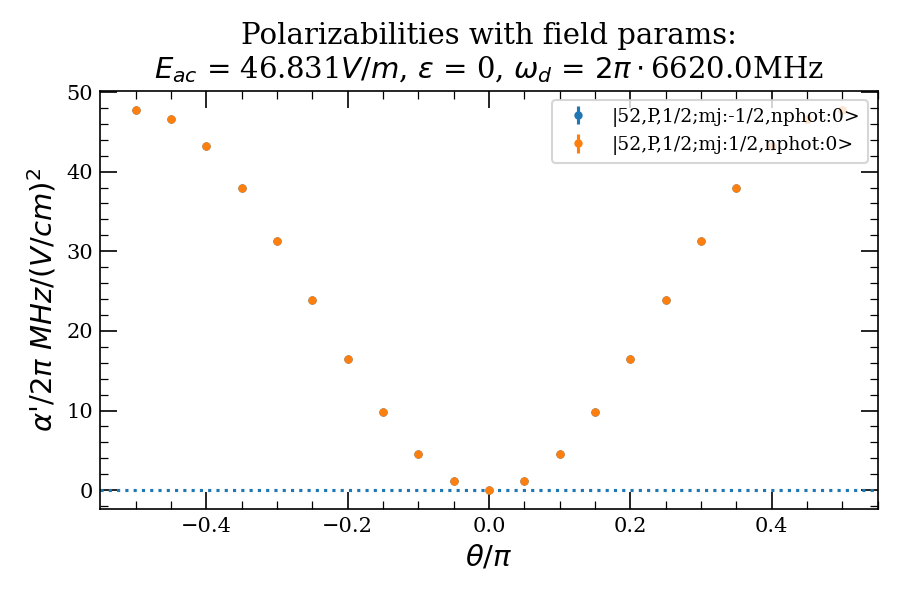

<ipython-input-13-8b3050f25cbe>:4: RuntimeWarning: divide by zero encountered in log10
  x_ac = 20*np.log10(Eacs/scale)


16 |52,P,1/2;mj:-1/2>
17 |52,P,1/2;mj:1/2>


<IPython.core.display.Javascript object>


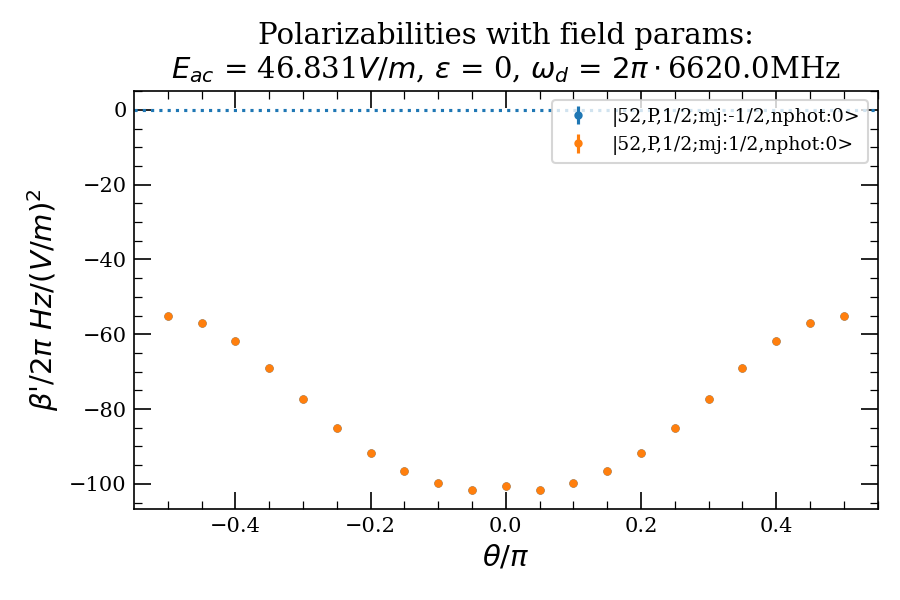

16 |52,P,1/2;mj:-1/2>
17 |52,P,1/2;mj:1/2>


<ipython-input-13-8b3050f25cbe>:45: RuntimeWarning: divide by zero encountered in log10
  x_ac = 20*np.log10(Eacs/scale)


In [13]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
band_c = 0
scale=167
x_ac = 20*np.log10(Eacs/scale)
x_ac = Eacs
for i, state in zip(t_inds,t_states):
    #if state == t_level:  # check n,l,j quantum numbers
    print(i,state.ket())
    k = n_max*len(basis)+i
    band_c +=1
    lab = f"band {band_c}" if energy_bands else basis_n[k].ket()
    if sweep_ac:
        ax.errorbar(x_ac, popts_eac[:,k,1]*1e-2/tau, label=lab,yerr=perrs_eac[:,k,1]*1e-2/tau,fmt=".")
    elif sweep_theta:
        ax.errorbar(thetas/pi, popts_theta2[:,k,1]*1e-3/tau, label=lab,yerr=perrs_theta2[:,k,1]*1e-3/tau,fmt=".")
ax.legend(loc=1,prop={"size":9})
ax.axhline(0,ls=":")
#ax.set_ylim(0,max(np.abs(alphas[0,:]))*1e-3/tau)
#ax.set_yscale("log")
if sweep_ac:
    ax.set_xlabel("AC field strength (V/m)")
    ax.set_title(f"Polarizabilities with field params:\n$\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz, $\\theta$ = {theta/pi}$\cdot\pi$")
elif sweep_theta:
    ax.set_xlabel("$\\theta/\pi$")
    ax.set_title(f"Polarizabilities with field params:\n$E_{{ac}}$ = {Eac}$V/m$, $\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz")
    
ax.set_ylabel("$\\alpha$'/$2\pi$ $MHz/(V/cm)^2$")
#ax.set_ylabel("$\\alpha'/\\alpha$ (%)")
for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    item.set_fontsize(14)

try:
    for erind in err_eacs:
        ax.axvline(erind,ls=":")
except NameError:
    pass
        
fig.tight_layout()
fig.show()
omega_for_humans = int(field_omega*1e-6/tau)
fig.savefig(f"polarizabilities_omegad-{omega_for_humans}MHz_eps_{ellipticity:.3f}-around{Eacs.mean():.0f}Eac.png")
fig, ax = plt.subplots(1,1, figsize=(6,4))
band_c = 0
scale=167
x_ac = 20*np.log10(Eacs/scale)
x_ac = Eacs
for i, state in zip(t_inds,t_states):
    #if state == t_level:  # check n,l,j quantum numbers
    print(i,state.ket())
    k = n_max*len(basis)+i
    band_c +=1
    lab = f"band {band_c}" if energy_bands else basis_n[k].ket()
    if sweep_ac:
        ax.errorbar(x_ac, popts_eac[:,k,3]/tau, label=lab,yerr=perrs_eac[:,k,3]/tau,fmt=".")
    elif sweep_theta:
        ax.errorbar(thetas/pi, popts_theta[:,k,3]/tau, label=lab,yerr=perrs_theta[:,k,3]/tau,fmt=".")
ax.legend(loc=1,prop={"size":9})
ax.axhline(0,ls=":")
#ax.set_ylim(0,max(np.abs(alphas[0,:]))*1e-3/tau)
#ax.set_yscale("log")
if sweep_ac:
    ax.set_xlabel("AC field strength (V/m)")
    ax.set_title(f"Polarizabilities with field params:\n$\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz, $\\theta$ = {theta/pi}$\cdot\pi$")
elif sweep_theta:
    ax.set_xlabel("$\\theta/\pi$")
    ax.set_title(f"Polarizabilities with field params:\n$E_{{ac}}$ = {Eac}$V/m$, $\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz")
    
ax.set_ylabel("$\\alpha$'/$2\pi$ $KHz/(V/m)^2$")
ax.set_ylabel("$\\beta$'/$2\pi$ $Hz/(V/m)^2$")
#ax.set_ylabel("$\\alpha'/\\alpha$ (%)")
for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    item.set_fontsize(14)


fig.tight_layout()
fig.show()
omega_for_humans = int(field_omega*1e-6/tau)
#fig.savefig(f"polarizabilities_omegad-{omega_for_humans}MHz_eps_{ellipticity:.3f}-around{Eacs.mean():.0f}Eac.png")

<IPython.core.display.Javascript object>


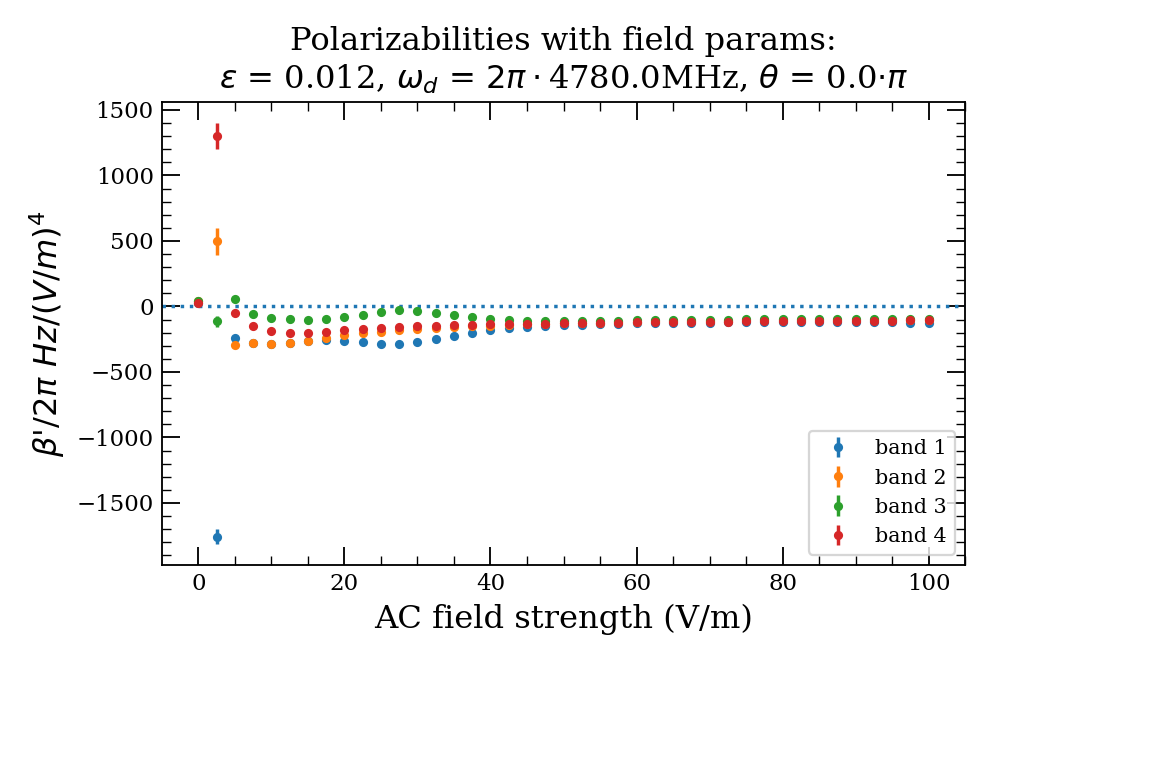

<ipython-input-17-adf5f2240018>:4: RuntimeWarning: divide by zero encountered in log10
  x_ac = 20*np.log10(Eacs/scale)


In [17]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
band_c = 0
scale=167
x_ac = 20*np.log10(Eacs/scale)
x_ac = Eacs
for i, state in enumerate(basis):
    if state == t_level:  # check n,l,j quantum numbers
        band_c +=1
        lab = f"band {band_c}" if energy_bands else basis_n[n_max*len(basis)+i].ket()
        if sweep_ac:
            ax.errorbar(x_ac, popts_eac[:,n_max*len(basis)+i,3]/tau, label=lab,yerr=perrs_eac[:,n_max*len(basis)+i,3]/tau,fmt=".")
        elif sweep_theta:
            ax.errorbar(thetas/pi, popts_theta[:,n_max*len(basis)+i,3]/tau, label=lab,yerr=perrs_theta[:,n_max*len(basis)+i,3]/tau,fmt=".")
ax.legend(loc=4,prop={"size":9})
ax.axhline(0,ls=":")
#ax.set_ylim(0,max(np.abs(alphas[0,:]))*1e-3/tau)
#ax.set_yscale("log")
if sweep_ac:
    ax.set_xlabel("AC field strength (V/m)")
    ax.set_title(f"Polarizabilities with field params:\n$\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz, $\\theta$ = {theta/pi}$\cdot\pi$")
elif sweep_theta:
    ax.set_xlabel("$\\theta/\pi$")
    ax.set_title(f"Polarizabilities with field params:\n$E_{{ac}}$ = {Eac}$V/m$, $\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz")
    
ax.set_ylabel("$\\beta$'/$2\pi$ $Hz/(V/m)^4$")
#ax.set_ylabel("$\\alpha'/\\alpha$ (%)")
for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    item.set_fontsize(14)
    
fig.tight_layout()
fig.show()
omega_for_humans = int(field_omega*1e-6/tau)
fig.savefig(f"polarizabilities_omegad-{omega_for_humans}MHz_eps_{ellipticity:.3f}-around{Eacs.mean():.0f}Eac.png")

### Plot polarizabilities in mid case

In [9]:
fname = scheme
results_dir = r"Shirley-Floquet_results\PolarizabilityPlots\RawData"
try:
    print(popts_eac[0])
except NameError:
    popts_eac = np.load(os.path.join(results_dir,fname+"popts_eac.npy"))
    perrs_eac = np.load(os.path.join(results_dir,fname+"perrs_eac.npy"))
    Eacs = np.load(os.path.join(results_dir,fname+"eac.npy"))
    es0s_eac = np.load(os.path.join(results_dir,fname+"e0s.npy"))
try:
    print(popts_theta[0])
except NameError:
    popts_theta = np.load(os.path.join(results_dir,fname+"popts_theta.npy"))
    perrs_theta = np.load(os.path.join(results_dir,fname+"perrs_theta.npy"))
    thetas = np.load(os.path.join(results_dir,fname+"thetas.npy"))
    es0s_theta = np.load(os.path.join(results_dir,fname+"e0s_theta.npy"))

if scheme == "mid":
    try:
        print(popts_theta2[0])
    except NameError:
        popts_theta2 = np.load(os.path.join(results_dir,fname+"popts_theta2.npy"))
        perrs_theta2 = np.load(os.path.join(results_dir,fname+"perrs_theta2.npy"))
        thetas = np.load(os.path.join(results_dir,fname+"thetas.npy"))
        es0s_theta2 = np.load(os.path.join(results_dir,fname+"e0s_theta2.npy"))

[[-4.89166578e-04  1.72311289e+05 -2.52395141e+11 -4.36778151e-01]
 [ 1.10642548e-03  1.72352840e+05 -2.52395132e+11 -1.39330262e-02]
 [ 0.00000000e+00 -3.93337674e-06 -2.46349061e+11 -1.76089271e-07]
 [-5.40873570e-03  4.70356184e+04 -2.46349050e+11  2.40301608e-01]
 [-3.75668073e-03  8.36051484e+04 -2.46349040e+11 -1.33239350e-01]
 [ 3.85639902e-03  8.36825454e+04 -2.46349032e+11 -2.84148404e-01]
 [ 5.11581921e-03  4.70859322e+04 -2.46349022e+11 -5.10439263e-01]
 [ 0.00000000e+00 -1.62760417e-06 -2.46349011e+11 -5.14306556e-09]
 [ 0.00000000e+00  0.00000000e+00 -2.46349071e+11  0.00000000e+00]
 [ 6.71934240e-03  4.55054072e+04 -2.46349062e+11  1.45842412e-01]
 [-3.02157813e-03  7.34272872e+04 -2.46349050e+11  5.48489879e-01]
 [ 4.45323395e-03  7.44444922e+04 -2.46349042e+11  6.53292604e-01]
 [ 2.74959872e-03  7.44179954e+04 -2.46349032e+11  1.06879740e-02]
 [ 9.73740057e-04  7.34624654e+04 -2.46349021e+11  4.33518779e-01]
 [ 7.38535192e-03  4.55249485e+04 -2.46349012e+11  1.09574666e

FileNotFoundError: [Errno 2] No such file or directory: 'Shirley-Floquet_results\\PolarizabilityPlots\\RawData\\lowpopts_theta.npy'

<IPython.core.display.Javascript object>


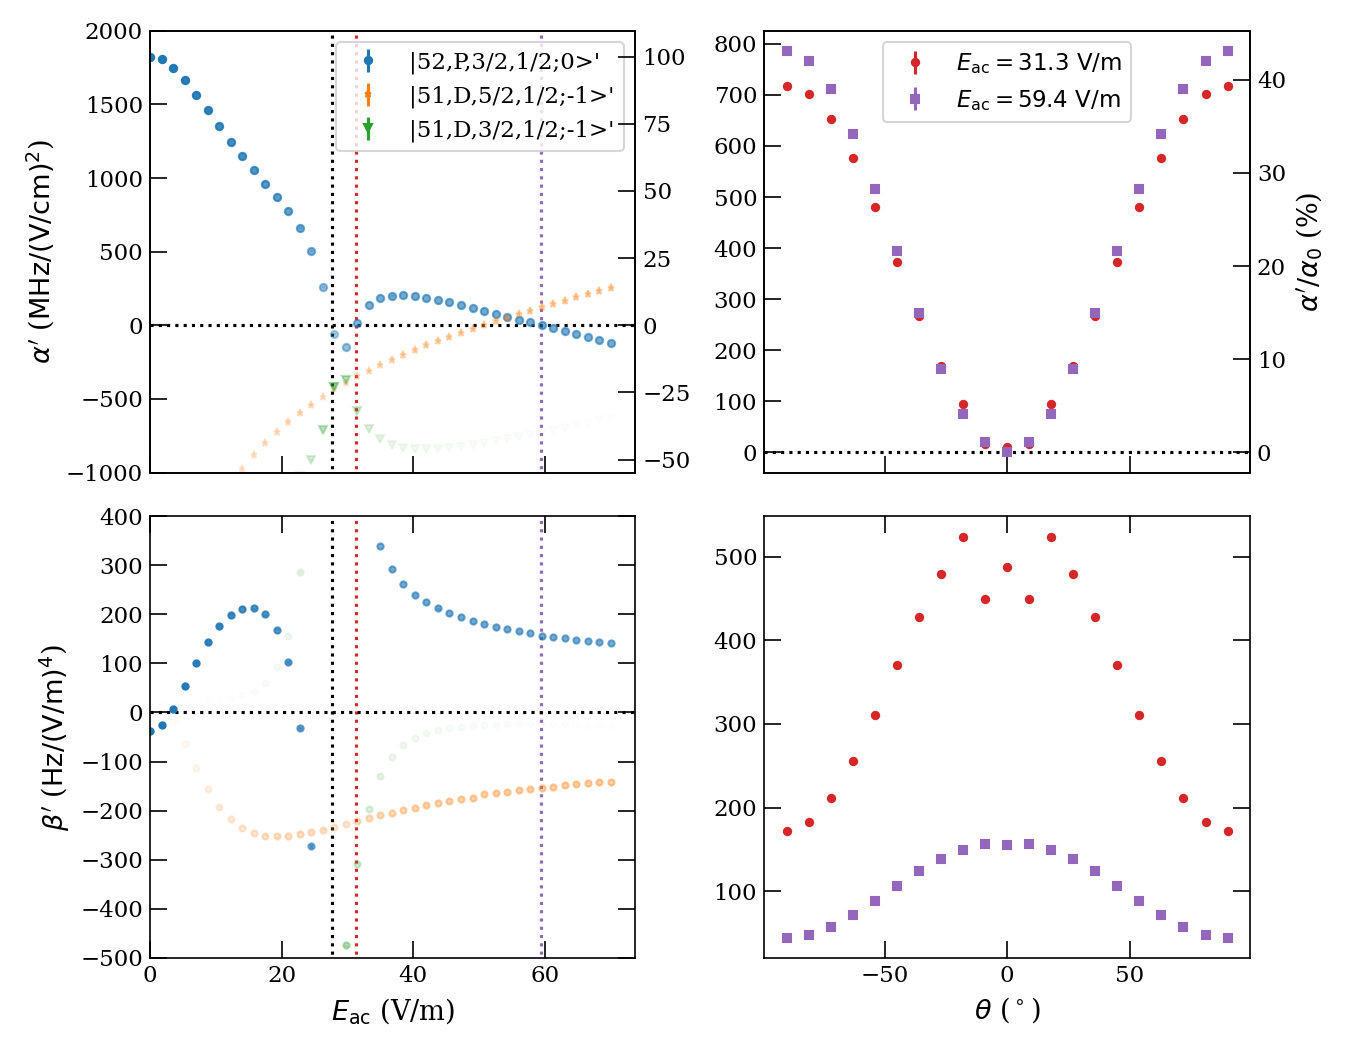

In [21]:
p_inds = [
    i for i in range(len(basis_n)) if all([
        basis_n[i].n == 52,
        basis_n[i].l == 1,
        basis_n[i].j == 3/2,
        basis_n[i]["mj"] in [1/2],
        basis_n[i]["nphot"] == 0        
    ])
]

thrs=0.1
fig,axar = plt.subplots(2,2,figsize=(4.5*2,3.5*2))
count = 0
zero_x = [27.616, 31.346, 59.416]
cv = ["black","tab:blue","tab:orange"]
alpha0 = popts_eac[0,np.array(p_inds)[0],1]*1e-2/tau

ax_fontsize = 13
tick_labelsize = 11
legend_fontsize = 11
markersize = 3.5
markers = "o*vsD^"
linestyles = [':',':', ':', ':']

for i,t in enumerate(p_inds):
    for k in range(len(basis_n))[::-1]:
        if any(np.abs(es0s_eac[:,t,k])**2>thrs):
            color = f"C{count}"
            #color = f"C{i}"
            alphs = np.abs(es0s_eac[:,t,k])**2
            ax=axar[0,0]
            ydat = popts_eac[:,k,1]*1e-2/tau
            yerr = perrs_eac[:,k,1]*1e-2/tau
            ax.set_ylabel("$\\alpha$'/$2\pi$ $kHz/(V/m)^2$")
            for it in range(len(Eacs))[:]:
                kt = basis_n[k]
                ls = {0:"S",1:"P",2:"D",3:"F"}
                lab = f"|{kt.n},{ls[kt.l]},{int(2*kt.j)}/2,{int(2*kt['mj'])}/2;{kt['nphot']}>'"
                lab = "" if (it > 0) else lab
                alph = alphs[it] if (it>0) else 1
                if abs(alphs[it] - alph) > 0.5:
                    xdat = [-5]
                else:
                    xdat = Eacs[it:it+1]
                ax.errorbar(xdat,ydat[it:it+1],yerr=yerr[it:it+1],fmt=markers[count], ms=markersize,c=color,alpha=alph,label=lab)
            #ax.axhline(0,ls=":",c="black")
            #ax.vlines(zero_x,*ax.get_ylim(),linewidth=1,ls=":")
            
            ax=axar[1,0]
            ydat = -popts_eac[:,k,3]/tau
            yerr = perrs_eac[:,k,3]/tau
            ax.set_ylabel("$\\beta'$ ($\\rm Hz/(V/m)^4$)")
            for it in range(len(Eacs))[:]:
                kt = basis_n[k]
                ls = {0:"S",1:"P",2:"D",3:"F"}
                lab = f"|{kt.n},{ls[kt.l]},{int(2*kt.j)}/2,{int(2*kt['mj'])}/2,m={kt['nphot']}>'"
                lab = "" if (it > 0) else lab
                alph = alphs[it] if (it>0) else 1
                if abs(alphs[it] - alph) > 0.5:
                    xdat = [-5]
                else:
                    xdat = Eacs[it:it+1]
                ax.errorbar(xdat,ydat[it:it+1],yerr=yerr[it:it+1],fmt="os"[i], ms=3,c=color,alpha=alph,label=lab)
            lm = ax.get_ylim()
            #ax.vlines(zero_x,*ax.get_ylim(),linewidth=1,ls=":")
            #ax.set_ylim(*lm)
            #ax.axhline(0,ls=":",c="black")            
            count+=1
            
t = p_inds[0]
x_data = thetas/pi*180

y_data = popts_theta[:,t,1]*1e-2/tau
y_err = perrs_theta[:,t,1]*1e-2/tau
axar[0,1].errorbar(x_data,y_data,yerr=y_err, fmt=markers[0],label=f"$E_{{\\rm ac}}={zero_x[1]:.1f} ~\\rm V/m$",c="C3",ms=markersize)
y_data = -popts_theta[:,t,3]/tau
y_err = perrs_theta[:,t,3]/tau
axar[1,1].errorbar(x_data,y_data,yerr=y_err, fmt=markers[0],label=f"$E_{{\\rm ac}}={zero_x[1]:.1f} ~\\rm V/m$",c="C3",ms=markersize)

y_data = popts_theta2[:,t,1]*1e-2/tau
y_err = perrs_theta2[:,t,1]*1e-2/tau
axar[0,1].errorbar(x_data,y_data,yerr=y_err, fmt=markers[3],label=f"$E_{{\\rm ac}}={zero_x[2]:.1f} ~\\rm V/m$",c="C4",ms=markersize)
y_data = -popts_theta2[:,t,3]/tau
y_err = perrs_theta2[:,t,3]/tau
axar[1,1].errorbar(x_data,y_data,yerr=y_err, fmt=markers[3],label=f"$E_{{\\rm ac}}={zero_x[2]:.1f} ~\\rm V/m$",c="C4",ms=markersize)
#axar[1,1].set_ylabel("$\\beta$'/$2\pi$ $Hz/(V/m)^4$")

ax = axar[0,1]
ax.axhline(0,c="black",ls=":")
axar[0,1].legend(prop={"size":legend_fontsize})

for ax in axar[:,0]:
    cv = ["black","tab:blue","tab:orange"]
    lm = ax.get_ylim()
    ax.vlines(zero_x,*ax.get_ylim(),linewidth=1.5,ls=linestyles,colors=["k","C3","C4"])
    ax.set_ylim(*lm)
    ax.axhline(0,ls=":",c="black")            
    
axar[0,0].set_xlim(0,axar[0,0].get_xlim()[1])
axar[0,0].get_shared_x_axes().join(axar[0,0], axar[1,0])
axar[0,0].set_xticklabels([])
axar[1,0].set_xlim(axar[0,0].get_xlim())
axar[1,0].set_xlabel("$E_{\\rm ac}$ (V/m)")

#axar[0,1].set_xlim(0,axar[0,0].get_xlim()[1])
axar[0,1].get_shared_x_axes().join(axar[0,1], axar[1,1])
axar[0,1].set_xticklabels([])
axar[1,1].set_xlim(axar[0,1].get_xlim())
axar[1,1].set_xlabel("$\\theta$ ($^\circ$)")
axar[0,0].set_ylabel("$\\alpha'$ ($\\rm MHz/(V/cm)^2$)")

#axar[0,0].axhline(alpha0,ls=":")
#axar[0,1].axhline(alpha0*0.2,ls=":")
axar[0,0].set_ylim(-1000,2000)

for ax in axar[0,:]:
    #ax.set_ylabel("$-\\alpha'$ $(KHz/(V/m)^2)$")
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    #ax.axhline(-alpha0*1e-3/tau)
    ax2 = ax.twinx()
    #for k in basis_t:
    #    ax2.plot(x_ac,100*popts_eac[:,n_max*len(basis)+k,1]/alpha0)
    low,high = ax.get_ylim()
    #ax2.set_ylim(-100*low/(alpha0*1e-3/tau),-100*high/(alpha0*1e-3/tau))
    if ax == axar[0,1]:
        #ax.axhline(alpha0*0.2)
        ax2.set_yticks(np.arange(-50,60,10))
        ax2.set_ylim(100*low/(alpha0),100*high/(alpha0))
        ax2.set_ylabel("$\\alpha'/\\alpha_0$ (%)")
    else:
        #ax.axhline(alpha0)
        ax2.set_yticks(np.arange(-200,150,25))
        ax2.set_ylim(100*low/(alpha0),100*high/(alpha0))

    ax.tick_params(labelsize=tick_labelsize)
    ax2.tick_params(labelsize=tick_labelsize)
    for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
        item.set_fontsize(ax_fontsize)    
    for item in [ax2.xaxis.label, ax2.yaxis.label, ax2.title]:
        item.set_fontsize(ax_fontsize)  
    ax.minorticks_off()
    ax2.minorticks_off()
for ax in axar[1,:]:
    ax.tick_params(labelsize=tick_labelsize)
    ax2.tick_params(labelsize=tick_labelsize)
    for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
        item.set_fontsize(ax_fontsize)    
    for item in [ax2.xaxis.label, ax2.yaxis.label, ax2.title]:
        item.set_fontsize(ax_fontsize)
    ax.minorticks_off()
    ax2.minorticks_off()
axar[1,0].set_ylim(-500,400)
axar[0,0].legend(prop={"size":legend_fontsize})
#axar[1,0].legend(prop={"size":8})
fig.tight_layout()
fig.show()
#fig.savefig(os.path.join(plots_dir,"MidDetuning.png"))
#fig.savefig(os.path.join(plots_dir,"MidDetuning.eps"))
zfigs_dir = r"Z:\Public\Hybrid\Publications\Dressing in Cryostat\figures_TODO"
fig.savefig(os.path.join(zfigs_dir,"MidDetuning.png"))

In [8]:
p_inds

[116, 117]

In [54]:
p_inds = [
    i for i in range(len(basis_n)) if all([
        basis_n[i].n == 52,
        basis_n[i].l == 1,
        basis_n[i].j == 3/2,
        basis_n[i]["mj"] in [1/2,3/2],
        basis_n[i]["nphot"] == 0        
    ])
]
print(p_inds)
basis_print([basis_n[i] for i in p_inds])

[116, 117]
[
	|52,P,3/2;mj:1/2,nphot:0>,
	|52,P,3/2;mj:3/2,nphot:0>
]


### find and plot zero-crossings
#### mid case

<IPython.core.display.Javascript object>


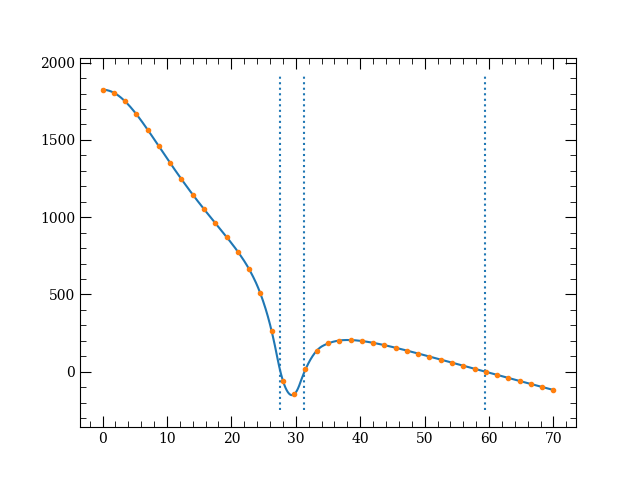

In [45]:
k = t_inds[1]+len(basis)*n_max
fun = interp1d(Eacs,popts_eac[:,k,1]*1e-2/tau,kind="quadratic")
xlin=np.linspace(min(Eacs),max(Eacs),50000)
fig,ax=plt.subplots(1,1)
ax.plot(xlin,fun(xlin))
ax.errorbar(x_ac, popts_eac[:,k,1]*1e-2/tau,yerr=perrs_eac[:,k,1]*1e-2/tau,fmt=".")

zerx = xlin[np.argwhere(np.abs(fun(xlin))<1e-1)][:,0]
zerx[2:].mean()
zero_x = [zerx[0],zerx[1:3].mean(),zerx[3:].mean()]

ax.vlines(zero_x,*ax.get_ylim(),ls = ":")
fig.show()

#zero_x = [27.20,30.55,zerx[2:].mean()]

In [49]:
zero_x

[27.615552311046223, 31.34592691853837, 59.415788315766314]

In [43]:
zero_x = [27.616, 31.346, 59.416]

array([59.40738815, 59.40878818, 59.4101882 , 59.41158823, 59.41298826,
       59.41438829, 59.41578832, 59.41718834, 59.41858837, 59.4199884 ,
       59.42138843, 59.42278846, 59.42418848])

#### simple cases

<IPython.core.display.Javascript object>


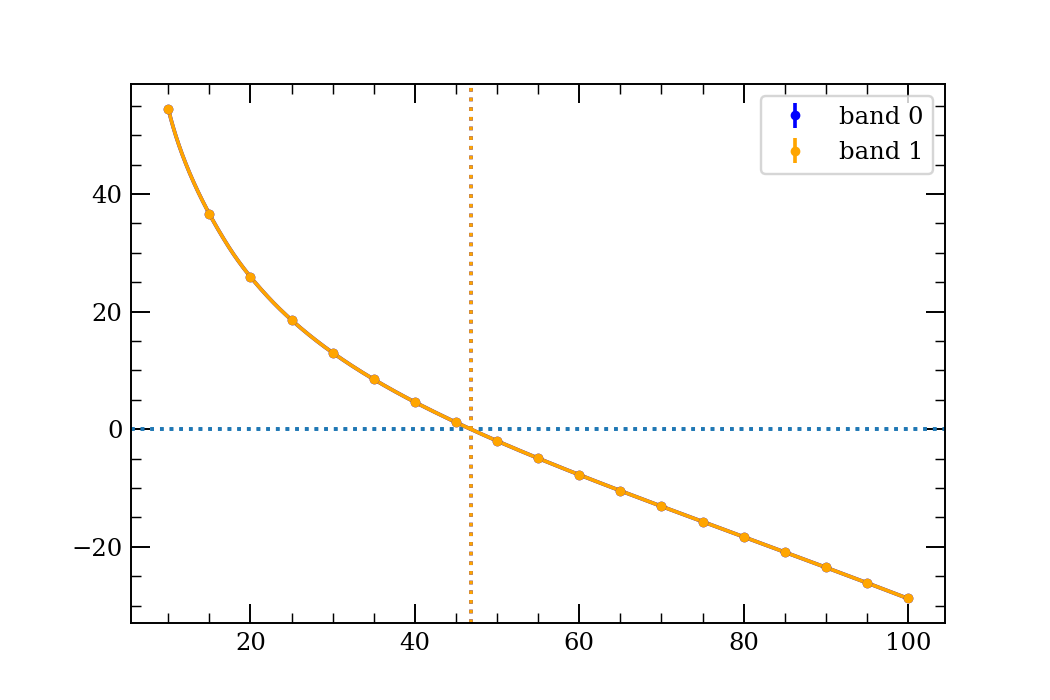

band 0 zero-crossing at Eac = 46.830693717750044 V/m
band 1 zero-crossing at Eac = 46.83090793269037 V/m


<ipython-input-94-8aca5ac183c5>:4: RuntimeWarning: divide by zero encountered in log10
  x_ac = 20*np.log10(Eacs/scale)


In [94]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
band_c = 0
scale=167
x_ac = 20*np.log10(Eacs/scale)
x_ac = Eacs

basis_t = np.array([i+len(basis)*n_max for i, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]])
colors = ["blue","orange","green","red"]
for i,k in enumerate(basis_t):
    x_dat = Eacs[2:]
    y_dat = 1e-3*popts_eac[2:,k,1]/tau
    y_err = 1e-3*perrs_eac[2:,k,1]/tau
    good_inds = np.argwhere(np.invert(np.isnan(y_dat)))[:,0]
    y_dat = y_dat[good_inds]
    y_err = y_err[good_inds]
    x_dat = x_dat[good_inds]
    
#    y_dat[1]=np.NaN
#    y_err[1]=np.NaN
    
    ax.errorbar(x_dat,y_dat,yerr=y_err,fmt=".",c=colors[i],label=f"band {i}")
    ax.axhline(0,ls=":")
    cal_fun = interp1d(y_dat,x_dat,kind="quadratic")
    xlin=np.linspace(min(y_dat),max(y_dat),1000)
    ax.plot(cal_fun(xlin),xlin,colors[i])
    #zerox = np.interp(0,y_dat,x_dat)
    print(f"band {i} zero-crossing at Eac = {cal_fun(0)} V/m")
    ax.axvline(cal_fun(0),ls=":",c=colors[i])
ax.legend()
fig.show()

<IPython.core.display.Javascript object>


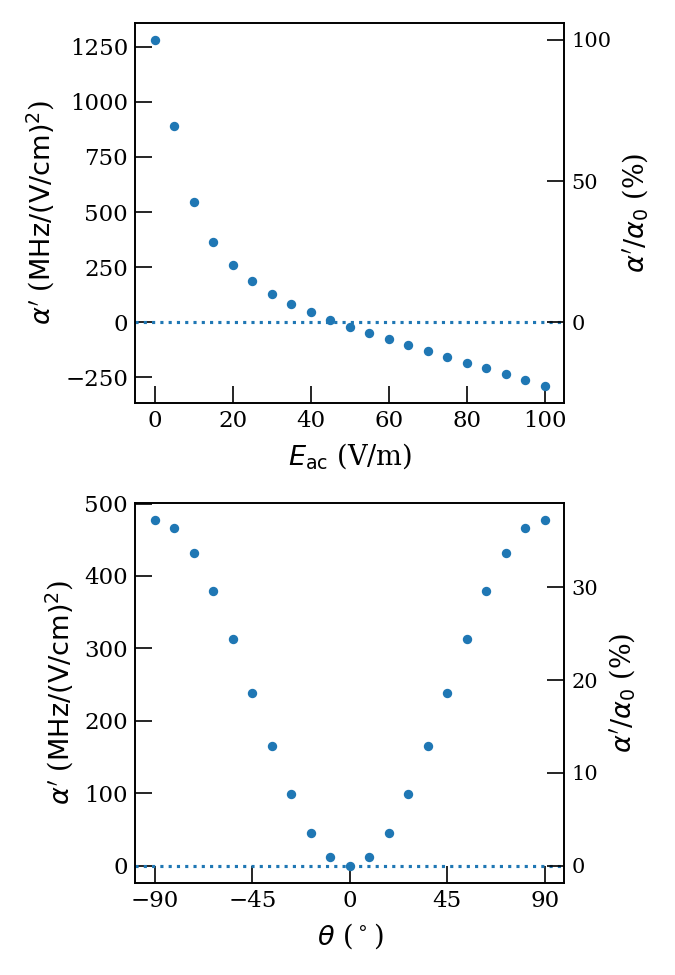

In [15]:
fig, axar = plt.subplots(2,1, figsize=(4.5,6.5))
band_c = 0
scale=167
# convert from SI
si_conv = 1e-2/tau
#x_ac = 20*np.log10(Eacs/scale)
x_ac = Eacs
basis_t = np.array([i+len(basis)*n_max for i, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]])

ax_fontsize = 13
tick_labelsize = 11
legend_fontsize = 10
markersize = 3.5
markers = "o^sD"

alpha0 = popts_eac[0,n_max*len(basis)+basis_t,1].mean()
for i, state in enumerate(basis):
    if scheme != "red" and state["mj"] < 0:
        continue
    if state == t_level:  # check n,l,j quantum numbers
        band_c +=1
        lab = f"band {band_c}" if energy_bands else basis_n[n_max*len(basis)+i].ket()
        #lab=""
        axar[0].errorbar(x_ac, popts_eac[:,n_max*len(basis)+i,1]*si_conv, label=lab,yerr=perrs_eac[:,n_max*len(basis)+i,1]*si_conv,fmt=markers[band_c-1],markersize=markersize)
        axar[1].errorbar(thetas/pi*180, popts_theta[:,n_max*len(basis)+i,1]*si_conv, label=lab,yerr=perrs_theta[:,n_max*len(basis)+i,1]*si_conv,fmt=markers[band_c-1],markersize=markersize)
if scheme == "low":
    pass
else:
    axar[0].legend(loc=1,prop={"size":legend_fontsize})
#axar[1].legend(loc="upper center",prop={"size":legend_fontsize})
axar[0].axhline(0,ls=":")
axar[1].axhline(0,ls=":")
#ax.set_ylim(0,max(np.abs(alphas[0,:]))*1e-3/tau)
#ax.set_yscale("log")
axar[0].set_xlabel("$E_{\\rm ac}$ (V/m)")
axar[1].set_xlabel("$\\theta$ ($^\circ$)")
axar[1].set_xticks(np.arange(-90,114,45))

y_vals = popts_eac[:,n_max*len(basis)+basis_t,1]*1e-3
#axar[0].set_yticks(np.arange(-500,2000,500))
y_vals = popts_theta[:,n_max*len(basis)+basis_t,1]*1e-3
#axar[1].set_yticks(np.arange(-0,600,100))
#axar[0].axvline(zerox,ls=":",c="tab:blue")

#axar[0].set_ylim(-50,150)
#axar[1].set_ylim(-5,50)

for ax in axar:
    # ax.set_ylabel("$\\alpha$'/$2\pi$ $KHz/(V/m)^2$")
    ax.set_ylabel("$\\alpha'$ ($\\rm MHz/(V/cm)^2$)")
    #ax.set_ylabel("$-\\alpha'$ $(KHz/(V/m)^2)$")
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    #ax.axhline(-alpha0*1e-3/tau)
    ax2 = ax.twinx()
    #for k in basis_t:
    #    ax2.plot(x_ac,100*popts_eac[:,n_max*len(basis)+k,1]/alpha0)
    low,high = ax.get_ylim()
    #ax2.set_ylim(-100*low/(alpha0*1e-3/tau),-100*high/(alpha0*1e-3/tau))
    if ax == axar[0]:
        #ax.axhline(alpha0*si_conv)
        ax2.set_yticks(np.arange(-50,150,50))
        ax2.set_ylim(100*low/(alpha0*si_conv),100*high/(alpha0*si_conv))
    elif ax == axar[1]:
        #ax.axhline(0.3*alpha0*si_conv)
        ax2.set_yticks(np.arange(0,60,10))
        ax2.set_ylim(100*low/(alpha0*si_conv),100*high/(alpha0*si_conv))
    ax2.set_ylabel("$\\alpha'/\\alpha_0$ (%)")
    
    for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
        item.set_fontsize(ax_fontsize)    
    for item in [ax2.xaxis.label, ax2.yaxis.label, ax2.title]:
        item.set_fontsize(ax_fontsize)
    ax.tick_params(labelsize=tick_labelsize)
    ax.tick_params(labelsize=tick_labelsize)
    ax.minorticks_off()
    ax2.minorticks_off()
    
#axar[1].set_yticks(np.arange(0,75,25))
    
fig.tight_layout()
fig.show()
omega_for_humans = int(field_omega*1e-6/tau)
fig.savefig(os.path.join(zfigs_dir,f"{scheme}-PolarizabilityAnisotropy_TwoAxes.png"))
#fig.savefig(os.path.join(plots_dir,f"{scheme}-PolarizabilityAnisotropy_TwoAxes.png"))
#fig.savefig(os.path.join(plots_dir,f"{scheme}-PolarizabilityAnisotropy_TwoAxes.eps"))

#fig.savefig(f"polarizabilities_omegad-{omega_for_humans}MHz_eps_{ellipticity:.3f}-around{Eacs.mean():.0f}Eac.png")

In [16]:
zfigs_dir = r"Z:\Public\Hybrid\Publications\Dressing in Cryostat\figures_TODO"
fig.savefig(os.path.join(zfigs_dir,f"{scheme}-PolarizabilityAnisotropy_TwoAxes.png"))

In [101]:
alpha0*si_conv

1281.1304343355134

<IPython.core.display.Javascript object>


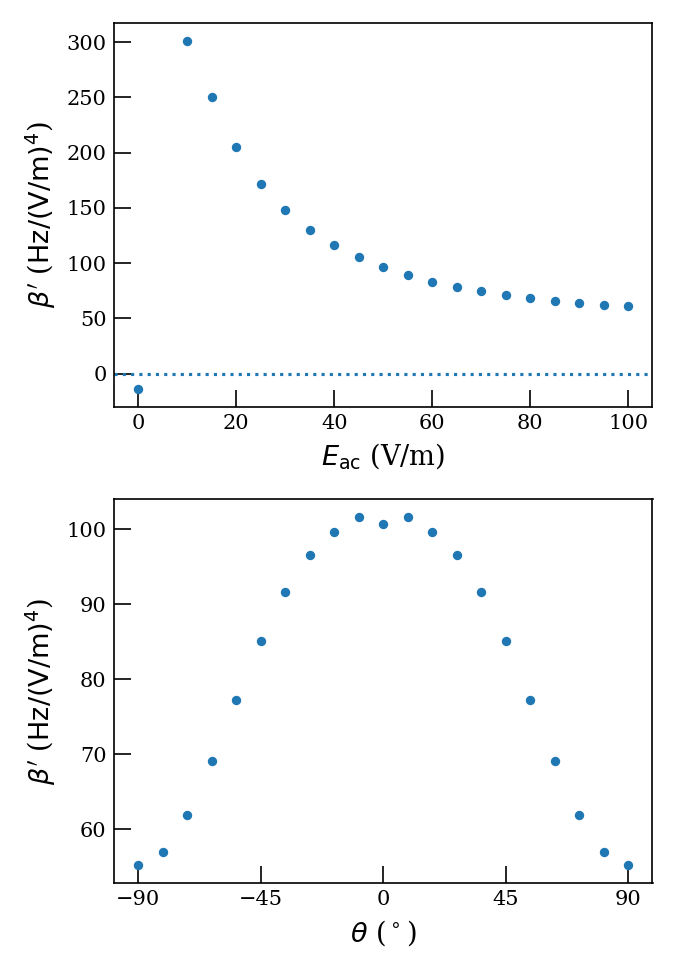

<ipython-input-17-b50b44a56cc3>:4: RuntimeWarning: divide by zero encountered in log10
  x_ac = 20*np.log10(Eacs/scale)


In [17]:
fig, axar = plt.subplots(2,1, figsize=(4.5,6.5))
band_c = 0
scale=167
x_ac = 20*np.log10(Eacs/scale)
x_ac = Eacs

ax_fontsize = 13
tick_labelsize = 11
legend_fontsize = 10
markersize = 3.5
markers = "o^sD"

basis_t = np.array([i+len(basis)*n_max for i, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]])
alpha0 = popts_eac[0,n_max*len(basis)+basis_t,1].mean()
popts_eac[1,:] = np.NaN
for i, state in enumerate(basis):
    if scheme != "red" and state["mj"] < 0:
        continue
    if state == t_level:  # check n,l,j quantum numbers
        band_c +=1
        lab = f"band {band_c}" if energy_bands else basis_n[n_max*len(basis)+i].ket()
        #lab = ""
        axar[0].errorbar(x_ac, -popts_eac[:,n_max*len(basis)+i,3]/tau, label=lab,yerr=perrs_eac[:,n_max*len(basis)+i,3]/tau,fmt=markers[band_c-1],markersize=markersize)
        axar[1].errorbar(thetas/pi*180, -popts_theta[:,n_max*len(basis)+i,3]/tau, label=lab,yerr=perrs_theta[:,n_max*len(basis)+i,3]/tau,fmt=markers[band_c-1],markersize=markersize)
if scheme != "low":
        axar[0].legend(loc=4,prop={"size":legend_fontsize})
#axar[1].legend(loc="upper center",prop={"size":legend_fontsize})
axar[0].axhline(0,ls=":")
#axar[1].axhline(0,ls=":")
#ax.set_ylim(0,max(np.abs(alphas[0,:]))*1e-3/tau)
#ax.set_yscale("log")
axar[0].set_xlabel("$E_{\\rm ac}$ (V/m)")
axar[1].set_xlabel("$\\theta$ ($^\circ$)")
axar[1].set_xticks(np.arange(-90,114,45))
#axar[0].set_ylim(-60,210)
#axar[1].set_ylim(-30,100)
#axar[0].axvline(zerox,ls=":",c="tab:blue")


for ax in axar:
    # ax.set_ylabel("$\\alpha$'/$2\pi$ $KHz/(V/m)^2$")
    ax.set_ylabel("$\\beta'$ ($\\rm Hz/(V/m)^4$)")
    #ax.set_ylabel("$-\\alpha'$ $(KHz/(V/m)^2)$")
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    low,high = ax.get_ylim()
    for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
        item.set_fontsize(ax_fontsize)    
    ax.minorticks_off()
    
    
    
y_vals = popts_eac[:,n_max*len(basis)+basis_t,1]*1e-3
#axar[0].set_yticks(np.linspace(-50,200,6))
y_vals = popts_theta[:,n_max*len(basis)+basis_t,1]*1e-3
#axar[1].set_yticks(np.linspace(-25,100,6))
#axar[1].set_yticks(np.arange(0,75,25))
    
fig.tight_layout()
fig.show()
omega_for_humans = int(field_omega*1e-6/tau)

fig.savefig(f"Shirley-Floquet_results/{scheme}-HyperPolarizabilityAnisotropy_TwoAxes.png")
fig.savefig(f"Shirley-Floquet_results/{scheme}-HyperPolarizabilityAnisotropy_TwoAxes.eps")

fig.savefig(os.path.join(zfigs_dir,f"{scheme}-HyperPolarizabilityAnisotropy_TwoAxes.png"))
#fig.savefig(f"AvoidedX-PolarizabilityAnisotropy_TwoAxes.png")
#fig.savefig(f"polarizabilities_omegad-{omega_for_humans}MHz_eps_{ellipticity:.3f}-around{Eacs.mean():.0f}Eac.png")

In [ ]:
results_dir = r"Shirley-Floquet_results\PolarizabilityPlots"
#np.save(os.path.join(results_dir,"popts_eac.npy"),popts_eac)
#np.save(os.path.join(results_dir,"perrs_eac.npy"),perrs_eac)
#np.save(os.path.join(results_dir,"popts_theta.npy"),popts_theta)
#np.save(os.path.join(results_dir,"perrs_theta.npy"),perrs_theta)

In [ ]:
Eacs = np.linspace(0,100,21)
thetas = np.linspace(-pi/2,pi/2,21)
popts_eac = np.load(os.path.join(results_dir,"popts_eac.npy"))
perrs_eac = np.load(os.path.join(results_dir,"perrs_eac.npy"))
popts_theta = np.load(os.path.join(results_dir,"popts_theta.npy"))
perrs_theta = np.load(os.path.join(results_dir,"perrs_theta.npy"))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4.5,4))
band_c = 0
for i, state in enumerate(basis):
    if state == t_level:  # check n,l,j quantum numbers
        band_c +=1
        lab = f"band {band_c}" if energy_bands else basis_n[n_max*len(basis)+i].ket()
        if sweep_ac:
            ax.errorbar(Eacs, popts_eac[:,n_max*len(basis)+i,3]/tau, label=lab,yerr=perrs_eac[:,n_max*len(basis)+i,3]/tau,fmt=".")
        elif sweep_theta:
            ax.errorbar(180*thetas/pi, popts_theta[:,n_max*len(basis)+i,3]/tau, label=lab,yerr=perrs[:,n_max*len(basis)+i,3]/tau,fmt=".")
ax.legend(loc=3,prop={"size":9})
ax.axhline(0,ls=":")
#ax.set_ylim(0,max(np.abs(alphas[0,:]))*1e-3/tau)
#ax.set_yscale("log")
if sweep_ac:
    ax.set_xlabel("AC field strength (V/m)")
   # ax.set_title(f"Polarizabilities with field params:\n$\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz, $\\theta$ = {theta/pi}$\cdot\pi$")
elif sweep_theta:
    ax.set_xlabel("$\\theta$ (Degrees)")
   # ax.set_title(f"Polarizabilities with field params:\n$E_{{ac}}$ = {Eac}$V/m$, $\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz")
    
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("$\\beta$ $(Hz/(V/m)^4)$")
for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    item.set_fontsize(12)
    
fig.tight_layout()
fig.show()
omega_for_humans = int(field_omega*1e-6/tau)
fig.savefig(r"Plots/beta_theta")

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
band_c = 0
for i, state in enumerate(basis):
    if state == t_level:  # check n,l,j quantum numbers
        band_c +=1
        lab = t_level.ket()+f"band {band_c}" if energy_bands else basis_n[n_max*len(basis)+i].ket()
        if sweep_ac:
            ax.plot(Eacs, perrs[:,n_max*len(basis)+i,3], label=lab)
        elif sweep_theta:
            ax.errorbar(thetas/pi, 100*popts[:,n_max*len(basis)+i,3]*1e-3/tau, label=lab,yerr=perrs[:,n_max*len(basis)+i,3]*1e-3/tau,fmt=".")
ax.legend(loc=1,prop={"size":9})
ax.axhline(0,ls=":")
#ax.set_ylim(0,max(np.abs(alphas[0,:]))*1e-3/tau)
#ax.set_yscale("log")
if sweep_ac:
    ax.set_xlabel("AC field strength (V/m)")
    ax.set_title(f"Polarizabilities with field params:\n$\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz, $\\theta$ = {theta/pi}$\cdot\pi$")
elif sweep_theta:
    ax.set_xlabel("$\\theta/\pi$")
    ax.set_title(f"Polarizabilities with field params:\n$E_{{ac}}$ = {Eac}$V/m$, $\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz")
    
ax.set_ylabel("$\\alpha$'/$2\pi$ $KHz/(V/m)^2$")
ax.set_ylabel("$\\beta (KHz/V^4)$")
ax.set_yscale("log")
for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    item.set_fontsize(14)
    
fig.tight_layout()
fig.show()
omega_for_humans = int(field_omega*1e-6/tau)
fig.savefig(f"polarizabilities_omegad-{omega_for_humans}MHz_eps_{ellipticity:.3f}-around{Eacs.mean():.0f}Eac.png")

# Plot_1Ds
## plot all relevant Energies and one overlap

<IPython.core.display.Javascript object>


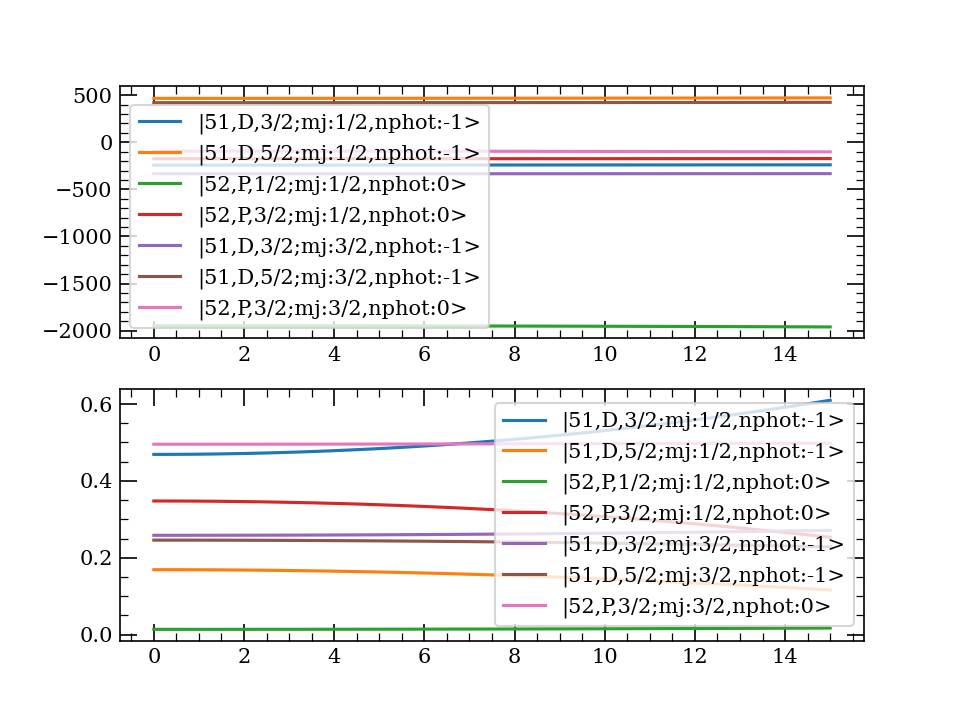

In [8]:
fig,axar = plt.subplots(2,1)
for t in t_inds:
    k = t + n_max*len(basis)
    if basis_n[k]["mj"]<0:
        continue
    label = basis_n[t].ket()

    for j in range(len(basis_n)):
        label = basis_n[j].ket()
        if any(np.abs(eigenstates[k,j,:])**2 > 1e-2):
            ax=axar[0]
            ax.plot(varied[1],1e-6*energies[j,:]/tau,label=label)
            ax=axar[1]        
            ax.plot(varied[1],np.abs(eigenstates[k,j,:])**2,label=label)

#    ax.set_yscale("log")
for ax in axar:
    ax.legend()
fig.show()

<IPython.core.display.Javascript object>


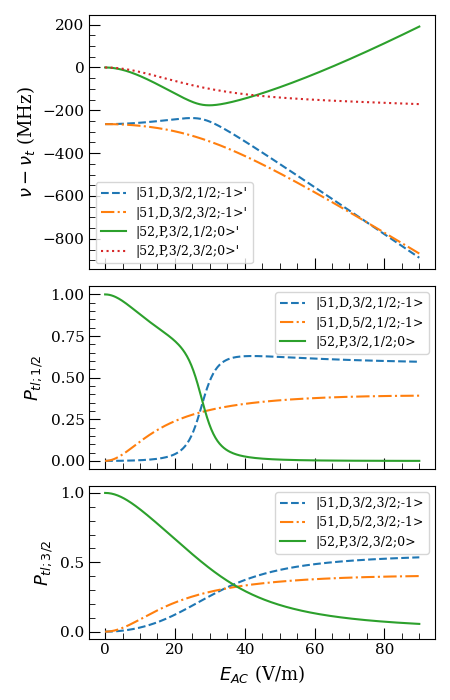

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
thrs = 0.2# threshold for caring about population
thrs2 = 0.5
fig,axar = plt.subplots(3,1,figsize=(4.5,7),gridspec_kw={'height_ratios': [2.5, 1.8, 1.5]})
iis = []
interesting_inds = []
e_inds = []

ax_fontsize = 13
tick_labelsize = 11
legend_fontsize = 9
markersize = 3.5
markers = "o^sD"
linestyles = ['--', '-.', '-', ':']


for i, state in enumerate(basis):
#    if [state.n,state.l,state.j,state["mj"]] == [t_level.n, t_level.l, t_level.j,3/2]:
    if [state.n,state.l,state.j] == [t_level.n, t_level.l, t_level.j]:
        iis.append(i+len(basis)*n_max)
for ii in iis:
    for k, p in enumerate(eigenstates[:,ii,:]):
        if max(np.absolute(p)**2)>thrs:
            interesting_inds.append(k)
        if max(np.absolute(p)**2)>thrs2:
            e_inds.append(k)
interesting_inds = list(set(interesting_inds))
j,jj,jjj = 0,0,0
for k in interesting_inds:
    kt = basis_n[k]
    ls = {0:"S",1:"P",2:"D",3:"F"}
    lab = f"|{kt.n},{ls[kt.l]},{int(2*kt.j)}/2,{int(2*kt['mj'])}/2;{kt['nphot']}>"
    if basis_n[k]["mj"] < 0:
        continue
    if theta_list is None:
        if basis_n[k]["mj"] is not None:
            if k in e_inds:
                axar[0].plot(varied[1], 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau, ls=linestyles[j],label=lab+"\'")
                j += 1
            y_st = np.absolute(eigenstates[k,ii-1,:])**2
            if any(y_st > thrs):
                axar[1].plot(varied[1], y_st, ls=linestyles[jj],label=lab)
                jj +=1
            y_st = np.absolute(eigenstates[k,ii,:])**2
            if any(y_st > thrs):
                axar[2].plot(varied[1], y_st, ls=linestyles[jjj],label=lab)
                jjj += 1
        else:
            axar[0].plot(varied[1], 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau) #, label=basis_n[k].ket())
            axar[1].plot(varied[1], np.absolute(eigenstates[k,ii-1,:])**2) # , label=basis_n[k].ket())

    else:
        if basis_n[k]["mj"] is not None:
            axar[0].plot(varied[1]/pi, 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau, label=basis_n[k].ket())
            axar[1].plot(varied[1]/pi, np.absolute(eigenstates[k,ii,:])**2, label=basis_n[k].ket())
        else:
            axar[0].plot(varied[1]/pi, 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau) #, label=basis_n[k].ket())
            axar[1].plot(varied[1]/pi, np.absolute(eigenstates[k,ii,:])**2)# , label=basis_n[k].ket())            
    #print(f"state = {basis[k%len(basis)].ket()}, dE = 2pix{1e-6*np.real(Energies[k,-1]-Energies[k,0])/tau}MHz")
#axar[0].set_title("Change in Stark Shifts\n$E_{ac}$ = "+f"{Eac}V/m\n" + "$E_{dc}$ = " + f"{Edc}V/m")
#axar[0].set_ylim(-1.05e3,300)
#axar[1].set_title(f"Overlap with {basis_n[ii-1].ket()}")
#axar[1].set_yscale("log")
axar[1].set_ylabel("$P_{tl;1/2}$")
axar[2].set_ylabel("$P_{tl;3/2}$")
#axar[1].set_ylim(thrs*0.8,1)
if Edc_list is not None:
    axar[0].set_ylabel("DC Stark Shift/$2\pi$ (MHz)")
    axar[0].set_xlabel("DC Electric Field strength (V/m)")
    axar[1].set_xlabel("DC Electric Field strength (V/m)")
elif Eac_list is not None:
    #axar[0].set_title(f"Energy Levels\n$\omega_D = 2\pi\cdot{1e-6*field_omega/tau:.0f}$; $\epsilon$ = {ellipticity}")#"\n $E_{{dc}}$ = {Edc}V/m")
    axar[0].set_ylabel("$\\nu-\\nu_t$ (MHz)")
    #axar[0].set_xlabel("$E_{AC}$ (V/m)")
    axar[2].set_xlabel("$E_{AC}$ (V/m)")
elif theta_list is not None:
    #axar[0].set_ylabel("Change in DC Stark Shift/$2\pi$ (MHz)")
    axar[0].set_xlabel("$\\theta/\pi$ (radians)")
    axar[1].set_xlabel("Angle Between AC and DC fields/$\pi$/ (radians)")
axar[0].legend(loc=3,prop={"size":legend_fontsize})
axar[1].legend(loc=1,prop={"size":legend_fontsize})
axar[2].legend(loc=1,prop={"size":legend_fontsize})

axar[0].get_shared_x_axes().join(axar[0], axar[1])
axar[0].get_shared_x_axes().join(axar[1], axar[2])
axar[0].set_xticklabels([])
axar[1].set_xticklabels([])
axar[2].set_xlim(axar[0].get_xlim())

for ax in axar:
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.tick_params(labelsize=tick_labelsize)
    for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
        item.set_fontsize(ax_fontsize)
#axar[1].legend()


fig.tight_layout()
#fig.savefig("Shirley-Floquet_results/AvoidedXEac.png")
#fig.savefig("Shirley-Floquet_results/AvoidedXEac.eps")
fig.show()

<IPython.core.display.Javascript object>


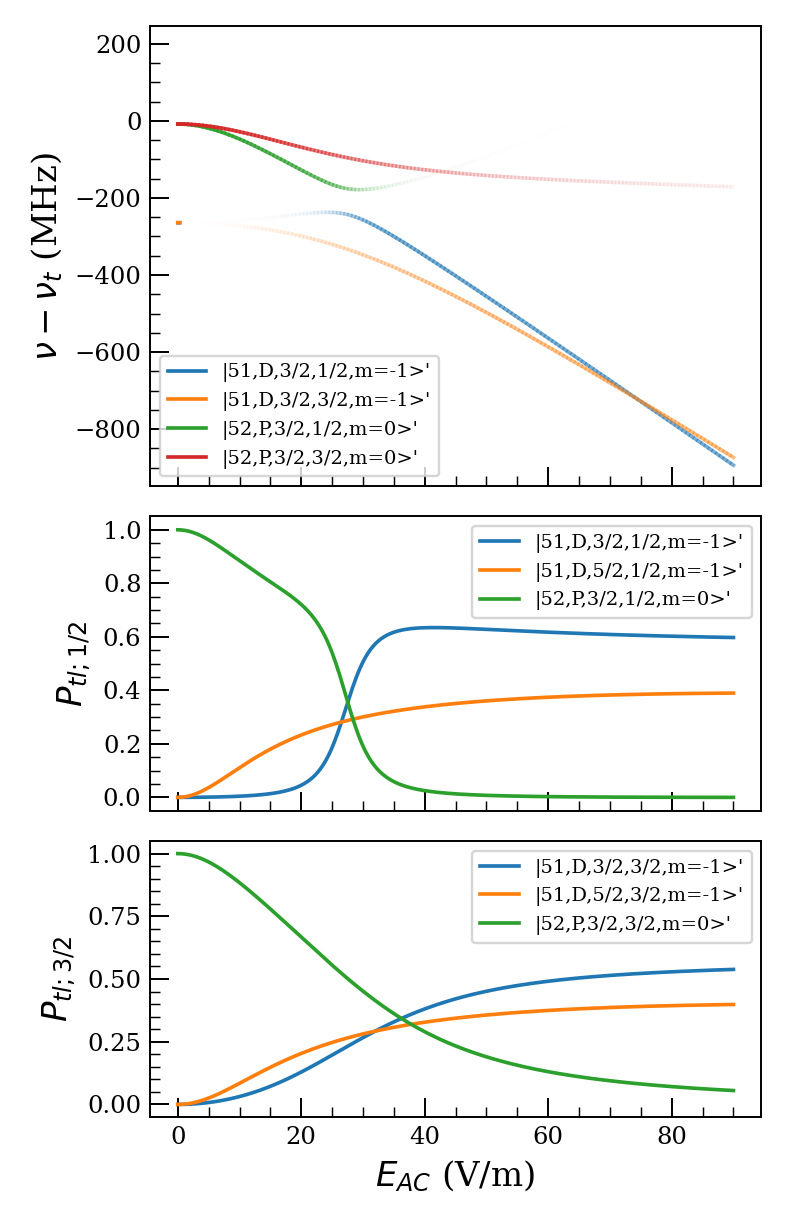

In [121]:
thrs = 0.2# threshold for caring about population
thrs2 = 0.5
fig,axar = plt.subplots(3,1,figsize=(4.5,7),gridspec_kw={'height_ratios': [2.5, 1.6, 1.5]})
iis = []
interesting_inds = []
e_inds = []
for i, state in enumerate(basis):
#    if [state.n,state.l,state.j,state["mj"]] == [t_level.n, t_level.l, t_level.j,3/2]:
    if [state.n,state.l,state.j] == [t_level.n, t_level.l, t_level.j]:
        iis.append(i+len(basis)*n_max)
for ii in iis:
    for k, p in enumerate(eigenstates[:,ii,:]):
        if max(np.absolute(p)**2)>thrs:
            interesting_inds.append(k)
        if max(np.absolute(p)**2)>thrs2:
            e_inds.append(k)
interesting_inds = list(set(interesting_inds))
count=0

for k in interesting_inds:
    kt = basis_n[k]
    ls = {0:"S",1:"P",2:"D",3:"F"}
    lab = f"|{kt.n},{ls[kt.l]},{int(2*kt.j)}/2,{int(2*kt['mj'])}/2,m={kt['nphot']}>'"
    if basis_n[k]["mj"] < 0:
        continue
    if theta_list is None:
        if basis_n[k]["mj"] is not None:
            if k in e_inds:
                color = f"C{count}"
                count+=1
                y_st = np.zeros(energies.shape[1],dtype=float)
                for ii in iis:
                    y_st += np.abs(eigenstates[k,ii,:])**2
                for i in range(len(energies[k,:]))[::2]:
                    if i == 0:
                        axar[0].plot(varied[1][i:i+2], 1e-6*np.real(energies[k,i:i+2]-0*energies[k,0])/tau, label=lab, alpha=y_st[i]*0+1,c=color)
                    else:
                        axar[0].plot(varied[1][i:i+2], 1e-6*np.real(energies[k,i:i+2]-0*energies[k,0])/tau, alpha=y_st[i],c=color)
            y_st = np.absolute(eigenstates[k,ii-1,:])**2
            if any(y_st > thrs):
                axar[1].plot(varied[1], y_st, label=lab)
            y_st = np.absolute(eigenstates[k,ii,:])**2
            if any(y_st > thrs):
                axar[2].plot(varied[1], y_st, label=lab)
        else:
            axar[0].plot(varied[1], 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau) #, label=basis_n[k].ket())
            axar[1].plot(varied[1], np.absolute(eigenstates[k,ii-1,:])**2) # , label=basis_n[k].ket())

    else:
        if basis_n[k]["mj"] is not None:
            axar[0].plot(varied[1]/pi, 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau, label=basis_n[k].ket())
            axar[1].plot(varied[1]/pi, np.absolute(eigenstates[k,ii,:])**2, label=basis_n[k].ket())
        else:
            axar[0].plot(varied[1]/pi, 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau) #, label=basis_n[k].ket())
            axar[1].plot(varied[1]/pi, np.absolute(eigenstates[k,ii,:])**2)# , label=basis_n[k].ket())            
    #print(f"state = {basis[k%len(basis)].ket()}, dE = 2pix{1e-6*np.real(Energies[k,-1]-Energies[k,0])/tau}MHz")
#axar[0].set_title("Change in Stark Shifts\n$E_{ac}$ = "+f"{Eac}V/m\n" + "$E_{dc}$ = " + f"{Edc}V/m")
#axar[0].set_ylim(-1.05e3,300)
#axar[1].set_title(f"Overlap with {basis_n[ii-1].ket()}")
#axar[1].set_yscale("log")
axar[1].set_ylabel("$P_{tl;1/2}$")
axar[2].set_ylabel("$P_{tl;3/2}$")
#axar[1].set_ylim(thrs*0.8,1)
if Edc_list is not None:
    axar[0].set_ylabel("DC Stark Shift/$2\pi$ (MHz)")
    axar[0].set_xlabel("DC Electric Field strength (V/m)")
    axar[1].set_xlabel("DC Electric Field strength (V/m)")
elif Eac_list is not None:
    #axar[0].set_title(f"Energy Levels\n$\omega_D = 2\pi\cdot{1e-6*field_omega/tau:.0f}$; $\epsilon$ = {ellipticity}")#"\n $E_{{dc}}$ = {Edc}V/m")
    axar[0].set_ylabel("$\\nu-\\nu_t$ (MHz)")
    #axar[0].set_xlabel("$E_{AC}$ (V/m)")
    axar[2].set_xlabel("$E_{AC}$ (V/m)")
elif theta_list is not None:
    #axar[0].set_ylabel("Change in DC Stark Shift/$2\pi$ (MHz)")
    axar[0].set_xlabel("$\\theta/\pi$ (radians)")
    axar[1].set_xlabel("Angle Between AC and DC fields/$\pi$/ (radians)")
axar[0].legend(loc=3,prop={"size":8})
axar[1].legend(loc=1,prop={"size":8})
axar[2].legend(loc=1,prop={"size":8})

axar[0].get_shared_x_axes().join(axar[0], axar[1])
axar[0].get_shared_x_axes().join(axar[1], axar[2])
axar[0].set_xticklabels([])
axar[1].set_xticklabels([])
axar[2].set_xlim(axar[0].get_xlim())
for ax in axar:
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
        item.set_fontsize(14)
#axar[1].legend()
fig.tight_layout()
#fig.savefig("Plots/AvoidedXEac.png")
fig.show()

In [ ]:
thrs = 0.11 # threshold for caring about population
fig,axar = plt.subplots(1,2,figsize=(10,5))
iis = []
interesting_inds = []
for i, state in enumerate(basis):
#    if [state.n,state.l,state.j,state["mj"]] == [t_level.n, t_level.l, t_level.j,3/2]:
    if [state.n,state.l,state.j] == [t_level.n, t_level.l, t_level.j]:
        iis.append(i+len(basis)*n_max)
for ii in iis:
    for k, p in enumerate(eigenstates[:,ii,:]):
        if max(np.absolute(p)**2)>thrs:
            interesting_inds.append(k)
interesting_inds = list(set(interesting_inds))
band_c = 0
for k in interesting_inds:
    band_c +=1
#    lab = t_level.ket()+f"band {band_c}" if energy_bands else basis_n[k].ket()
    lab = basis_n[k].ket()
    if theta_list is None:
        axar[0].plot(varied[1], 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau, label=lab)
        axar[1].plot(varied[1], np.absolute(eigenstates[k,ii-1,:])**2, label=lab)
    else:
        axar[0].plot(varied[1]/pi, 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau, label=basis_n[k].ket())
        axar[1].plot(varied[1]/pi, np.absolute(eigenstates[k,ii,:])**2, label=basis_n[k].ket())
    #print(f"state = {basis[k%len(basis)].ket()}, dE = 2pix{1e-6*np.real(Energies[k,-1]-Energies[k,0])/tau}MHz")
axar[0].set_title("Change in Stark Shifts\n$E_{ac}$ = "+f"{Eac}V/m\n" + "$E_{dc}$ = " + f"{Edc}V/m")
axar[0].set_title(f"DC field response\n$E_{{ac}}$ = {Eac}V/m, $\epsilon$ = {ellipticity:.3f}, $\\theta$ = {theta/pi}$\pi$")
#axar[0].set_ylim(-40,2)
axar[1].set_title(f"Overlap with {basis_n[ii-1].ket()}")
axar[1].set_yscale("log")
axar[1].set_ylim(thrs*0.8,1)
axar[0].legend(loc=3,prop={"size":14})
if Edc_list is not None:
    axar[0].set_ylabel("DC Stark Shift/$2\pi$ (MHz)")
    axar[0].set_xlabel("DC Electric Field strength (V/m)")
    axar[1].set_xlabel("DC Electric Field strength (V/m)")
elif Eac_list is not None:
    axar[0].set_title("Change in Stark Shifts\n$\epsilon$ = "+f"{ellipticity}\n" + "$E_{dc}$ = " + f"{Edc}V/m")
    axar[0].set_ylabel("AC Stark Shift/$2\pi$ (MHz)")
    axar[0].set_xlabel("AC Electric Field strength (V/m)")
    axar[1].set_xlabel("AC Electric Field strength (V/m)")
elif theta_list is not None:
    axar[0].set_ylabel("Change in DC Stark Shift/$2\pi$ (MHz)")
    axar[0].set_xlabel("$\\theta/\pi$ (radians)")
    axar[1].set_xlabel("Angle Between AC and DC fields/$\pi$/ (radians)")
#axar[1].legend()
for txt in [axar[0].xaxis.label,axar[0].yaxis.label,axar[0].title]:
    txt.set_fontsize(14)
fig.tight_layout()
fig.show()

## Fit to quadratic shifts, compare to alphas

In [ ]:
quad = lambda v, alpha, e0: -1/2*alpha*(v-0)**2+e0
four_pol = lambda v, alpha, beta, e0: -1/2*alpha*(v-0)**2+e0+beta*(v-0)**4
interesting_inds = list(set(interesting_inds))
 
func = four_pol
dim = len(basis_n)
#alphas = np.zeros(dim, dtype=float)
#dalphas = np.zeros(dim, dtype=float)
print("\n".join(basis_n[k].ket() for k in interesting_inds))
for k in iis:
    band_energies = energies[k,:]
#    guess = guess = [(band_energies[-1]-band_energies[0])/varied[1][-1]**2, band_energies[0]]
    guess = guess = [-2*(band_energies[-1]-band_energies[0])/varied[1][-1]**2, 0, band_energies[0]]
    try:
        popt, pcov = curve_fit(func, varied[1], band_energies, p0 = guess)
        perr = np.sqrt(np.diag(pcov))
    except RuntimeError:
        popt = [np.NaN]*len(guess)
        perr = popt
    print(f"state {basis_n[k].ket()} has polarizability fits:\n\t {popt}\n\t {perr}")
    
    fig,axar = plt.subplots(1,2,figsize=(10,4))
    ax=axar[0]
    ax.plot(varied[1],(band_energies - band_energies[0])*1e-6/tau, label = "Band energy")
    ax.plot(varied[1], (func(varied[1],*popt)-band_energies[0])*1e-6/tau, ls="-.", label = "Quadratic fit to band energy")
    ax.plot(varied[1], func(varied[1],guess[0],0,0*band_energies[0])*1e-6/tau, ls=":", label="Manual Guess")
    #ax.plot(varied[1], (quad(varied[1],popt[0], alphas[k], popt[2])-band_energies[0])*1e-6/tau, ls = ":", label = "fit from alphas")
    ax.legend()
    ax.set_xlabel(varied[0])
    ax.set_ylabel("DC Stark Shift/$2\pi$ (MHz)")
    ax.set_title(
        f"Quadratic fit on state {basis_n[k].ket()}\n$\\alpha$' = 2$\pi \cdot$ {popt[0]*1e-3/tau:.2f} $\pm$ {perr[0]*1e-3/tau:.2f} $KHz/(V/m)^2$\n$\\beta$' = 2$\pi \cdot$ {popt[1]/tau:.2e} $\pm$ {perr[1]/tau:.3e} $Hz/(V/m)^4$")# \n$\\alpha$'2 = 2$\pi \cdot$ {alphas[k]*1e-3/tau:.2f} $\pm$ {dalphas[k]*1e-3/tau:.2f} $KHz/(V/m)^2$")
    ax=axar[1]
    ax.plot(varied[1], (band_energies-func(varied[1],*popt))/tau, label = "Fit Residuals")
    ax.plot(varied[1], (band_energies-quad(varied[1],guess[0],guess[2]))/tau, ls=":", label="Guess residuals")
    ax.legend()
    ax.set_xlabel(varied[0])
    ax.set_ylabel("Fit Residuals (Hz)")
    fig.tight_layout()
    fig.show()

## Plot Energies for each relevant m_j

In [ ]:
thrs = 2e-1  # threshold for caring about population
look_at = t_level
#look_at = RydStateFS(51,2,5/2)
for i, state in enumerate(basis):
    if state == look_at:
        interesting_inds = []
        #print(state.ket())
        ii = i+len(basis)*n_max
        #print(ii)
        for k, p in enumerate(eigenstates[:,ii,:]):
            #check 
            #print(k)
            if max(np.absolute(p)**2)>thrs:
                interesting_inds.append(k)
                #print(f"index {k} is interesting")
                #print(f"corresponds to {basis_n[k].ket()}")
                #print(f"{p}")
                #print(max(p))
            #print(k,p.shape,p[1:].max())
        fig,axar = plt.subplots(1,2,figsize=(8,6))
        for k in interesting_inds:
            axar[0].plot(varied[1], 1e-6*np.real(energies[k,:])/tau, label=basis_n[k].ket())
            axar[1].plot(varied[1], np.absolute(eigenstates[k,ii,:])**2, label=basis_n[k].ket())
        axar[0].set_title("Energies")
        #axar[0].set_ylim(-1e3,6e3)
        axar[1].axhline(0.5,ls=":")
        axar[1].set_title("Probability")
        axar[1].set_yscale("log")
        axar[1].set_ylim(thrs*0.8,1)
        axar[0].legend()
        axar[0].set_ylabel("Rydberg State Energy/$2\pi$ (MHz)")
        if Edc_list is not None:
            axar[0].set_xlabel("DC Electric Field strength (V/m)")
            axar[1].set_xlabel("DC Electric Field strength (V/m)")
        elif Eac_list is not None:
            axar[0].set_xlabel("AC Electric Field strength (V/m)")
            axar[1].set_xlabel("AC Electric Field strength (V/m)")
        #axar[1].legend()
        fig.suptitle(f"State = {state.ket()}")
        fig.tight_layout()
        fig.show()

## Plot Relative Shifts for each relevant m_j

In [ ]:
thrs = 5e-2  # threshold for caring about population
look_at = t_level
#look_at = RydStateFS(51,2,5/2)
for i, state in enumerate(basis):
    if state == look_at:
        interesting_inds = []
        #print(state.ket())
        ii = i+len(basis)*n_max
        #print(ii)
        for k, p in enumerate(eigenstates[:,ii,:]):
            #check 
            #print(k)
            if max(np.absolute(p)**2)>thrs:
                interesting_inds.append(k)
                #print(f"index {k} is interesting")
                #print(f"corresponds to {basis_n[k].ket()}")
                #print(f"{p}")
                #print(max(p))
            #print(k,p.shape,p[1:].max())
        fig,axar = plt.subplots(1,2,figsize=(8,6))
        for k in interesting_inds:
            axar[0].plot(varied[1], 1e-6*np.real(energies[k,:]-energies[k,0])/tau, label=basis_n[k].ket())
            axar[1].plot(varied[1], np.absolute(eigenstates[k,ii,:])**2, label=basis_n[k].ket())
        axar[0].set_title("Energies")
        #axar[0].set_ylim(-1e3,6e3)
        axar[1].set_title("Probability")
        axar[1].set_yscale("log")
        axar[1].set_ylim(thrs*0.8,1)
        axar[0].legend()
        axar[0].set_ylabel("State DC Stark Shift/$2\pi$ (MHz)")
        if Edc_list is not None:
            axar[0].set_xlabel("DC Electric Field strength (V/m)")
            axar[1].set_xlabel("DC Electric Field strength (V/m)")
        elif Eac_list is not None:
            axar[0].set_xlabel("AC Electric Field strength (V/m)")
            axar[1].set_xlabel("AC Electric Field strength (V/m)")
        #axar[1].legend()
        fig.suptitle(f"State = {state.ket()}")
        fig.tight_layout()
        fig.show()

In [ ]:
thrs = 5e-2  # threshold for caring about population
look_at = t_level
#look_at = RydStateFS(51,2,5/2)
for i, state in enumerate(basis):
    if state == look_at:
        interesting_inds = []
        #print(state.ket())
        ii = i+len(basis)*n_max
        #print(ii)
        for k, p in enumerate(eigenstates[:,ii,:]):
            #check 
            #print(k)
            if max(np.absolute(p)**2)>thrs:
                interesting_inds.append(k)
                #print(f"index {k} is interesting")
                #print(f"corresponds to {basis_n[k].ket()}")
                #print(f"{p}")
                #print(max(p))
            #print(k,p.shape,p[1:].max())
        fig,axar = plt.subplots(1,2,figsize=(8,6))
        for k in interesting_inds:
            axar[0].plot(varied[1], 1e-6*np.real(energies[k,:]-energies[k,0])/tau, label=basis_n[k].ket())
            axar[1].plot(varied[1], np.absolute(eigenstates[k,ii,:])**2, label=basis_n[k].ket())
        axar[0].set_title("Energies")
        #axar[0].set_ylim(-1e3,6e3)
        axar[1].set_title("Probability")
        axar[1].set_yscale("log")
        axar[1].set_ylim(thrs*0.8,1)
        axar[0].legend()
        axar[0].set_ylabel("State DC Stark Shift/$2\pi$ (MHz)")
        if Edc_list is not None:
            axar[0].set_xlabel("DC Electric Field strength (V/m)")
            axar[1].set_xlabel("DC Electric Field strength (V/m)")
        elif Eac_list is not None:
            axar[0].set_xlabel("AC Electric Field strength (V/m)")
            axar[1].set_xlabel("AC Electric Field strength (V/m)")
        #axar[1].legend()
        fig.suptitle(f"State = {state.ket()}")
        fig.tight_layout()
        fig.show()

# Analytical comparison (NOT COMPLETE)

In [ ]:
# Mixing Parameters : TODO
pt = 0.7
pm = 0.3
th = np.arccos(np.sqrt(pt))
s2th = np.sin(2*th)**2
# Effective tensor polarizabilities : TODO
alpha2_t = 9
alpha2_m = -7
# Quantum numbers
j = t_level.j
mjs = np.arange(-j,j+1,1)


In [ ]:
def anisotropy_coefficient(mj):
    t1 = -3/4*(3*mj**2-j*(j+1))/j/(2*j-1)
    t2 = -3/4*(3*mj**2-(j+2)*(j+1))/(j+1)/(2*j+1)
    t3 = ((1+j)**2-0.5*(3+2*j)*mj-mj**2)/((j+1)*(2*j+1)*(2*j+3))
    
    return pt*alpha2_t*t1+pm*alpha2_m*t2+0.5*s2th*d10*t3/(omegam-omegap)

# Debugging

In [ ]:
Ht = np.diag([1,1,1,1,2,2,2,2,2])
print(Ht)
e, ev = np.linalg.eig(H0)
print((e-laser_dAC)*1e-6/tau)
print(np.diag(ev)-1)

In [ ]:
Eac = Eac_list[1]
Edc = 0
ellipticity = 0.012
theta = 0
HF = build_floquet(
    basis,
    H0,
    Eac,
    ellipticity,
    field_omega,
    Edc,
    theta,
    n_max
)
(HF-np.diag(np.diag(HF))).sum()

In [ ]:
e,ev =np.linalg.eig(HF)
print((ev-np.diag(np.diag(ev))).sum())

In [ ]:
np.dot(Ht,[1,1,0,0])

# Debugging

In [ ]:
fields
H_floquet = build_floquet(basis,H0,Eac,0.02,field_omega,Edc_list[-1],pi/2,n_max)
H_floquet = H_floquet
fig,ax = plt.subplots(1,1)
ax.imshow(np.real(H_floquet[(n_max-1)*len(basis):(n_max+1)*len(basis),(n_max-1)*len(basis):(n_max+1)*len(basis)]))
fig.show()

In [ ]:
fields
eigenvalues, eigenvectors = floquet_diag(basis, H0, n_max = n_max, **fields)

In [ ]:
energies = np.zeros((len(basis)*(2*n_max+1),2), dtype=complex)
eigenstates = np.zeros((len(basis)*(2*n_max+1), len(basis)*(2*n_max+1), 2), dtype=complex)
starts = level_starts(levels)
ips_summer = level_projector(basis, levels, n_max)

# compute overlaps wrt unperturbed eigenstates
ips = np.abs(eigenvectors)**2
# sum over all zeeman states in each level
ips_levels = np.dot(ips, ips_summer)
# sum over all level in each fourier sub basis
used_inds = []
troublesome_level = RydStateFS(51,2,5/2)
for j, level in enumerate(levels):
    for k, n in enumerate(range(-n_max, n_max+1)):
        print(f"finding good eigenvectors for |level, n> = |{level.ket()},{n}>")
        # eigenvectors that have >50% population in this level
        thrsh = 0.5
        inds_l = np.argwhere(ips_levels[:, j+k*len(levels)] > thrsh)
        # if the 50% threshold is too high to accommodate all m levels, lower the
        # threshold incrementally
        while len(inds_l) < 2*level.j+1:
            thrsh *= 0.95
            print(f"expansion required, threshold reduced to {thrsh}")
            inds_l = np.argwhere(ips_levels[:, j + k * len(levels)] > thrsh)

        # find the band that has the greatest overlap with each mj level
        print(f"inds_l = {inds_l[:,0]}")
        strt = starts[j]+k*len(basis)
        for a in range(int(2*level.j + 1)):
            # print(f"m = {-level.j + a}")
            # print(f"sub_ips = {ips[inds_l, strt + a]}")
            ev_ind = np.argmax(ips[inds_l, strt + a])
            if inds_l[ev_ind, 0] in used_inds:
                print(f"WARNING: index {inds_l[ev_ind, 0]} has been used")
            print(f"inds used = {inds_l[ev_ind,0]}")
            used_inds.append(inds_l[ev_ind, 0])
            # print(f"new inds = {inds_l[ev_ind,0]}")
            # print(f"New energy = {eigenvalues[inds_l[ev_ind, 0]]}")
            eigenstates[strt + a, :, 0] = eigenvectors[inds_l[ev_ind, 0], :]
            energies[strt + a, 0] = np.real(eigenvalues[inds_l[ev_ind, 0]])


In [ ]:
n = -2
k = n+n_max
j = 2
strt = starts[j]+k*len(basis)
end = starts[j+1]+k*len(basis)
ind_l = [32, 33, 34, 35]
for ind in ind_l:
    print(f"overlaps in range {basis_n[strt].ket()}-{basis_n[end-1].ket()} for ind = {ind}")
    print(f"\t{ips[ind,strt:end]}")

In [ ]:
basis[j].ket()

In [ ]:
strt

In [ ]:
ips_levels[32,j+k*len(levels)]

In [ ]:
thrs = 1e-2
print([f"{ev*(ev > thrs):.2e}" for ev in ips[32]])

In [ ]:
basis_print(levels)

# Convergence

In [ ]:
class ConvTest:
    def __init__(self, n_max, dw, dl, energies=None, eigenstates=None):
        self.n_max=n_max
        self.max_det = dw
        self.dl = dl
        self.energies = energies
        self.eigenstates = eigenstates
    def __repr__(self):
        return f"ConvTest({self.n_max},{self.max_det},{self.dl})"
    def __str__(self):
        return self.__repr__()

In [ ]:
filepath = "Shirley-Floquet_results\\convergence_tests"

ConvTests = [None]*(len(os.listdir(filepath))//2)
for i, file in enumerate(os.listdir(filepath)):
    test_str = "eigenstates.npy"
    nrg = "energies.npy"
    print(file)
    if file[-len(test_str):] == test_str:
        print(file)
        settings = file.split("-")[1:4]
        for setting in settings:
            exec(setting)
        ConvTests[i//2] = ConvTest(nmax,dw,dl)
        ConvTests[i//2].energies = np.load(os.path.join(filepath,file[:-len(test_str)]+nrg))
        # ConvTests[i//2].eigenstates = np.load(os.path.join(filepath,file))

In [ ]:
ConvTests

In [ ]:
for test in ConvTests:
    levels, basis = build_basis(t_level,test.max_det,single_side=False, dl=test.dl)
    target_inds = [i for i, state in enumerate(basis) if [state.n,state.l,state.j] == [t_level.n,t_level.l,t_level.j]]
    dim = len(basis)
    t_level_nrgs = {basis[k].ket(): test.energies[test.n_max*dim + k] for k in target_inds}
    #t_level_estates = {basis[k].ket(): test.eigenstates[test.n_max*dim + k] for k in target_inds}
    test.sub_nrgs = t_level_nrgs
    #test.sub_estates = t_level_estates

In [ ]:
ConvTests[0].desc = "$\Delta l = 2$, $m_{max} = 2$"#", $\omega_{max} = 2\pi\\times30GHz$"
ConvTests[1].desc = "$\Delta l = 1$, $m_{max} = 3$, $\omega_{max} = 2\pi\\times30GHz$"
ConvTests[2].desc = "$\Delta l = 2$, $m_{max} = 3$"#", $\omega_{max} = 2\pi\\times30GHz$"
ConvTests[3].desc = "$\Delta l = 1$, $m_{max} = 3$, $\omega_{max} = 2\pi\\times60GHz$"
ConvTests[4].desc = "$\Delta l = 1$, $m_{max} = 4$, $\omega_{max} = 2\pi\\times30GHz$"

In [ ]:
ConvTests[0].desc = "$\Delta l = 2$, $m_{max} = 2$"#", $\omega_{max} = 2\pi\\times30GHz$"
ConvTests[1].desc = "Baseline"
ConvTests[2].desc = "$\Delta l = 2$, $m_{max} = 3$"#", $\omega_{max} = 2\pi\\times30GHz$"
ConvTests[3].desc = "$\omega_{max} = 2\pi\\times60GHz$"
ConvTests[4].desc = "$m_{max} = 4$"

In [ ]:
ms = int(2*t_level.j+1)
#fig,axar = plt.subplots(ms,2,figsize=(8,ms*3))
#names = ["$\Delta l = 2, m_{max}-1$", "Baseline", "$\Delta l = 2$", "$2\\times \omega_{max}$", "$m_{max} + 1$"]
sub_list = ConvTests[1:]+[ConvTests[0]]
for m in range(ms):
    fig,axar = plt.subplots(2,1,figsize=(4,4.5),gridspec_kw={'height_ratios': [3, 2]})#,sharex=True)
    ax = axar[1]
    for t,test in enumerate(sub_list):
        m_key = list(test.sub_nrgs.keys())[m]
        ax.plot(varied[1],(test.sub_nrgs[m_key]-ConvTests[1].sub_nrgs[m_key])*1e-6/tau,label=test.desc)
    #ax.set_title(m_key)
    ax.set_ylabel("Correction (MHz)")
    ax.set_xlabel("$E_{DC}$ (V/m)")
    #ax.legend(loc="center right",prop={"size":9})
#ax.set_ylim(-1,1)
    
    ax = axar[0]
    for t,test in enumerate(sub_list):
        m_key = list(test.sub_nrgs.keys())[m]
        ax.plot(varied[1],(test.sub_nrgs[m_key]-test.sub_nrgs[m_key][0])*1e-6/tau,label=test.desc)
    #ax.set_title(m_key)
    ax.set_ylabel("$\Delta_{DC}$ (MHz)")
    #ax.set_xlabel("$E_{DC}$ (V/m)")
    ax.legend(loc=3,prop={"size":9})

    axar[0].get_shared_x_axes().join(axar[0], axar[1])
    axar[0].set_xticklabels([])
    axar[1].set_xlim(axar[0].get_xlim())

    for ax in axar:
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
            txt.set_fontsize("10")
    
    fig.tight_layout()
    fig.show()

In [ ]:
ms = int(2*t_level.j+1)
#fig,axar = plt.subplots(ms,2,figsize=(8,ms*3))
#names = ["$\Delta l = 2, m_{max}-1$", "Baseline", "$\Delta l = 2$", "$2\\times \omega_{max}$", "$m_{max} + 1$"]
sub_list = ConvTests[1:]+[ConvTests[0]]

sub_lists = [ConvTests[1:]+[ConvTests[0]],[ConvTests[0],ConvTests[2]]]
labs="abcd"
for m in range(ms):
    fig,axar = plt.subplots(2,2,figsize=(7,4.5),gridspec_kw={'height_ratios': [3, 2]})#,sharex=True)
    for i,sub_list in enumerate(sub_lists):
        ax = axar[1,i]
        for t,test in enumerate(sub_list):
            m_key = list(test.sub_nrgs.keys())[m]
            ax.plot(varied[1],(test.sub_nrgs[m_key]-sub_list[0].sub_nrgs[m_key])*1e-6/tau,label=test.desc)
        #ax.set_title(m_key)
        ax.set_ylabel("Correction (MHz)")
        ax.set_xlabel("$E_{DC}$ (V/m)")
        #ax.legend(loc="center right",prop={"size":9})
    #ax.set_ylim(-1,1)

        ax = axar[0,i]
        for t,test in enumerate(sub_list):
            m_key = list(test.sub_nrgs.keys())[m]
            ax.plot(varied[1],(test.sub_nrgs[m_key]-test.sub_nrgs[m_key][0])*1e-6/tau,label=test.desc)
        #ax.set_title(m_key)
        ax.set_ylabel("$\Delta_{DC}$ (MHz)")
        #ax.set_xlabel("$E_{DC}$ (V/m)")
        ax.legend(loc=3,prop={"size":9})

        axar[0,i].get_shared_x_axes().join(axar[0,i], axar[1,i])
        axar[0,i].set_xticklabels([])
        axar[1,i].set_xlim(axar[0,i].get_xlim())
        #axar[0,i].text(0,3, labs[2*i])
        #axar[1,i].text(-2,0, labs[2*i+1])
        
        for axs in axar:
            for ax in axs:
                ax.yaxis.set_ticks_position('left')
                ax.xaxis.set_ticks_position('bottom')
                for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
                    txt.set_fontsize("11")

    fig.tight_layout()
    fig.savefig(f"plots/Convergence_DCStark{m}n.png")
    fig.show()

In [ ]:
axar[1,1].text(5,5,"Test")
fig.show()

In [ ]:
func = lambda x, alpha, beta: -1/2*alpha*x**2+beta*x**4
popts = np.zeros((len(ConvTests),len(t_inds),2),dtype=float)
perrs = np.zeros(popts.shape,dtype=float)

ConvTests=ConvTests[1:]+[ConvTests[0]]
for j,m in enumerate(range(ms)):
    for i,test in enumerate(ConvTests):
        m_key = list(test.sub_nrgs.keys())[m]
        x_dat = varied[1]
        y_dat = test.sub_nrgs[m_key]-test.sub_nrgs[m_key][0]
        guess = [-2*y_dat[-1]/x_dat[-1]**2,0]
        popts[i,j], pcov = curve_fit(func,x_dat,y_dat,p0=guess)
        perrs[i,j] = np.sqrt(np.diag(pcov))

In [ ]:
fig,axar=plt.subplots(2,1,figsize=(6,4))
w=1/(ms+1)
for m in range(ms):
    ax=axar[0]
    locs = np.arange(len(ConvTests)-1)+(m-ms/2+1/2)*w
    ax.bar(locs,(popts[1:,m,0]-popts[0,m,0])*1e-3/tau,width=w,label=f"band {m}")
    ax.set_ylabel("$\Delta\\alpha'$ ($kHz/(V/m)^2$)")
    ax.legend()
    
    ax=axar[1]
    ax.bar(locs,(popts[1:,m,1]-popts[0,m,1])/tau,width=w)
    ax.set_ylabel("$\Delta\\beta'$ ($Hz/(V/m)^4$)")
    #ax.tick_params(axis='x', labelrotation = 90)
    axar[0].get_shared_x_axes().join(axar[0], axar[1])
    axar[0].set_xticklabels([])
    axar[1].set_xlim(axar[0].get_xlim())
    axar[1].set_xticks(np.arange(len(ConvTests)-1),minor=False)
    axar[1].set_xticklabels([test.desc for test in ConvTests[1:]])
    axar[1].set_xlim(-w*3,max(locs)+w)
    for ax in axar:
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.minorticks_off()
        
        for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
            txt.set_fontsize("10")
    [test.desc for test in ConvTests]
fig.tight_layout()
fig.savefig("Plots/ConvergencePolarizabilitiesn.png")
fig.show()